# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (ie 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2
import helpers as h

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
transcript_clean, transcript_all = h.transcript_preprocessing(transcript, profile, portfolio)

The transcript_clean.csv and transcript_merge.csv file are available at local folder


In [10]:
transcript_clean.head(5)

event                            person  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0   
2  offer received  e2127556f4f64592b11af22de27a7932     0   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0   

                                              value  \
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}   
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}   
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}   
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}   
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}   

                           offer_id  amount  age became_member_on gender  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN   75       2017-05-09      F   
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN  118       2017-08-04   None   
2  2906b810c7d4411798c6938adc9daaa5     NaN   68       2018-04-26      M   
3  fafdcd668e3743c1bb461111dcafc2a4     NaN  118       2017-09-25   None   
4  4d5c57ea9a6940dd891ad53e9dbe8da0     NaN  118       2017-10-02   None   

     income  difficulty  duration offer_type  reward              name  web  \
0  100000.0         5.0       7.0       bogo     5.0        bogo_5_5_7  1.0   
1       NaN        20.0      10.0   discount     5.0  discount_20_5_10  1.0   
2   70000.0        10.0       7.0   discount     2.0   discount_10_2_7  1.0   
3       NaN        10.0      10.0   discount     2.0  discount_10_2_10  1.0   
4       NaN        10.0       5.0       bogo    10.0      bogo_10_10_5  1.0   

   email  mobile  social  invalid  
0    1.0     1.0     0.0      0.0  
1    1.0     0.0     0.0      0.0  
2    1.0     1.0     0.0      0.0  
3    1.0     1.0     1.0      0.0  
4    1.0     1.0     1.0      0.0

In [4]:
transcript_all.head(5)

event                            person  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0   
2  offer received  e2127556f4f64592b11af22de27a7932     0   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0   

                                              value  \
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}   
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}   
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}   
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}   
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}   

                           offer_id  amount  age became_member_on gender  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN   75       2017-05-09      F   
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN  118       2017-08-04   None   
2  2906b810c7d4411798c6938adc9daaa5     NaN   68       2018-04-26      M   
3  fafdcd668e3743c1bb461111dcafc2a4     NaN  118       2017-09-25   None   
4  4d5c57ea9a6940dd891ad53e9dbe8da0     NaN  118       2017-10-02   None   

     income  difficulty  duration offer_type  reward              name  web  \
0  100000.0         5.0       7.0       bogo     5.0        bogo_5_5_7  1.0   
1       NaN        20.0      10.0   discount     5.0  discount_20_5_10  1.0   
2   70000.0        10.0       7.0   discount     2.0   discount_10_2_7  1.0   
3       NaN        10.0      10.0   discount     2.0  discount_10_2_10  1.0   
4       NaN        10.0       5.0       bogo    10.0      bogo_10_10_5  1.0   

   email  mobile  social  invalid  
0    1.0     1.0     0.0      0.0  
1    1.0     0.0     0.0      0.0  
2    1.0     1.0     0.0      0.0  
3    1.0     1.0     1.0      0.0  
4    1.0     1.0     1.0      0.0

In [3]:
#import helpers as h
profile_updated = h.feature_extraction(transcript_clean,profile, portfolio)

The profile_updated.csv file is available at local folder.


In [103]:
profile_updated.head()

age became_member_on gender    income  \
Unnamed: 0                                                                
68be06ca386d4c31939f3a4f0e3dd783  118       2017-02-12    NaN       NaN   
0610b486422d4921ae7d2bf64640c50b   55       2017-07-15      F  112000.0   
38fe809add3b4fcf9315a9694bb96ff5  118       2018-07-12    NaN       NaN   
78afa995795e4d85b5d9ceeca43f5fef   75       2017-05-09      F  100000.0   
a03223e636434f42ac4c3df47e8bac43  118       2017-08-04    NaN       NaN   

                                  offer received_bogo_10_10_7  \
Unnamed: 0                                                      
68be06ca386d4c31939f3a4f0e3dd783                          0.0   
0610b486422d4921ae7d2bf64640c50b                          0.0   
38fe809add3b4fcf9315a9694bb96ff5                          0.0   
78afa995795e4d85b5d9ceeca43f5fef                          1.0   
a03223e636434f42ac4c3df47e8bac43                          0.0   

                                  offer received_bogo_10_10_5  \
Unnamed: 0                                                      
68be06ca386d4c31939f3a4f0e3dd783                          0.0   
0610b486422d4921ae7d2bf64640c50b                          0.0   
38fe809add3b4fcf9315a9694bb96ff5                          0.0   
78afa995795e4d85b5d9ceeca43f5fef                          0.0   
a03223e636434f42ac4c3df47e8bac43                          0.0   

                                  offer received_informational_0_0_4  \
Unnamed: 0                                                             
68be06ca386d4c31939f3a4f0e3dd783                                 0.0   
0610b486422d4921ae7d2bf64640c50b                                 1.0   
38fe809add3b4fcf9315a9694bb96ff5                                 0.0   
78afa995795e4d85b5d9ceeca43f5fef                                 0.0   
a03223e636434f42ac4c3df47e8bac43                                 1.0   

                                  offer received_bogo_5_5_7  \
Unnamed: 0                                                    
68be06ca386d4c31939f3a4f0e3dd783                        0.0   
0610b486422d4921ae7d2bf64640c50b                        1.0   
38fe809add3b4fcf9315a9694bb96ff5                        1.0   
78afa995795e4d85b5d9ceeca43f5fef                        1.0   
a03223e636434f42ac4c3df47e8bac43                        0.0   

                                  offer received_discount_20_5_10  \
Unnamed: 0                                                          
68be06ca386d4c31939f3a4f0e3dd783                              1.0   
0610b486422d4921ae7d2bf64640c50b                              0.0   
38fe809add3b4fcf9315a9694bb96ff5                              0.0   
78afa995795e4d85b5d9ceeca43f5fef                              0.0   
a03223e636434f42ac4c3df47e8bac43                              3.0   

                                  offer received_discount_7_3_7    ...     \
Unnamed: 0                                                         ...      
68be06ca386d4c31939f3a4f0e3dd783                            1.0    ...      
0610b486422d4921ae7d2bf64640c50b                            0.0    ...      
38fe809add3b4fcf9315a9694bb96ff5                            0.0    ...      
78afa995795e4d85b5d9ceeca43f5fef                            0.0    ...      
a03223e636434f42ac4c3df47e8bac43                            0.0    ...      

                                  discount_7_3_7_response_time_avg  \
Unnamed: 0                                                           
68be06ca386d4c31939f3a4f0e3dd783                              48.0   
0610b486422d4921ae7d2bf64640c50b                               NaN   
38fe809add3b4fcf9315a9694bb96ff5                               NaN   
78afa995795e4d85b5d9ceeca43f5fef                               NaN   
a03223e636434f42ac4c3df47e8bac43                               NaN   

                                  discount_10_2_10_response_time_avg  \
Unnamed: 0                                                    

In [4]:
""" Add information 'invalid' columns means how many each customer make trancsaction without influenced by the offer """

person_invalid = transcript_all[transcript_all.invalid == 1].person.value_counts()
person_invalid.head()

a18461ce01d340eb8704bf7fb692c6ba    6
05a009c95e8d477cbed5c1661343bbb9    5
0b63d4cabf5f4c1eab0277c6c1b09362    5
7055b5fa5f8647618aa14e220b7c6b5c    5
91cec8d70c5a4c5aa04a0ee01653e5ad    5
Name: person, dtype: int64

In [5]:
# create new feature 'invalid', how many invalid transaction made by customer (transaction that not influenced by offer)
profile_updated['invalid'] = person_invalid
profile_updated['invalid'] = profile_updated['invalid'].fillna(0)
profile_updated.head()

age became_member_on gender    income  \
Unnamed: 0                                                                
68be06ca386d4c31939f3a4f0e3dd783  118       2017-02-12    NaN       NaN   
0610b486422d4921ae7d2bf64640c50b   55       2017-07-15      F  112000.0   
38fe809add3b4fcf9315a9694bb96ff5  118       2018-07-12    NaN       NaN   
78afa995795e4d85b5d9ceeca43f5fef   75       2017-05-09      F  100000.0   
a03223e636434f42ac4c3df47e8bac43  118       2017-08-04    NaN       NaN   

                                  offer received_bogo_10_10_7  \
Unnamed: 0                                                      
68be06ca386d4c31939f3a4f0e3dd783                          0.0   
0610b486422d4921ae7d2bf64640c50b                          0.0   
38fe809add3b4fcf9315a9694bb96ff5                          0.0   
78afa995795e4d85b5d9ceeca43f5fef                          1.0   
a03223e636434f42ac4c3df47e8bac43                          0.0   

                                  offer received_bogo_10_10_5  \
Unnamed: 0                                                      
68be06ca386d4c31939f3a4f0e3dd783                          0.0   
0610b486422d4921ae7d2bf64640c50b                          0.0   
38fe809add3b4fcf9315a9694bb96ff5                          0.0   
78afa995795e4d85b5d9ceeca43f5fef                          0.0   
a03223e636434f42ac4c3df47e8bac43                          0.0   

                                  offer received_informational_0_0_4  \
Unnamed: 0                                                             
68be06ca386d4c31939f3a4f0e3dd783                                 0.0   
0610b486422d4921ae7d2bf64640c50b                                 1.0   
38fe809add3b4fcf9315a9694bb96ff5                                 0.0   
78afa995795e4d85b5d9ceeca43f5fef                                 0.0   
a03223e636434f42ac4c3df47e8bac43                                 1.0   

                                  offer received_bogo_5_5_7  \
Unnamed: 0                                                    
68be06ca386d4c31939f3a4f0e3dd783                        0.0   
0610b486422d4921ae7d2bf64640c50b                        1.0   
38fe809add3b4fcf9315a9694bb96ff5                        1.0   
78afa995795e4d85b5d9ceeca43f5fef                        1.0   
a03223e636434f42ac4c3df47e8bac43                        0.0   

                                  offer received_discount_20_5_10  \
Unnamed: 0                                                          
68be06ca386d4c31939f3a4f0e3dd783                              1.0   
0610b486422d4921ae7d2bf64640c50b                              0.0   
38fe809add3b4fcf9315a9694bb96ff5                              0.0   
78afa995795e4d85b5d9ceeca43f5fef                              0.0   
a03223e636434f42ac4c3df47e8bac43                              3.0   

                                  offer received_discount_7_3_7   ...     \
Unnamed: 0                                                        ...      
68be06ca386d4c31939f3a4f0e3dd783                            1.0   ...      
0610b486422d4921ae7d2bf64640c50b                            0.0   ...      
38fe809add3b4fcf9315a9694bb96ff5                            0.0   ...      
78afa995795e4d85b5d9ceeca43f5fef                            0.0   ...      
a03223e636434f42ac4c3df47e8bac43                            0.0   ...      

                                  discount_10_2_10_response_time_avg  \
Unnamed: 0                                                             
68be06ca386d4c31939f3a4f0e3dd783                               144.0   
0610b486422d4921ae7d2bf64640c50b                                 NaN   
38fe809add3b4fcf9315a9694bb96ff5                                 NaN   
78afa995795e4d85b5d9ceeca43f5fef                                 NaN   
a03223e636434f42ac4c3df47e8bac43                                 NaN   

                                  bogo_5_5_5_response_time_avg  \
Unnamed: 0                                                   

In [6]:
""" 
Create features
    - Total Count of the offer received, reviewed, completed for each type of portfolio (bogo, discount, and informational)
    - Rates for each offering type (bogo/discount/informational) : 
        - rate_review = total reviewed / total received
        - rate_completed_reviewed = total completed / total reviewed
        - rate_completed_received = tatal completed / total received

"""


for offer in ['bogo', 'discount', 'informational']:
    received_cols = profile_updated.columns[(profile_updated.columns.str.contains('received_' + offer)) & \
                                            (~profile_updated.columns.str.contains('rate' ))].tolist()
    profile_updated[offer +'_received'] = profile_updated[received_cols].sum(axis=1).fillna(0)
    
    viewed_cols = profile_updated.columns[(profile_updated.columns.str.contains('viewed_' + offer)) & \
                                            (~profile_updated.columns.str.contains('rate'))].tolist()
    profile_updated[offer +'_viewed'] = profile_updated[viewed_cols].sum(axis=1).fillna(0)
    
    profile_updated['rate_viewed_' + offer] = (profile_updated[offer +'_viewed'] / profile_updated[offer +'_received']).fillna(0)
    
    if offer != 'informational':
        completed_cols = profile_updated.columns[(profile_updated.columns.str.contains('completed_' + offer)) & \
                                            (~profile_updated.columns.str.contains('rate' ))].tolist()
        profile_updated[offer +'_completed'] = profile_updated[completed_cols].sum(axis=1).fillna(0)
        
        profile_updated['rate_completed_viewed_' + offer] = \
                    (profile_updated[offer +'_completed'] /profile_updated[offer +'_viewed']).fillna(0)
        profile_updated['rate_completed_received_' + offer] = \
                    (profile_updated[offer +'_completed'] / profile_updated[offer +'_received']).fillna(0)

In [7]:
profile_updated.head()

age became_member_on gender    income  \
Unnamed: 0                                                                
68be06ca386d4c31939f3a4f0e3dd783  118       2017-02-12    NaN       NaN   
0610b486422d4921ae7d2bf64640c50b   55       2017-07-15      F  112000.0   
38fe809add3b4fcf9315a9694bb96ff5  118       2018-07-12    NaN       NaN   
78afa995795e4d85b5d9ceeca43f5fef   75       2017-05-09      F  100000.0   
a03223e636434f42ac4c3df47e8bac43  118       2017-08-04    NaN       NaN   

                                  offer received_bogo_10_10_7  \
Unnamed: 0                                                      
68be06ca386d4c31939f3a4f0e3dd783                          0.0   
0610b486422d4921ae7d2bf64640c50b                          0.0   
38fe809add3b4fcf9315a9694bb96ff5                          0.0   
78afa995795e4d85b5d9ceeca43f5fef                          1.0   
a03223e636434f42ac4c3df47e8bac43                          0.0   

                                  offer received_bogo_10_10_5  \
Unnamed: 0                                                      
68be06ca386d4c31939f3a4f0e3dd783                          0.0   
0610b486422d4921ae7d2bf64640c50b                          0.0   
38fe809add3b4fcf9315a9694bb96ff5                          0.0   
78afa995795e4d85b5d9ceeca43f5fef                          0.0   
a03223e636434f42ac4c3df47e8bac43                          0.0   

                                  offer received_informational_0_0_4  \
Unnamed: 0                                                             
68be06ca386d4c31939f3a4f0e3dd783                                 0.0   
0610b486422d4921ae7d2bf64640c50b                                 1.0   
38fe809add3b4fcf9315a9694bb96ff5                                 0.0   
78afa995795e4d85b5d9ceeca43f5fef                                 0.0   
a03223e636434f42ac4c3df47e8bac43                                 1.0   

                                  offer received_bogo_5_5_7  \
Unnamed: 0                                                    
68be06ca386d4c31939f3a4f0e3dd783                        0.0   
0610b486422d4921ae7d2bf64640c50b                        1.0   
38fe809add3b4fcf9315a9694bb96ff5                        1.0   
78afa995795e4d85b5d9ceeca43f5fef                        1.0   
a03223e636434f42ac4c3df47e8bac43                        0.0   

                                  offer received_discount_20_5_10  \
Unnamed: 0                                                          
68be06ca386d4c31939f3a4f0e3dd783                              1.0   
0610b486422d4921ae7d2bf64640c50b                              0.0   
38fe809add3b4fcf9315a9694bb96ff5                              0.0   
78afa995795e4d85b5d9ceeca43f5fef                              0.0   
a03223e636434f42ac4c3df47e8bac43                              3.0   

                                  offer received_discount_7_3_7  \
Unnamed: 0                                                        
68be06ca386d4c31939f3a4f0e3dd783                            1.0   
0610b486422d4921ae7d2bf64640c50b                            0.0   
38fe809add3b4fcf9315a9694bb96ff5                            0.0   
78afa995795e4d85b5d9ceeca43f5fef                            0.0   
a03223e636434f42ac4c3df47e8bac43                            0.0   

                                            ...              \
Unnamed: 0                                  ...               
68be06ca386d4c31939f3a4f0e3dd783            ...               
0610b486422d4921ae7d2bf64640c50b            ...               
38fe809add3b4fcf9315a9694bb96ff5            ...               
78afa995795e4d85b5d9ceeca43f5fef            ...               
a03223e636434f42ac4c3df47e8bac43            ...               

                                  rate_completed_received_bogo  \
Unnamed: 0                                                       
68be06ca386d4c31939f3a4f0e3dd783                      0.000000   
0610b486422d4921ae7d2bf64640c50b                      0

In [8]:
""" 
Create Feature :
- Total count of received, viewed, completed
- Overall Rates : 
        - rate_review = total reviewed / total received
        - rate_completed_reviewed = total completed / total reviewed
        - rate_completed_received = tatal completed / total received
        
"""
profile_updated['offer_received_total'] = profile_updated.bogo_received + profile_updated.discount_received + \
                                        profile_updated.informational_received

profile_updated['offer_viewed_total'] = profile_updated.bogo_viewed + profile_updated.discount_viewed + \
                                        profile_updated.informational_viewed

profile_updated['offer_completed_total'] = profile_updated.bogo_completed + profile_updated.discount_completed 

profile_updated['rate_offer_viewed_overall'] = \
        (profile_updated['offer_viewed_total'] / profile_updated['offer_received_total']).fillna(0)

profile_updated['rate_offer_completed_received_overall'] = \
        (profile_updated['offer_completed_total'] / profile_updated['offer_received_total']).fillna(0)

profile_updated['rate_offer_completed_viewed_overall'] = \
        (profile_updated['offer_completed_total'] / profile_updated['offer_viewed_total']).fillna(0)

In [9]:
profile_updated.head()

age became_member_on gender    income  \
Unnamed: 0                                                                
68be06ca386d4c31939f3a4f0e3dd783  118       2017-02-12    NaN       NaN   
0610b486422d4921ae7d2bf64640c50b   55       2017-07-15      F  112000.0   
38fe809add3b4fcf9315a9694bb96ff5  118       2018-07-12    NaN       NaN   
78afa995795e4d85b5d9ceeca43f5fef   75       2017-05-09      F  100000.0   
a03223e636434f42ac4c3df47e8bac43  118       2017-08-04    NaN       NaN   

                                  offer received_bogo_10_10_7  \
Unnamed: 0                                                      
68be06ca386d4c31939f3a4f0e3dd783                          0.0   
0610b486422d4921ae7d2bf64640c50b                          0.0   
38fe809add3b4fcf9315a9694bb96ff5                          0.0   
78afa995795e4d85b5d9ceeca43f5fef                          1.0   
a03223e636434f42ac4c3df47e8bac43                          0.0   

                                  offer received_bogo_10_10_5  \
Unnamed: 0                                                      
68be06ca386d4c31939f3a4f0e3dd783                          0.0   
0610b486422d4921ae7d2bf64640c50b                          0.0   
38fe809add3b4fcf9315a9694bb96ff5                          0.0   
78afa995795e4d85b5d9ceeca43f5fef                          0.0   
a03223e636434f42ac4c3df47e8bac43                          0.0   

                                  offer received_informational_0_0_4  \
Unnamed: 0                                                             
68be06ca386d4c31939f3a4f0e3dd783                                 0.0   
0610b486422d4921ae7d2bf64640c50b                                 1.0   
38fe809add3b4fcf9315a9694bb96ff5                                 0.0   
78afa995795e4d85b5d9ceeca43f5fef                                 0.0   
a03223e636434f42ac4c3df47e8bac43                                 1.0   

                                  offer received_bogo_5_5_7  \
Unnamed: 0                                                    
68be06ca386d4c31939f3a4f0e3dd783                        0.0   
0610b486422d4921ae7d2bf64640c50b                        1.0   
38fe809add3b4fcf9315a9694bb96ff5                        1.0   
78afa995795e4d85b5d9ceeca43f5fef                        1.0   
a03223e636434f42ac4c3df47e8bac43                        0.0   

                                  offer received_discount_20_5_10  \
Unnamed: 0                                                          
68be06ca386d4c31939f3a4f0e3dd783                              1.0   
0610b486422d4921ae7d2bf64640c50b                              0.0   
38fe809add3b4fcf9315a9694bb96ff5                              0.0   
78afa995795e4d85b5d9ceeca43f5fef                              0.0   
a03223e636434f42ac4c3df47e8bac43                              3.0   

                                  offer received_discount_7_3_7  \
Unnamed: 0                                                        
68be06ca386d4c31939f3a4f0e3dd783                            1.0   
0610b486422d4921ae7d2bf64640c50b                            0.0   
38fe809add3b4fcf9315a9694bb96ff5                            0.0   
78afa995795e4d85b5d9ceeca43f5fef                            0.0   
a03223e636434f42ac4c3df47e8bac43                            0.0   

                                                 ...                   \
Unnamed: 0                                       ...                    
68be06ca386d4c31939f3a4f0e3dd783                 ...                    
0610b486422d4921ae7d2bf64640c50b                 ...                    
38fe809add3b4fcf9315a9694bb96ff5                 ...                    
78afa995795e4d85b5d9ceeca43f5fef                 ...                    
a03223e636434f42ac4c3df47e8bac43                 ...                    

                                  rate_completed_received_discount  \
Unnamed: 0                                                           
68be06ca386d4c31939f3a4f0e3dd783           

In [10]:
"""
Create Feature :
- Rates for each offering in portfolio  : 
        - rate_review = total reviewed / total received
        - rate_completed_reviewed = total completed / total reviewed
        - rate_completed_received = tatal completed / total received
"""

portfolio_updated = h.portfolio_preprocessing(portfolio)

for offer_name in portfolio_updated.name.tolist():
    profile_updated['rate_offer_viewed_' + offer_name ] = \
        (profile_updated['offer viewed_' + offer_name] / profile_updated['offer received_' + offer_name]).fillna(0)
       
    if offer_name not in portfolio_updated[portfolio_updated.name.str.contains('informational')]['name'].tolist() :
        profile_updated['rate_offer_completed_viewed_' + offer_name ] = \
            (profile_updated['offer completed_' + offer_name] / profile_updated['offer viewed_' + offer_name]).fillna(0)
    
        profile_updated['rate_offer_completed_received_' + offer_name ] = \
            (profile_updated['offer completed_' + offer_name] / profile_updated['offer received_' + offer_name]).fillna(0)

In [11]:
profile_updated['transaction_completed_ratio'] = profile_updated.transaction_count / (profile_updated.offer_completed_total + 0.1)

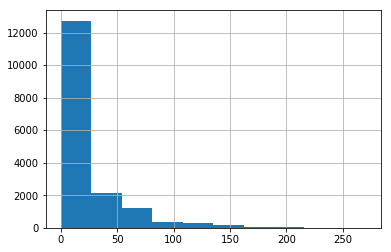

In [12]:

(profile_updated.transaction_count / (profile_updated.offer_completed_total + 0.1)).hist()

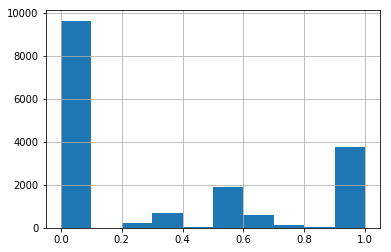

In [13]:
profile_updated.rate_completed_received_bogo.hist()

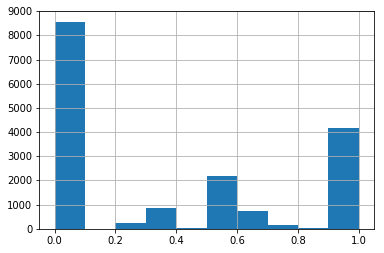

In [14]:
profile_updated.rate_completed_received_discount.hist()

# 1. Preprocessing

## 1.1 Assess missing data in columns

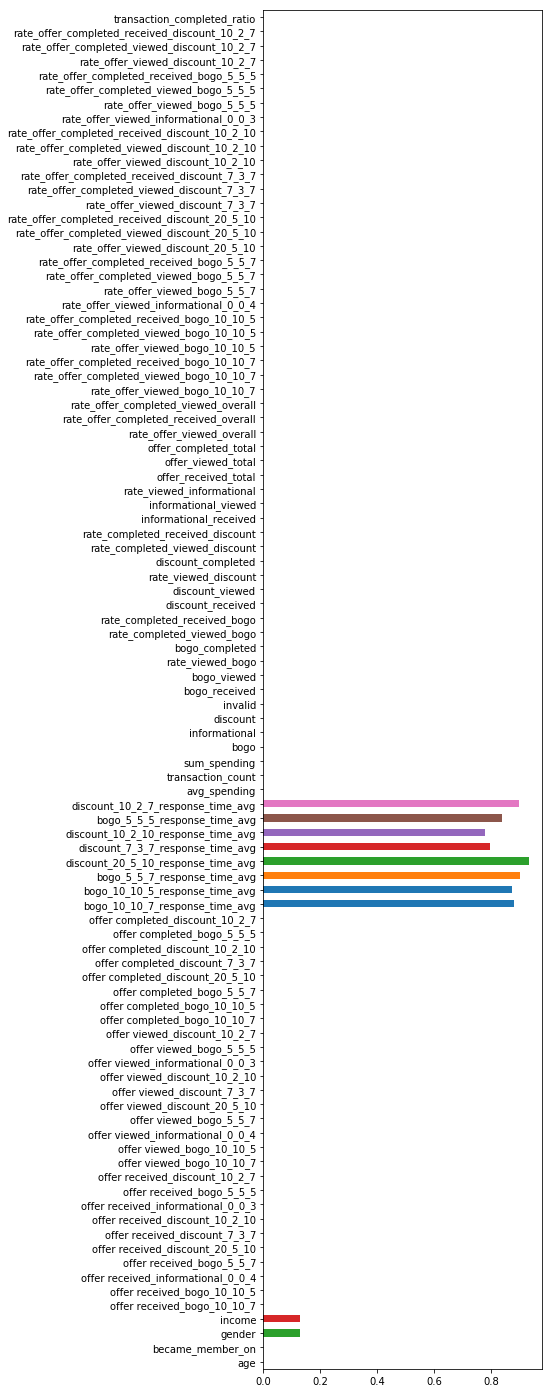

In [17]:
col_null = profile_updated.isnull().sum()
col_null_frac = col_null / profile_updated.shape[0]

plt.figure(figsize= (5,25))
col_null_frac.plot(kind='barh')


In [18]:
# cols to drop that have more than 50% missing values
cols_to_drop = col_null_frac[col_null_frac > 0.5].index.tolist()
cols_to_drop

['bogo_10_10_7_response_time_avg',
 'bogo_10_10_5_response_time_avg',
 'bogo_5_5_7_response_time_avg',
 'discount_20_5_10_response_time_avg',
 'discount_7_3_7_response_time_avg',
 'discount_10_2_10_response_time_avg',
 'bogo_5_5_5_response_time_avg',
 'discount_10_2_7_response_time_avg']

In [19]:
profile_updated_ = profile_updated.drop(cols_to_drop, axis=1)

## 1.2 Assess missing data in rows

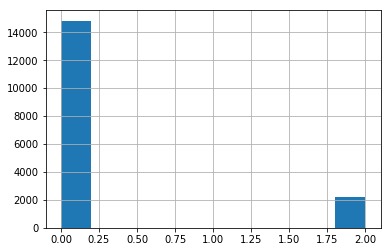

In [236]:
# How much data is missing in each row of the dataset?

row_null = profile_updated_.isnull().sum(axis=1)
row_null.hist()

In [195]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

def dist_compare(attribute, data):
    row_null = data.isnull().sum(axis=1)
    f, (ax1,ax2) = plt.subplots(1,2)
    ax1 = sns.countplot(attribute, data=data[row_null==0], ax=ax1)
    ax2 = sns.countplot(attribute, data=data[row_null > 0], ax=ax2)
    ax1.set_title('No missing value')
    ax2.set_title('With missing value')
    f.suptitle('Feature: ' + attribute)
    f.tight_layout()
    f.subplots_adjust(top=0.8)

In [198]:
profile_updated.columns[profile_updated.columns.str.contains('rate')]

Index(['rate_viewed_bogo', 'rate_completed_viewed_bogo',
       'rate_completed_received_bogo', 'rate_viewed_discount',
       'rate_completed_viewed_discount', 'rate_completed_received_discount',
       'rate_viewed_informational', 'rate_offer_viewed_overall',
       'rate_offer_completed_received_overall',
       'rate_offer_completed_viewed_overall', 'rate_offer_viewed_bogo_10_10_7',
       'rate_offer_completed_viewed_bogo_10_10_7',
       'rate_offer_completed_received_bogo_10_10_7',
       'rate_offer_viewed_bogo_10_10_5',
       'rate_offer_completed_viewed_bogo_10_10_5',
       'rate_offer_completed_received_bogo_10_10_5',
       'rate_offer_viewed_informational_0_0_4', 'rate_offer_viewed_bogo_5_5_7',
       'rate_offer_completed_viewed_bogo_5_5_7',
       'rate_offer_completed_received_bogo_5_5_7',
       'rate_offer_viewed_discount_20_5_10',
       'rate_offer_completed_viewed_discount_20_5_10',
       'rate_offer_completed_received_discount_20_5_10',
       'rate_offer_viewe

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


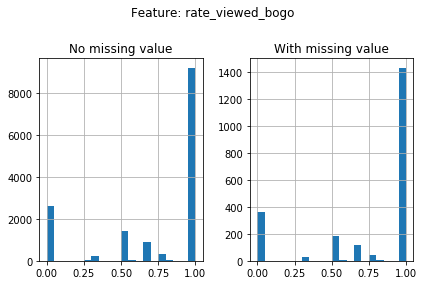

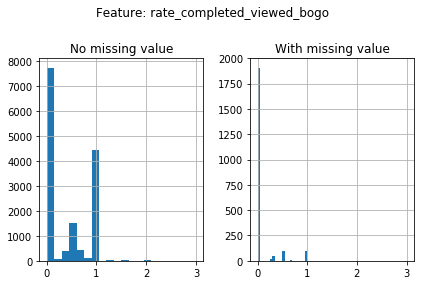

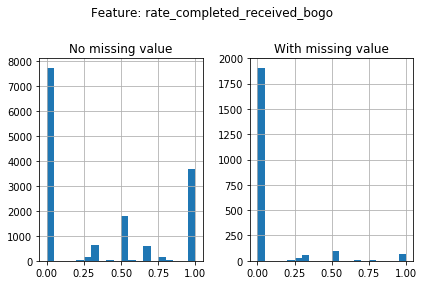

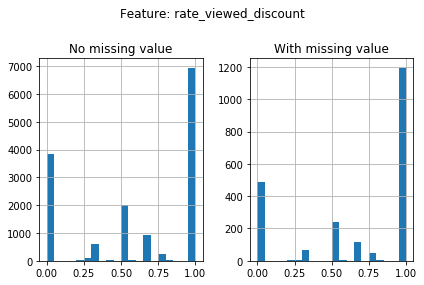

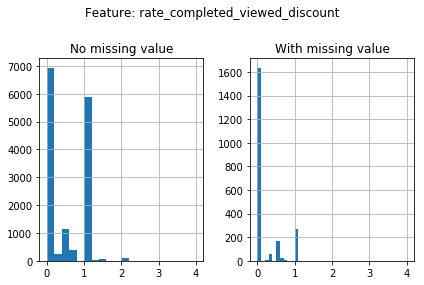

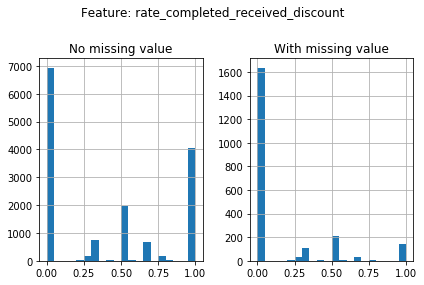

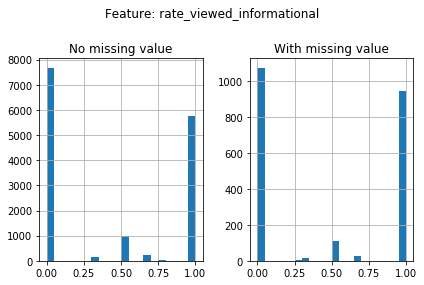

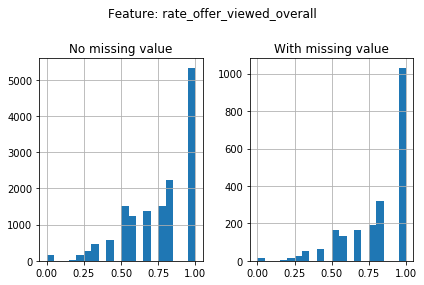

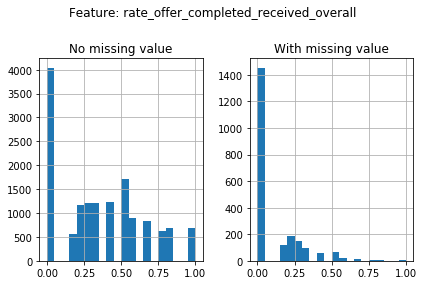

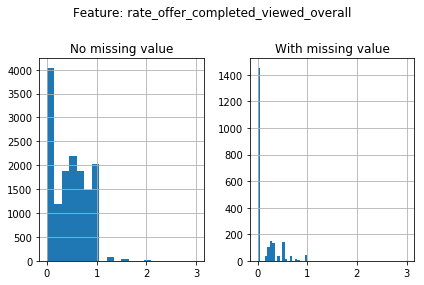

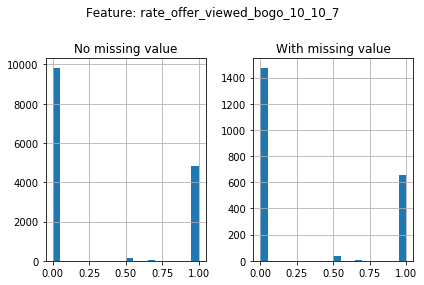

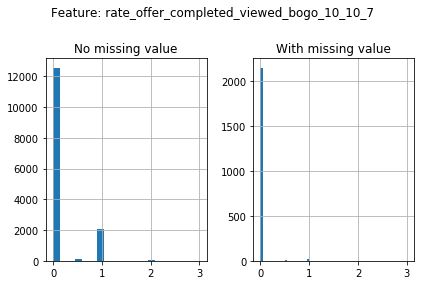

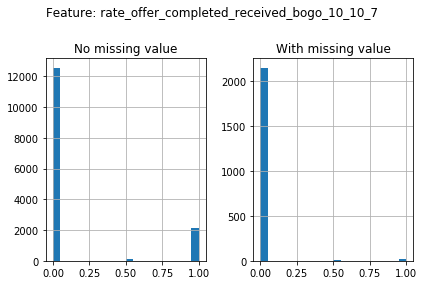

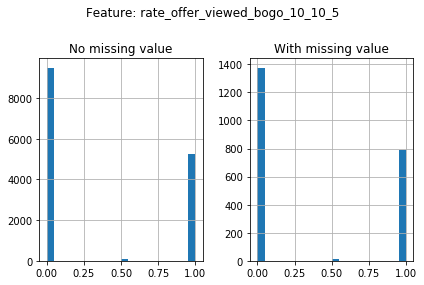

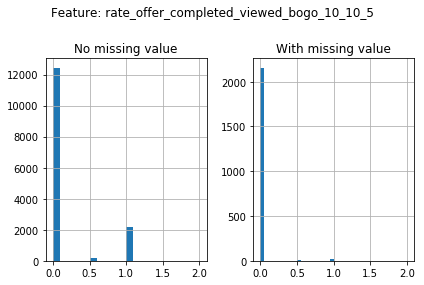

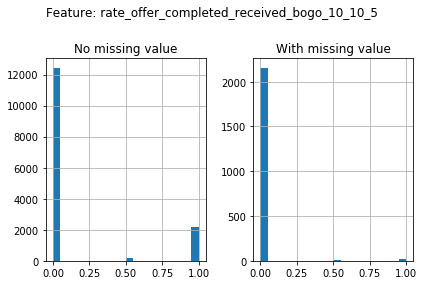

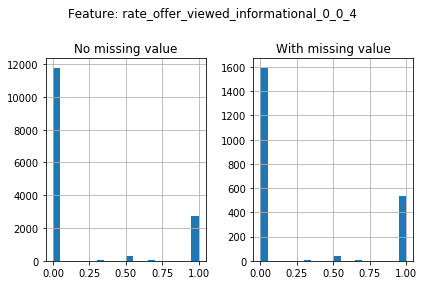

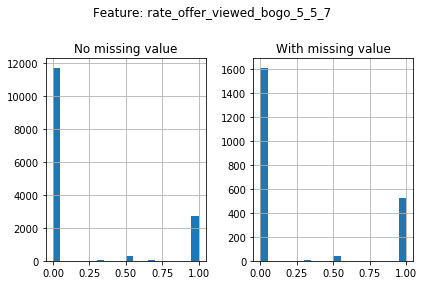

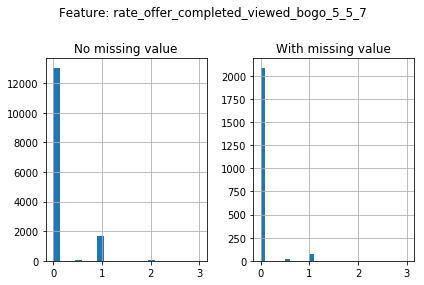

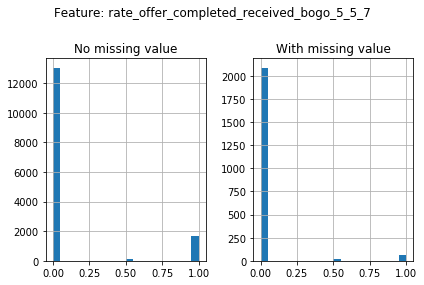

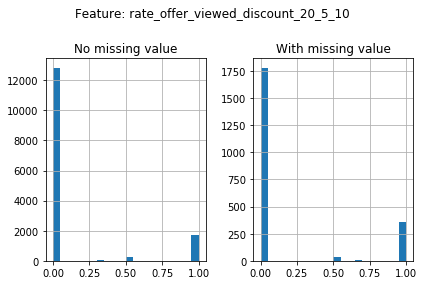

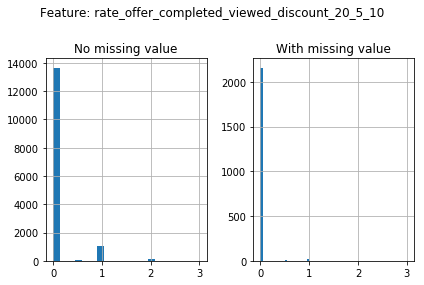

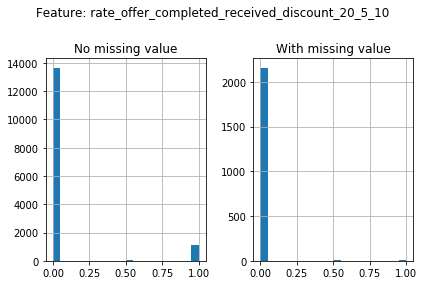

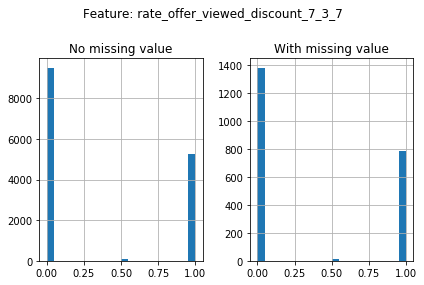

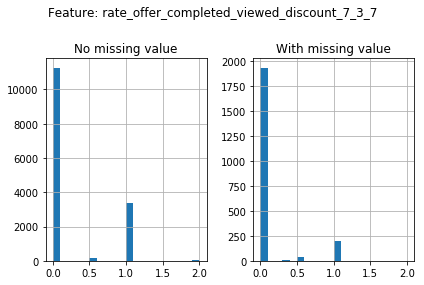

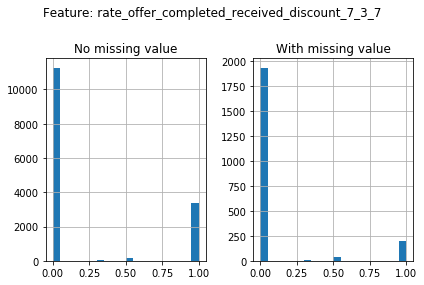

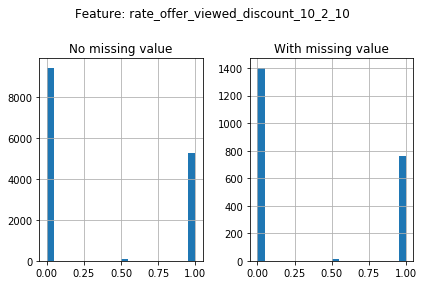

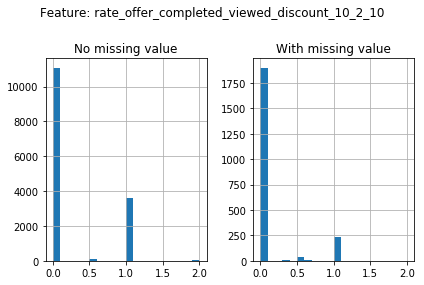

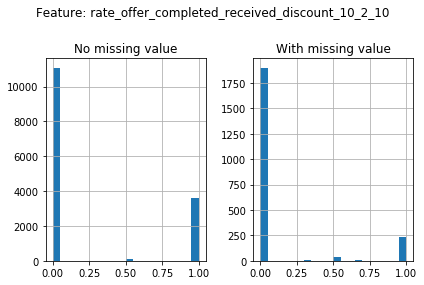

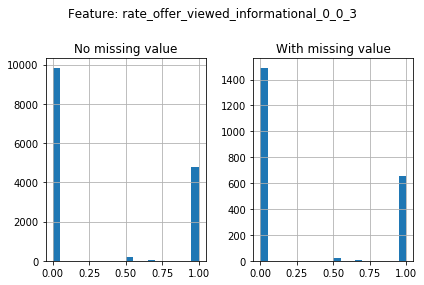

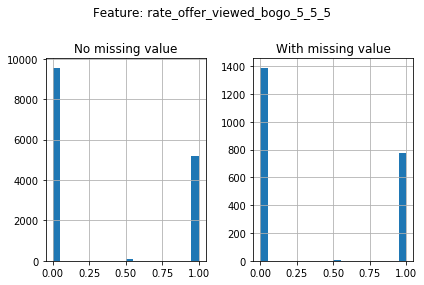

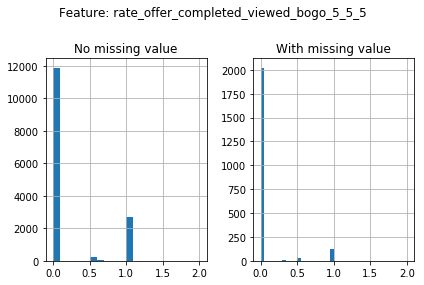

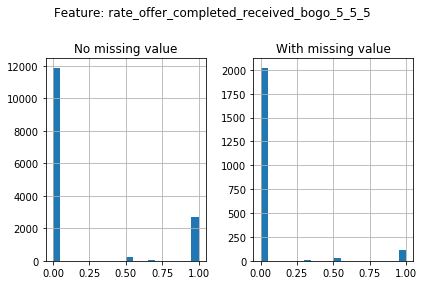

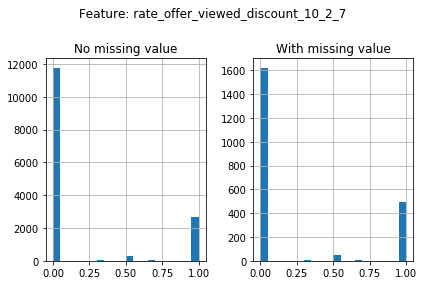

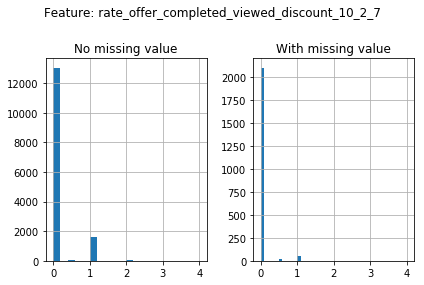

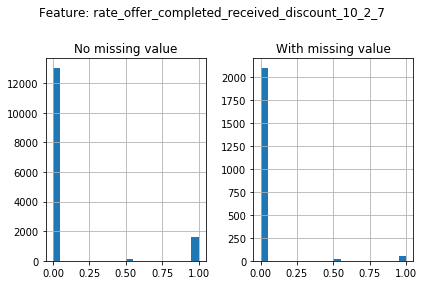

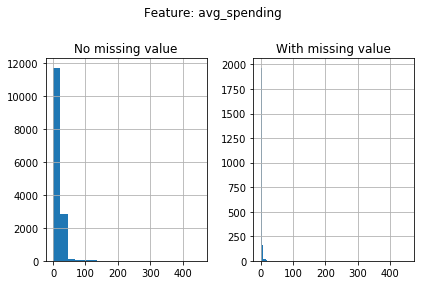

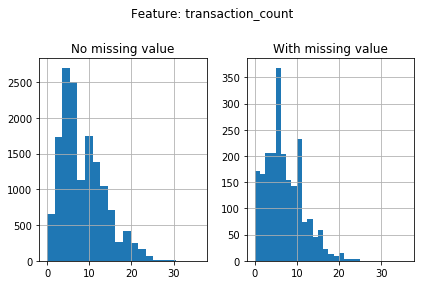

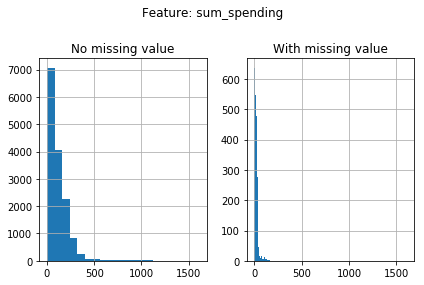

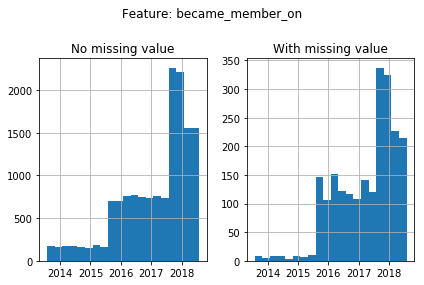

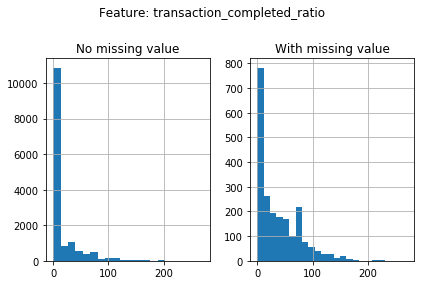

In [240]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# cols_to_compare = ['offer received_bogo_10_10_7',
#  'offer received_bogo_10_10_5',
#  'offer received_informational_0_0_4',
#  'offer received_bogo_5_5_7',
#  'offer received_discount_20_5_10',
#  'offer received_discount_7_3_7',
#  'offer received_discount_10_2_10',
#  'offer received_informational_0_0_3',
#  'offer received_bogo_5_5_5',
#  'offer received_discount_10_2_7',
#  'offer viewed_bogo_10_10_7',
#  'offer viewed_bogo_10_10_5',
#  'offer viewed_informational_0_0_4',
#  'offer viewed_bogo_5_5_7',
#  'offer viewed_discount_20_5_10',
#  'offer viewed_discount_7_3_7',
#  'offer viewed_discount_10_2_10',
#  'offer viewed_informational_0_0_3',
#  'offer viewed_bogo_5_5_5',
#  'offer viewed_discount_10_2_7',
#  'offer completed_bogo_10_10_7',
#  'offer completed_bogo_10_10_5',
#  'offer completed_bogo_5_5_7',
#  'offer completed_discount_20_5_10',
#  'offer completed_discount_7_3_7',
#  'offer completed_discount_10_2_10',
#  'offer completed_bogo_5_5_5',
#  'offer completed_discount_10_2_7',
#  'transaction_count',
#  'bogo',
#  'informational',
#  'discount',
#  'invalid',
#  ]

cols_to_compare = profile_updated.columns[profile_updated.columns.str.contains('rate')].tolist() + \
                    [ 'avg_spending', 'transaction_count', 'sum_spending', 'became_member_on', \
                     'transaction_completed_ratio']

for col in cols_to_compare:
    dist_compare_cont(col, profile_updated_)

In [202]:
def dist_compare_cont(attribute, data):
    row_null = data.isnull().sum(axis=1)
    f, (ax1,ax2) = plt.subplots(1,2, sharex=True)
    ax1 = data[row_null==0][attribute].hist(ax=ax1, bins=20)
    ax2 = data[row_null > 0][attribute].hist( ax=ax2, bins=20)
    ax1.set_title('No missing value')
    ax2.set_title('With missing value')
    f.suptitle('Feature: ' + attribute)
    f.tight_layout()
    f.subplots_adjust(top=0.8)

In [241]:
age = profile_updated[profile_updated.age < 100]
age_100 = profile_updated[profile_updated.age > 100]

In [259]:
age_100

age became_member_on gender   income  \
Unnamed: 0                                                               
68be06ca386d4c31939f3a4f0e3dd783  118       2017-02-12    NaN      NaN   
38fe809add3b4fcf9315a9694bb96ff5  118       2018-07-12    NaN      NaN   
a03223e636434f42ac4c3df47e8bac43  118       2017-08-04    NaN      NaN   
8ec6ce2a7e7949b1bf142def7d0e0586  118       2017-09-25    NaN      NaN   
68617ca6246f4fbc85e91a2a49552598  118       2017-10-02    NaN      NaN   
8974fc5686fe429db53ddde067b88302  118       2016-11-22    NaN      NaN   
c4863c7985cf408faee930f111475da3  118       2017-08-24    NaN      NaN   
148adfcaa27d485b82f323aaaad036bd  118       2015-09-19    NaN      NaN   
744d603ef08c4f33af5a61c8c7628d1c  118       2017-08-01    NaN      NaN   
2b826eba31074a059d63b0ae8f50b7d5  118       2017-09-07    NaN      NaN   
65aba5c617294649aeb624da249e1ee5  118       2017-03-30    NaN      NaN   
4beeb3ed64dd4898b0edf2f6b67426d3  118       2016-07-07    NaN      NaN   
25c906289d154b66bf579693f89481c9  118       2018-01-13    NaN      NaN   
5b8f1f0e0930464f93bb55e59b5a04e0  118       2014-11-11    NaN      NaN   
8be4463721e14d7fa600686bf8c8b2ed  118       2017-05-11    NaN      NaN   
81ac76e4f2fe4a6bb5ebdc0f19cecc56  118       2017-05-28    NaN      NaN   
020d3a52b9ce432ea5f98fc58e9bfcc4  118       2017-10-13    NaN      NaN   
4be1127413db496d8103c783ae72058b  118       2015-12-20    NaN      NaN   
9d8d6bb2fc544a9c802888971ee3e8b1  118       2017-09-18    NaN      NaN   
a89752cdfdf24779aa22faa2bc24e7c2  118       2015-09-20    NaN      NaN   
53bac762af27471eb294ff89ca1bae2c  118       2016-08-06    NaN      NaN   
488773cae11f4b71875bfccd4e3e99f2  118       2017-02-23    NaN      NaN   
182e68952b474700b171e21b85c258ac  118       2017-08-23    NaN      NaN   
5e9c83e8ab4d4e9ca83f3256d83ca756  118       2016-01-30    NaN      NaN   
c099206f76b1414db7552f163520053c  118       2015-07-30    NaN      NaN   
e6d3eebb535e44aca1323edde5c346fa  118       2017-11-25    NaN      NaN   
baba98dba43e42ae8e86cbd70725e201  118       2016-04-18    NaN      NaN   
58748c1cf9f746838c6ec62acdff28ad  118       2016-10-18    NaN      NaN   
770df32893694100afc703ea9c9df401  118       2015-09-05    NaN      NaN   
50b92ea51e2649dfbf7120d5e554e991  118       2018-01-14    NaN      NaN   
...                               ...              ...    ...      ...   
56a0b671fa0347beb8b60011a15800aa  118       2017-10-07    NaN      NaN   
060c0b9181674d03aa181b75353b9422  118       2017-09-10    NaN      NaN   
587453e2944b4c6699519a217bf87de6  118       2016-12-11    NaN      NaN   
d6063a30185b4e60b58a445bacec5f56  118       2018-06-26    NaN      NaN   
a225189b10a141d5bb1ff0a05265da4c  118       2015-11-10    NaN      NaN   
4342cb3414534aaca96ac523edc82654  118       2017-02-28    NaN      NaN   
d1477e69857f42d18929f6f29b3be427  118       2015-08-15    NaN      NaN   
6c0df9b1d3b8401c8098c7c7f9977d89  118       2014-06-05    NaN      NaN   
7b3b8100d6444861803cefc6b13c9a43  118       2017-11-23    NaN      NaN   
3a02d786fbc143edb257665ad54c5c09  118       2015-07-29    NaN      NaN   
8f4364144e0548f885b390f28aabe2b8  118       2017-12-12    NaN      NaN   
1593d617fac246ef8e50dbb0ffd77f5f  101       2017-11-27      F  82000.0   
1efb4a45f5c34db4b07ebd19bdfc1b41  118       2016-06-07    NaN      NaN   
113f3f07ac2b4f8b940d6136233ae3ee  118       2017-01-29    NaN      NaN   
b6f74fc8e1664cfb9b44834dd9f7cf48  118       2018-03-07    NaN      NaN   
123ec648e228460589182607c0db4dd5  118       2015-08-04    NaN      NaN   
09f61d1d6e05402ca923d614dda52d57  118       2017-07-29    NaN      NaN   
7b32b3085ad540a58482c091b1dca914  118       2017-10-21    NaN      NaN   
54ed2d25754a486fba36eb5c7541203a  118       2016-02-09    NaN      NaN   
e6843a4996574eb693ab864ecc406d56  118       2017-09-13    NaN      NaN   
ba12d53863b3456f930ac62e2503fe48  118       2017-07-28    NaN      NaN   
5ca2620962114246ab218fc648eb3934  118 

In [247]:
age.avg_spending.describe()

count    14808.000000
mean        14.904932
std         16.519459
min          0.000000
25%          3.699423
50%         13.976750
75%         21.298364
max        451.470000
Name: avg_spending, dtype: float64

In [246]:
age_100.avg_spending.describe()

count    2180.000000
mean        2.684460
std         3.422491
min         0.000000
25%         1.550988
50%         2.220000
75%         3.023571
max        82.070000
Name: avg_spending, dtype: float64

In [262]:
profile_id = '653d8f383fab43d4a93b10b02bd67266'#'38fe809add3b4fcf9315a9694bb96ff5'
age_100.loc[profile_id,'transaction_count']

7.0

In [263]:
transcript_all[transcript_all.person == profile_id]

event                            person  time  \
10759   offer received  653d8f383fab43d4a93b10b02bd67266     0   
27841     offer viewed  653d8f383fab43d4a93b10b02bd67266    36   
69315      transaction  653d8f383fab43d4a93b10b02bd67266   168   
88882      transaction  653d8f383fab43d4a93b10b02bd67266   222   
103830     transaction  653d8f383fab43d4a93b10b02bd67266   288   
123197  offer received  653d8f383fab43d4a93b10b02bd67266   336   
135217    offer viewed  653d8f383fab43d4a93b10b02bd67266   354   
161446  offer received  653d8f383fab43d4a93b10b02bd67266   408   
167612    offer viewed  653d8f383fab43d4a93b10b02bd67266   408   
187124     transaction  653d8f383fab43d4a93b10b02bd67266   450   
213959  offer received  653d8f383fab43d4a93b10b02bd67266   504   
221895    offer viewed  653d8f383fab43d4a93b10b02bd67266   510   
221896     transaction  653d8f383fab43d4a93b10b02bd67266   510   
255948  offer received  653d8f383fab43d4a93b10b02bd67266   576   
265616     transaction  653d8f383fab43d4a93b10b02bd67266   582   
304353     transaction  653d8f383fab43d4a93b10b02bd67266   702   

                                                   value  \
10759   {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}   
27841   {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}   
69315                                   {'amount': 0.39}   
88882                                   {'amount': 0.76}   
103830                                  {'amount': 0.68}   
123197  {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}   
135217  {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}   
161446  {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}   
167612  {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}   
187124                                  {'amount': 2.31}   
213959  {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}   
221895  {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}   
221896                                  {'amount': 3.42}   
255948  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}   
265616                                  {'amount': 3.34}   
304353                                   {'amount': 4.7}   

                                offer_id  amount  age became_member_on gender  \
10759   fafdcd668e3743c1bb461111dcafc2a4     NaN  118       2017-09-01   None   
27841   fafdcd668e3743c1bb461111dcafc2a4     NaN  118       2017-09-01   None   
69315                                NaN    0.39  118       2017-09-01   None   
88882                                NaN    0.76  118       2017-09-01   None   
103830                               NaN    0.68  118       2017-09-01   None   
123197  2298d6c36e964ae4a3e7e9706d1fb8c2     NaN  118       2017-09-01   None   
135217  2298d6c36e964ae4a3e7e9706d1fb8c2     NaN  118       2017-09-01   None   
161446  2298d6c36e964ae4a3e7e9706d1fb8c2     NaN  118       2017-09-01   None   
167612  2298d6c36e964ae4a3e7e9706d1fb8c2     NaN  118       2017-09-01   None   
187124                               NaN    2.31  118       2017-09-01   None   
213959  2298d6c36e964ae4a3e7e9706d1fb8c2     NaN  118       2017-09-01   None   
221895  2298d6c36e964ae4a3e7e9706d1fb8c2     NaN  118       2017-09-01   None   
221896                               NaN    3.42  118       2017-09-01   None   
255948  2906b810c7d4411798c6938adc9daaa5     NaN  118       2017-09-01   None   
265616                               NaN    3.34  118       2017-09-01   None   
304353                               NaN    4.70  118       2017-09-01   None   

        income  difficulty  duration offer_type  reward              name  \
10759      NaN        10.0      10.0   discount     2.0  discount_10_2_10   
27841      NaN        10.0      10.0   discount     2.0  discount_10_2_10   
69315      NaN         NaN       NaN        NaN     NaN               NaN   
88882      NaN         NaN       NaN        NaN     NaN               NaN   
103830     NaN         NaN       NaN        NaN     NaN               NaN   
123197     NaN         7.0       

In [ ]:
cols_to_compare = [ 'avg_spending'
 ]

for col in cols_to_compare:
    dist_compare_cont(col, profile_updated_)

Notes:
- There are no different between row data with no missing value and missing value. The row with missing value will be removed

In [50]:
# sparate data with age < 100 and age >= 100, missing value on gender and income

#main profile
profile_updated_main = profile_updated_[profile_updated_.age < 100]

#special profile
profile_updated_sp = profile_updated_[profile_updated_.age >= 100]
profile_updated_sp = profile_updated_sp.drop(['gender', 'income', 'age'], axis=1)


## 1.3. Assess profile with valid and invalid offer completed transcript
```
Profile_valid = people who was influenced by offering (value=0
Profile_invalid = people who was not influenced by offering (value > 0)
```

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


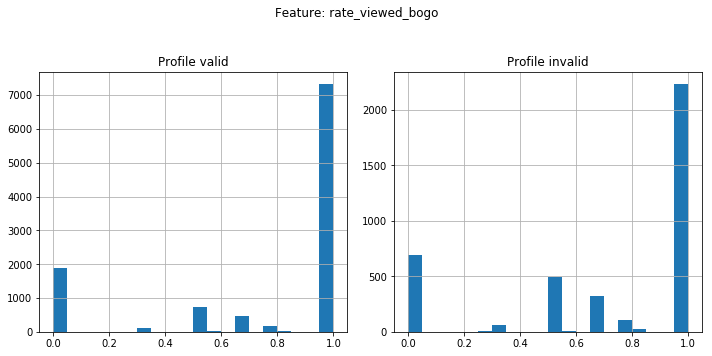

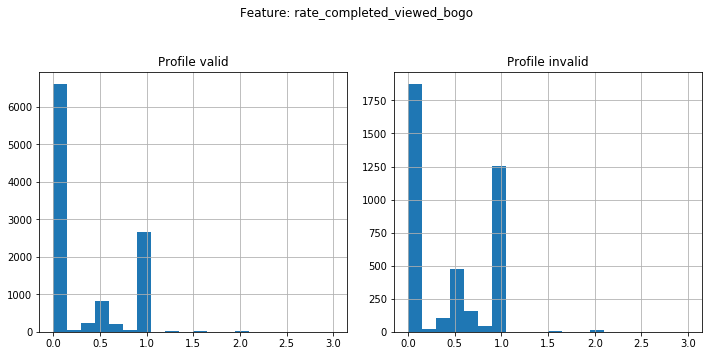

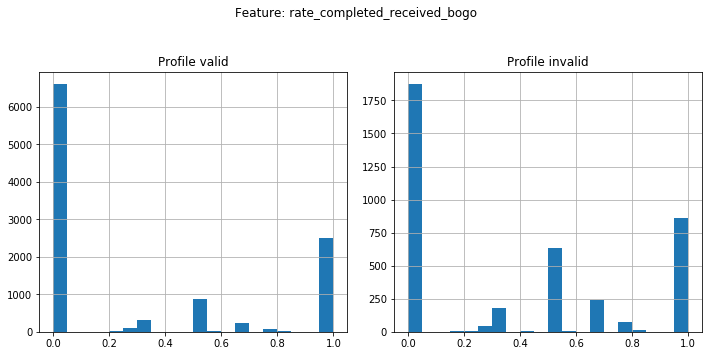

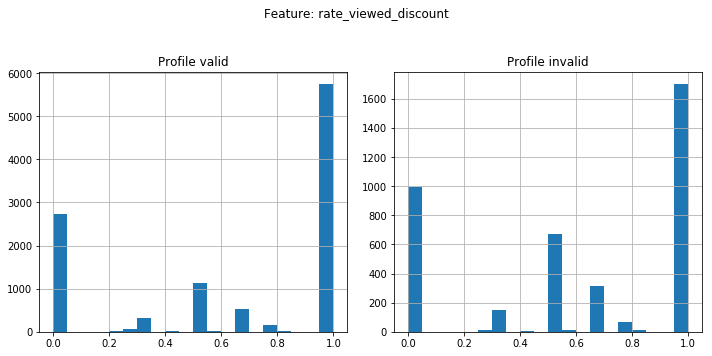

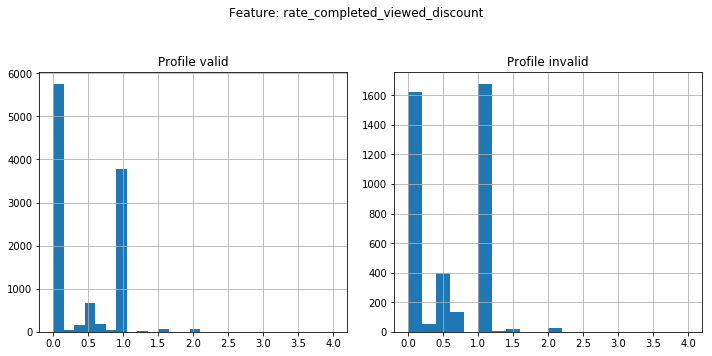

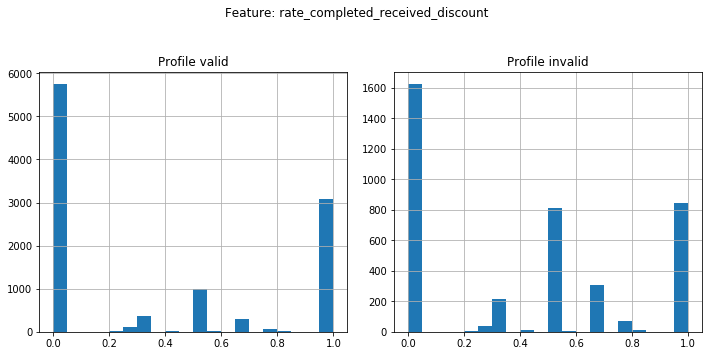

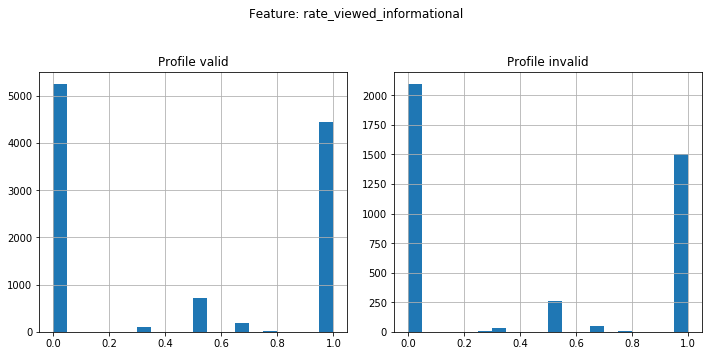

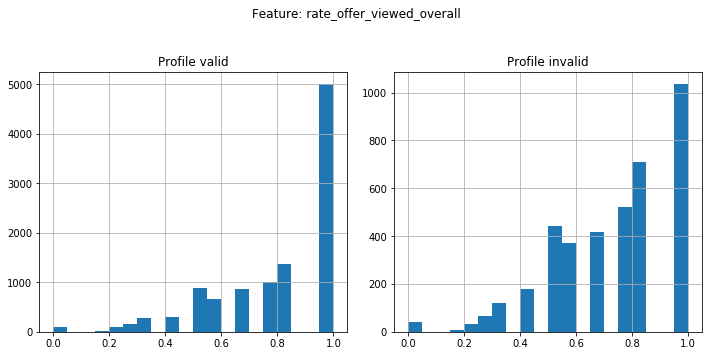

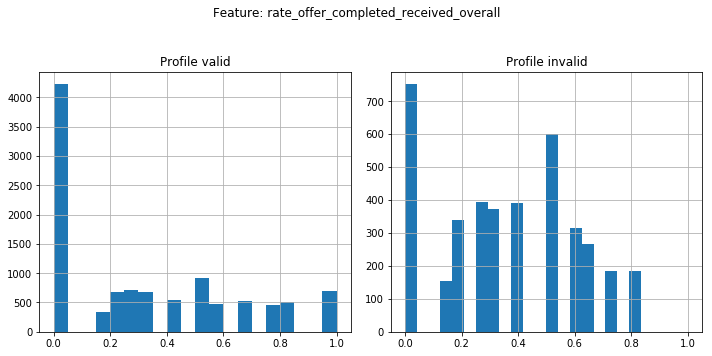

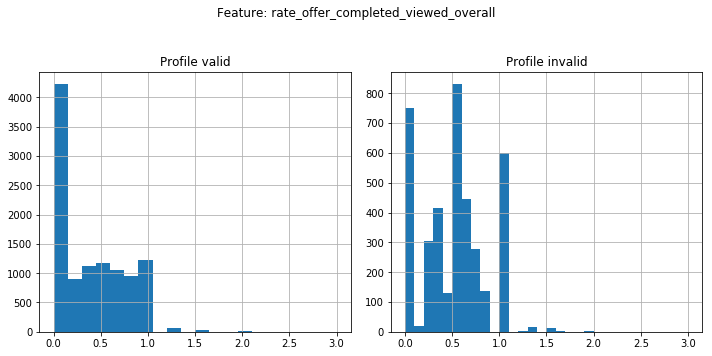

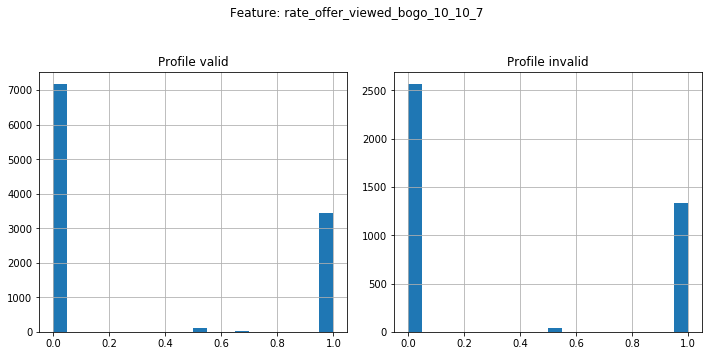

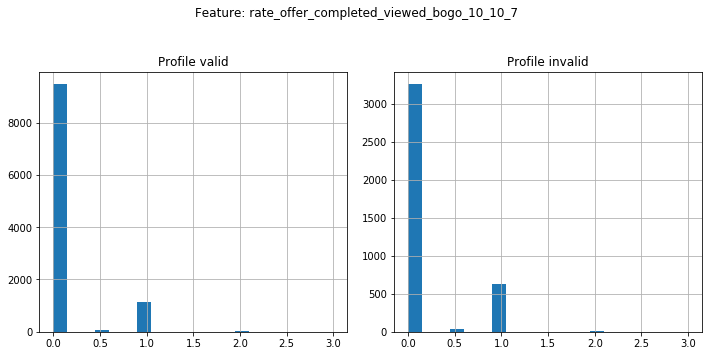

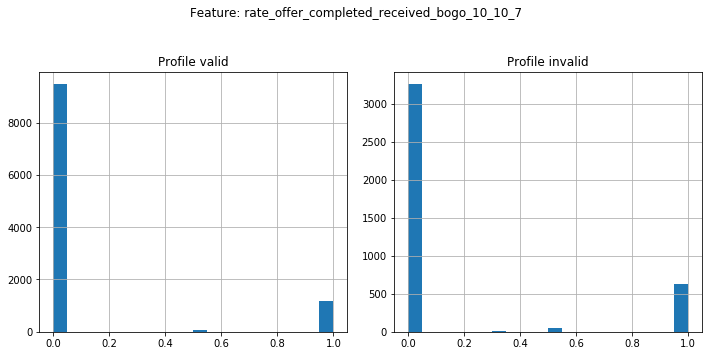

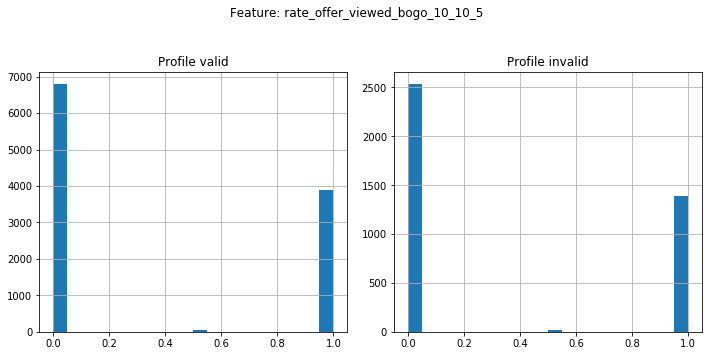

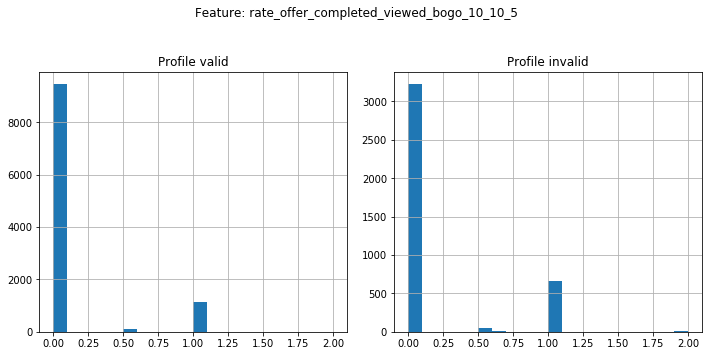

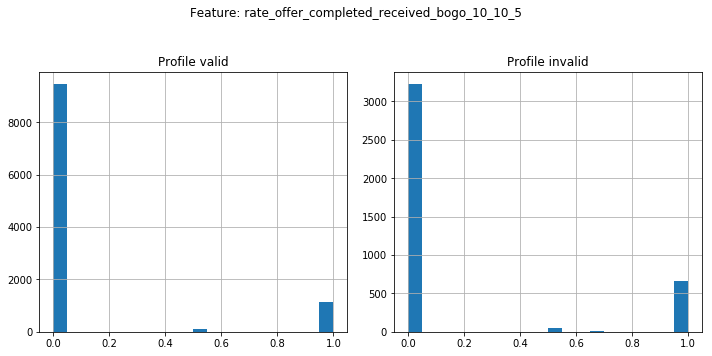

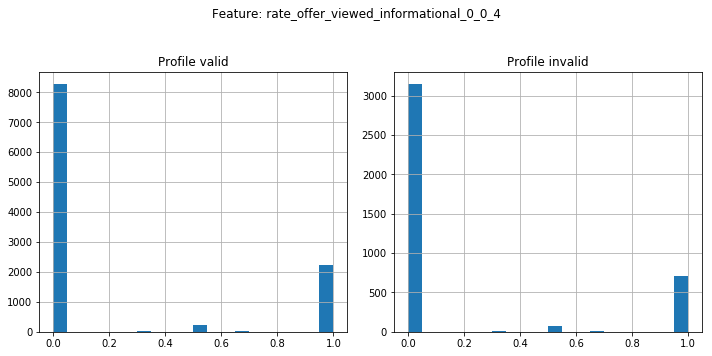

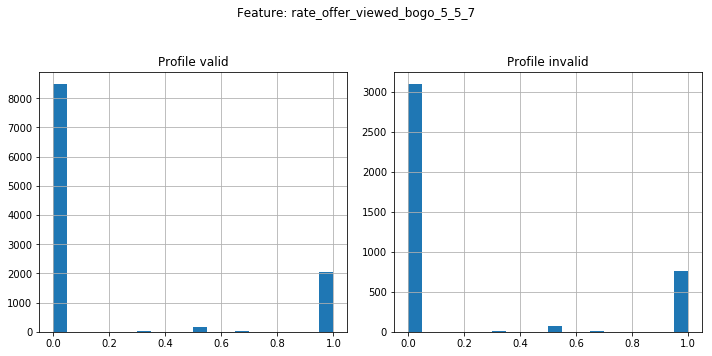

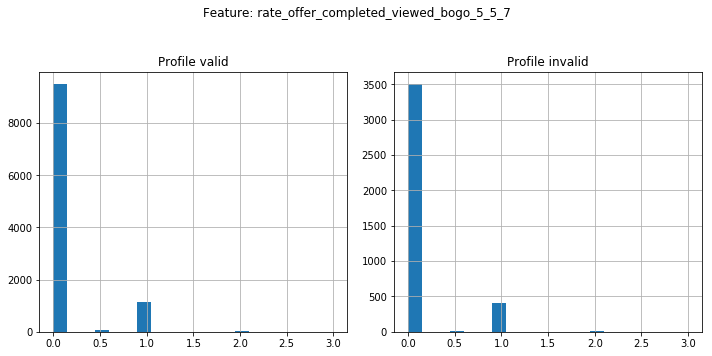

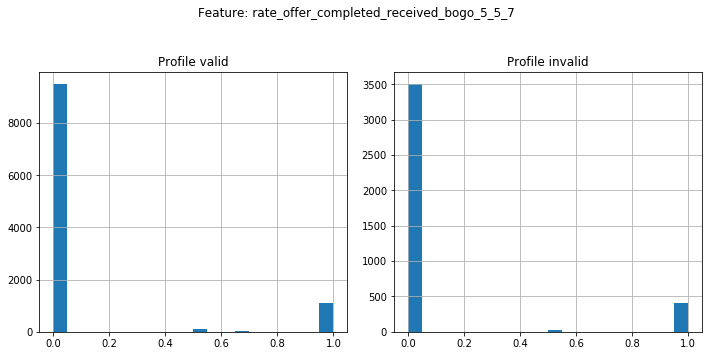

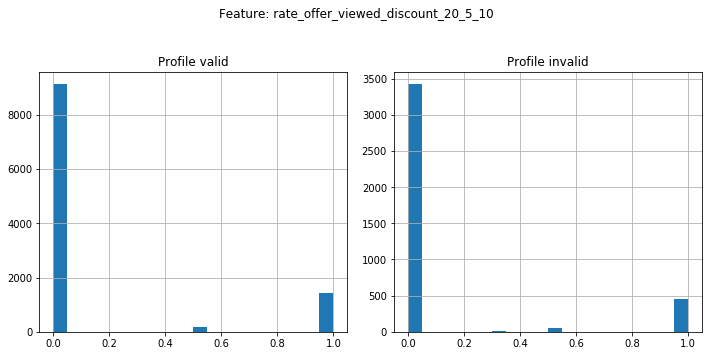

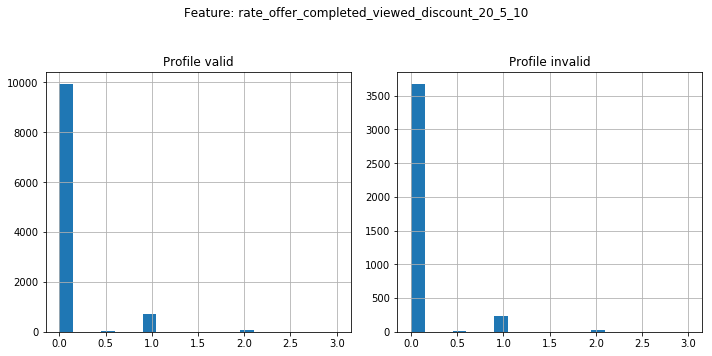

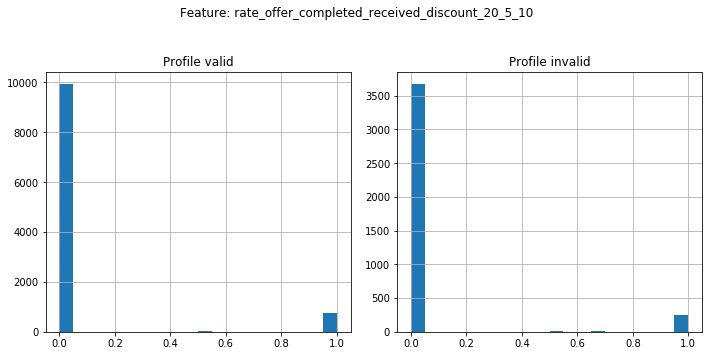

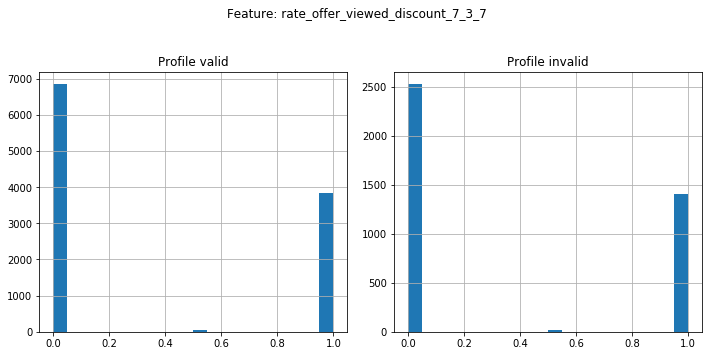

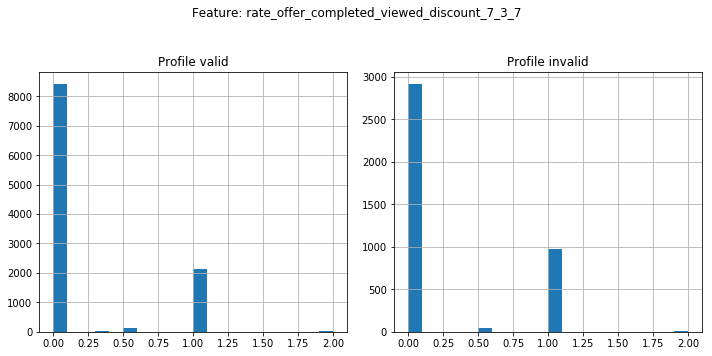

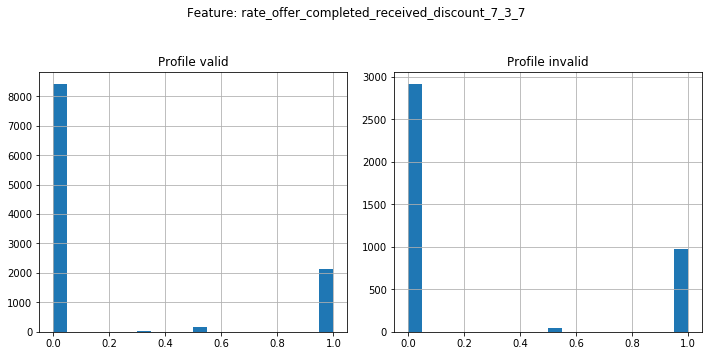

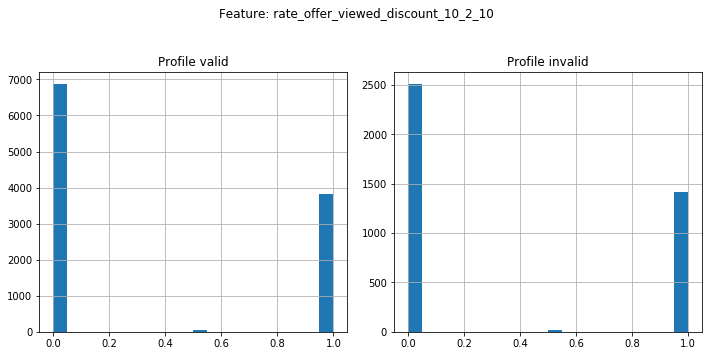

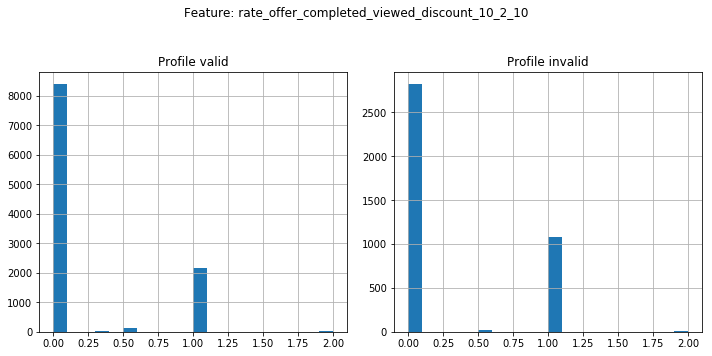

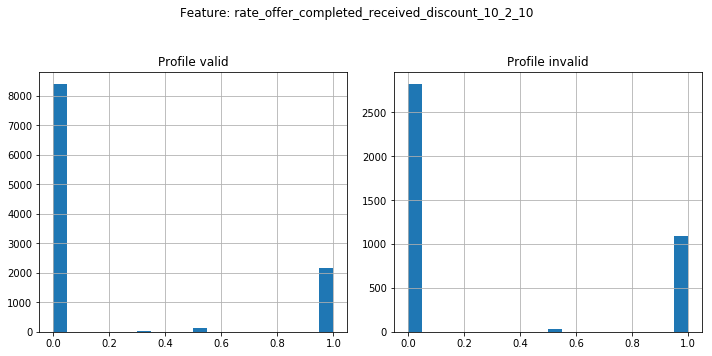

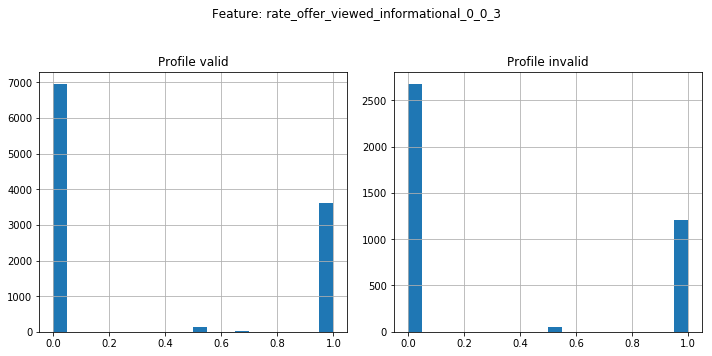

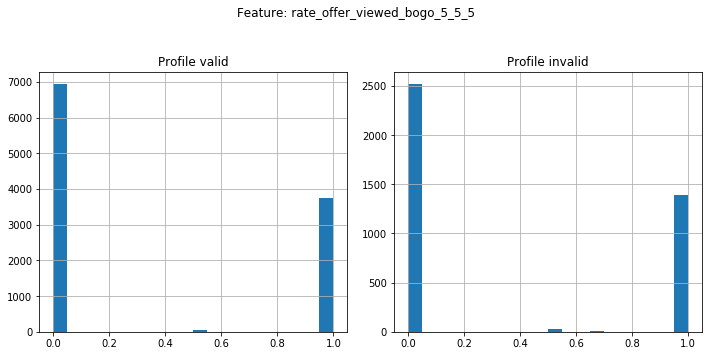

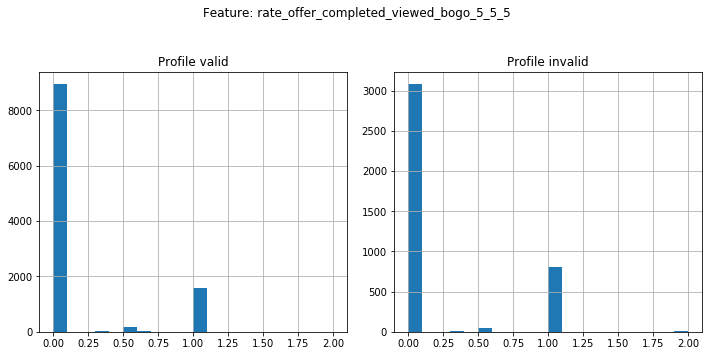

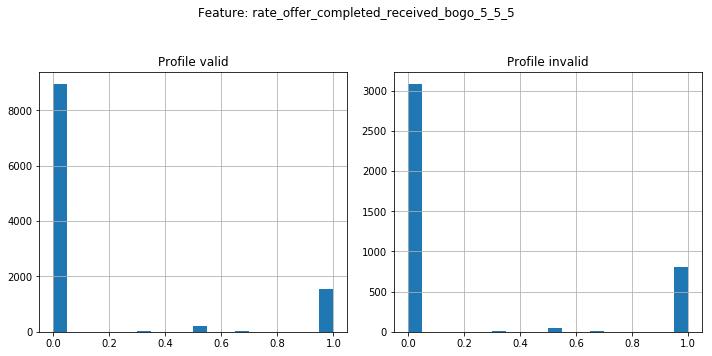

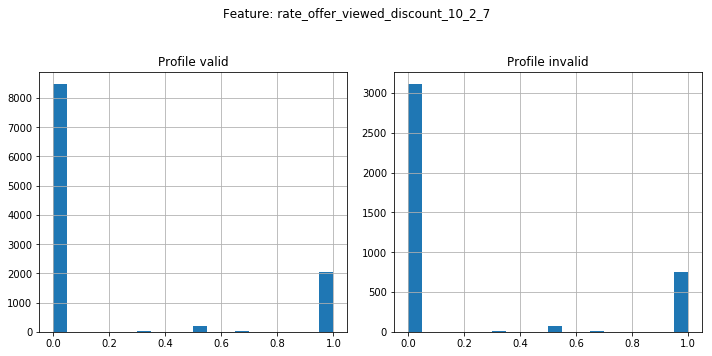

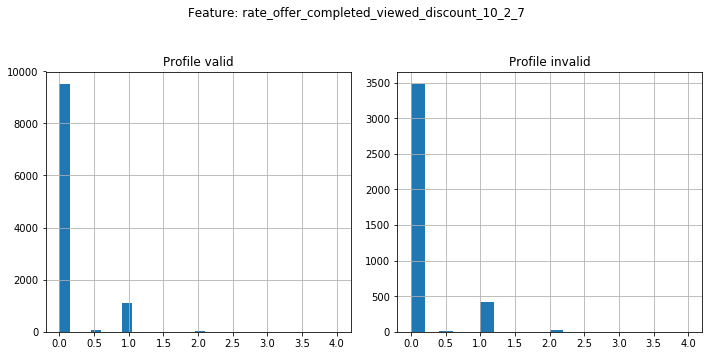

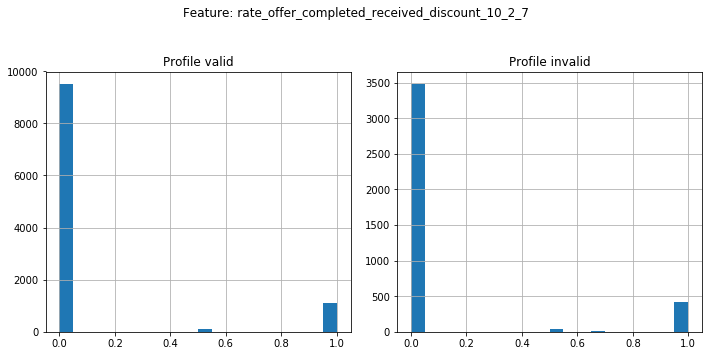

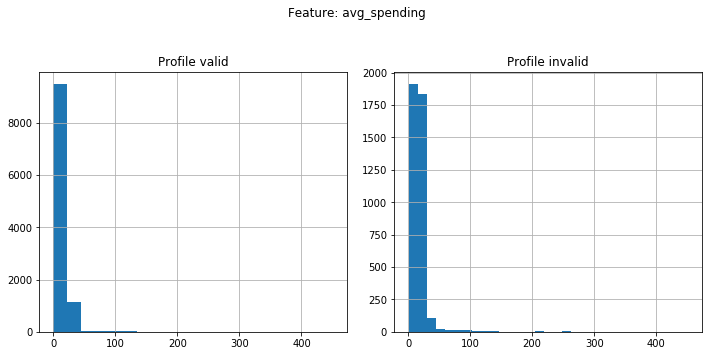

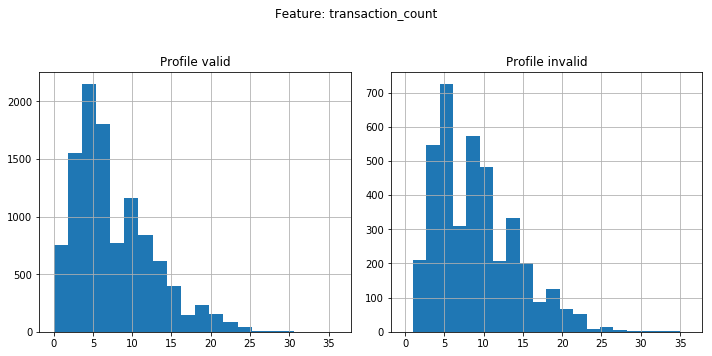

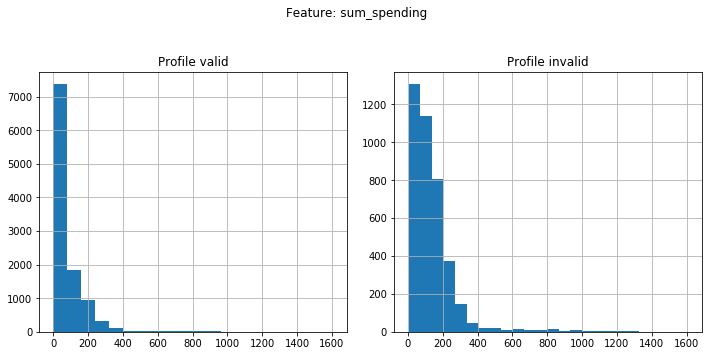

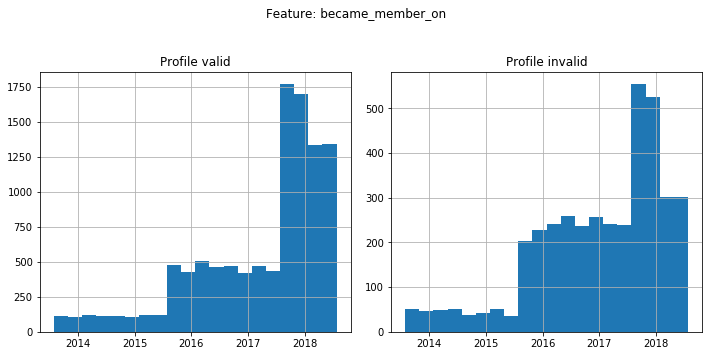

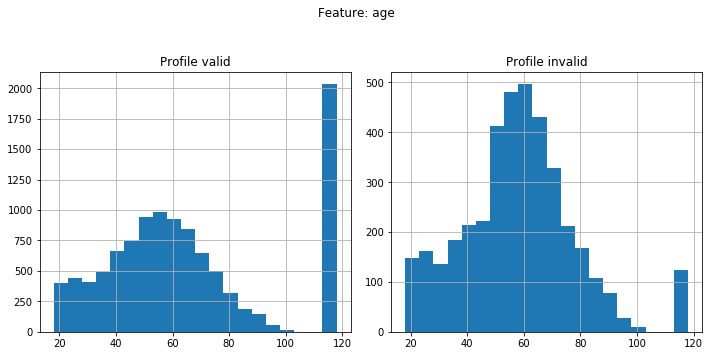

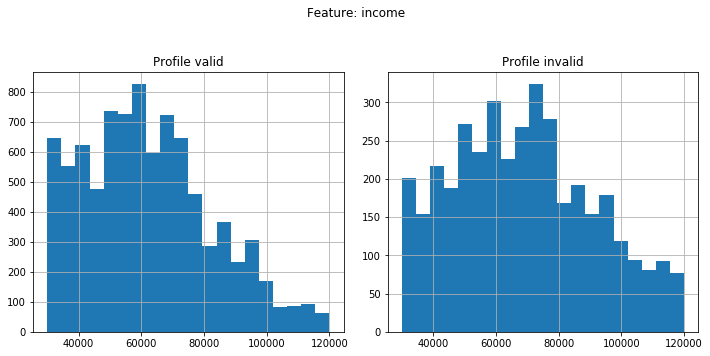

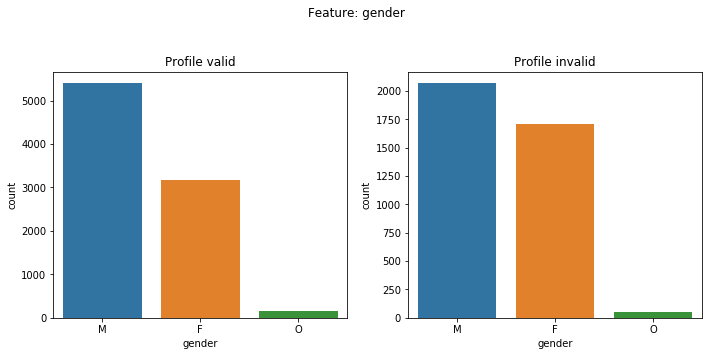

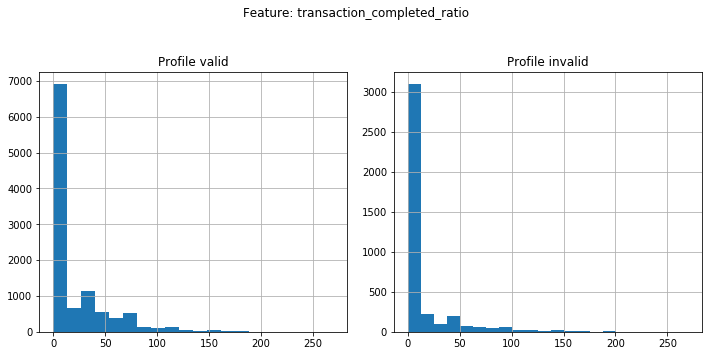

In [239]:
profile_invalid = profile_updated[profile_updated.invalid == 1 ]
profile_valid = profile_updated[profile_updated.invalid == 0]

cols_to_compare = profile_updated.columns[profile_updated.columns.str.contains('rate')].tolist() + \
                    [ 'avg_spending', 'transaction_count', 'sum_spending', 'became_member_on', 'age', 'income','gender',\
                     'transaction_completed_ratio']

for col in cols_to_compare:
    f, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5), sharex=True)
    if col == 'gender':
        ax1 = sns.countplot(col, data=profile_valid, ax=ax1, order=['M','F', 'O'])
        ax2 = sns.countplot(col, data=profile_invalid, ax=ax2, order=['M','F', 'O'])
    else:
        ax1 = profile_valid[col].hist(ax=ax1, bins=20)
        ax2 = profile_invalid[col].hist( ax=ax2, bins=20)
    ax1.set_title('Profile valid')
    ax2.set_title('Profile invalid')
    f.suptitle('Feature: ' + col)
    f.tight_layout()
    f.subplots_adjust(top=0.8)

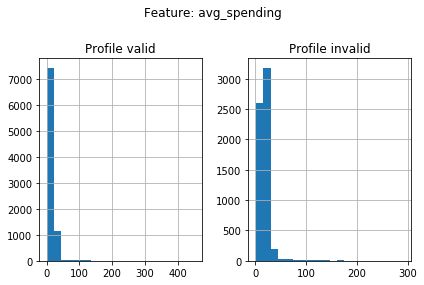

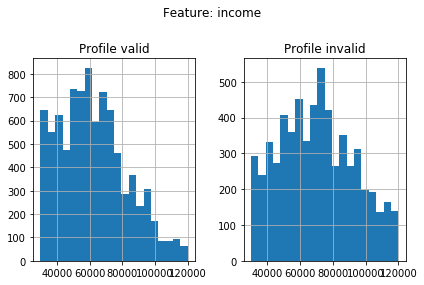

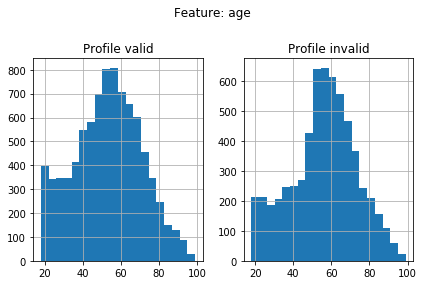

In [48]:
cols_to_compare = [ 'avg_spending', 'income', 'age']

for col in cols_to_compare:
    f, (ax1,ax2) = plt.subplots(1,2)
    ax1 = profile_valid[col].hist(ax=ax1, bins=20)
    ax2 = profile_invalid[col].hist( ax=ax2, bins=20)
    ax1.set_title('Profile valid')
    ax2.set_title('Profile invalid')
    f.suptitle('Feature: ' + col)
    f.tight_layout()
    f.subplots_adjust(top=0.8)

Notes :
- Profile invalid :
    - Gender : Male & Female is balance, the proportion of female is larger than profile_valid
    - Spending : generally more spending than profile_valid
    - Income : generally higher income than profile_valid


 ## 1.3 Re-Encode became_member_on features

In [51]:
import datetime

for df in [profile_updated_main, profile_updated_sp]:
    df.loc[:,'member_days_since'] = (datetime.datetime(2018,12,31) - df.became_member_on).dt.days 
    df.loc[:,'member_year'] = df.became_member_on.dt.year.astype(str)

profile_updated_main = profile_updated_main.drop('became_member_on', axis=1)
profile_updated_sp = profile_updated_sp.drop('became_member_on', axis=1)

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\user\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [52]:
profile_updated_main.head()

age gender    income  \
Unnamed: 0                                               
0610b486422d4921ae7d2bf64640c50b   55      F  112000.0   
78afa995795e4d85b5d9ceeca43f5fef   75      F  100000.0   
e2127556f4f64592b11af22de27a7932   68      M   70000.0   
389bc3fa690240e798340f5a15918d5c   65      M   53000.0   
2eeac8d8feae4a8cad5a6af0499a211d   58      M   51000.0   

                                  offer received_bogo_10_10_7  \
Unnamed: 0                                                      
0610b486422d4921ae7d2bf64640c50b                          0.0   
78afa995795e4d85b5d9ceeca43f5fef                          1.0   
e2127556f4f64592b11af22de27a7932                          0.0   
389bc3fa690240e798340f5a15918d5c                          0.0   
2eeac8d8feae4a8cad5a6af0499a211d                          0.0   

                                  offer received_bogo_10_10_5  \
Unnamed: 0                                                      
0610b486422d4921ae7d2bf64640c50b                          0.0   
78afa995795e4d85b5d9ceeca43f5fef                          0.0   
e2127556f4f64592b11af22de27a7932                          0.0   
389bc3fa690240e798340f5a15918d5c                          0.0   
2eeac8d8feae4a8cad5a6af0499a211d                          0.0   

                                  offer received_informational_0_0_4  \
Unnamed: 0                                                             
0610b486422d4921ae7d2bf64640c50b                                 1.0   
78afa995795e4d85b5d9ceeca43f5fef                                 0.0   
e2127556f4f64592b11af22de27a7932                                 1.0   
389bc3fa690240e798340f5a15918d5c                                 0.0   
2eeac8d8feae4a8cad5a6af0499a211d                                 1.0   

                                  offer received_bogo_5_5_7  \
Unnamed: 0                                                    
0610b486422d4921ae7d2bf64640c50b                        1.0   
78afa995795e4d85b5d9ceeca43f5fef                        1.0   
e2127556f4f64592b11af22de27a7932                        1.0   
389bc3fa690240e798340f5a15918d5c                        2.0   
2eeac8d8feae4a8cad5a6af0499a211d                        0.0   

                                  offer received_discount_20_5_10  \
Unnamed: 0                                                          
0610b486422d4921ae7d2bf64640c50b                              0.0   
78afa995795e4d85b5d9ceeca43f5fef                              0.0   
e2127556f4f64592b11af22de27a7932                              0.0   
389bc3fa690240e798340f5a15918d5c                              0.0   
2eeac8d8feae4a8cad5a6af0499a211d                              0.0   

                                  offer received_discount_7_3_7  \
Unnamed: 0                                                        
0610b486422d4921ae7d2bf64640c50b                            0.0   
78afa995795e4d85b5d9ceeca43f5fef                            0.0   
e2127556f4f64592b11af22de27a7932                            0.0   
389bc3fa690240e798340f5a15918d5c                            0.0   
2eeac8d8feae4a8cad5a6af0499a211d                            1.0   

                                  offer received_discount_10_2_10  \
Unnamed: 0                                                          
0610b486422d4921ae7d2bf64640c50b                              0.0   
78afa995795e4d85b5d9ceeca43f5fef                              0.0   
e2127556f4f64592b11af22de27a7932                              1.0   
389bc3fa690240e798340f5a15918d5c                              1.0   
2eeac8d8feae4a8cad5a6af0499a211d                              1.0   

                                     ...       \
Unnamed: 0                           ...        
0610b486422d4921ae7d2bf64640c50b     ...        
78afa995795e4d85b5d9ceeca43f5fef     ...        
e2127556f4f64592b11af22de27a7932     ...        
389bc3fa690240e798340f5a15918d5c     ...        
2eeac8d8feae4a8cad5a6af0499a211d    

In [53]:
profile_updated_sp.head()

offer received_bogo_10_10_7  \
Unnamed: 0                                                      
68be06ca386d4c31939f3a4f0e3dd783                          0.0   
38fe809add3b4fcf9315a9694bb96ff5                          0.0   
a03223e636434f42ac4c3df47e8bac43                          0.0   
8ec6ce2a7e7949b1bf142def7d0e0586                          0.0   
68617ca6246f4fbc85e91a2a49552598                          1.0   

                                  offer received_bogo_10_10_5  \
Unnamed: 0                                                      
68be06ca386d4c31939f3a4f0e3dd783                          0.0   
38fe809add3b4fcf9315a9694bb96ff5                          0.0   
a03223e636434f42ac4c3df47e8bac43                          0.0   
8ec6ce2a7e7949b1bf142def7d0e0586                          1.0   
68617ca6246f4fbc85e91a2a49552598                          1.0   

                                  offer received_informational_0_0_4  \
Unnamed: 0                                                             
68be06ca386d4c31939f3a4f0e3dd783                                 0.0   
38fe809add3b4fcf9315a9694bb96ff5                                 0.0   
a03223e636434f42ac4c3df47e8bac43                                 1.0   
8ec6ce2a7e7949b1bf142def7d0e0586                                 1.0   
68617ca6246f4fbc85e91a2a49552598                                 0.0   

                                  offer received_bogo_5_5_7  \
Unnamed: 0                                                    
68be06ca386d4c31939f3a4f0e3dd783                        0.0   
38fe809add3b4fcf9315a9694bb96ff5                        1.0   
a03223e636434f42ac4c3df47e8bac43                        0.0   
8ec6ce2a7e7949b1bf142def7d0e0586                        0.0   
68617ca6246f4fbc85e91a2a49552598                        1.0   

                                  offer received_discount_20_5_10  \
Unnamed: 0                                                          
68be06ca386d4c31939f3a4f0e3dd783                              1.0   
38fe809add3b4fcf9315a9694bb96ff5                              0.0   
a03223e636434f42ac4c3df47e8bac43                              3.0   
8ec6ce2a7e7949b1bf142def7d0e0586                              0.0   
68617ca6246f4fbc85e91a2a49552598                              0.0   

                                  offer received_discount_7_3_7  \
Unnamed: 0                                                        
68be06ca386d4c31939f3a4f0e3dd783                            1.0   
38fe809add3b4fcf9315a9694bb96ff5                            0.0   
a03223e636434f42ac4c3df47e8bac43                            0.0   
8ec6ce2a7e7949b1bf142def7d0e0586                            0.0   
68617ca6246f4fbc85e91a2a49552598                            1.0   

                                  offer received_discount_10_2_10  \
Unnamed: 0                                                          
68be06ca386d4c31939f3a4f0e3dd783                              2.0   
38fe809add3b4fcf9315a9694bb96ff5                              0.0   
a03223e636434f42ac4c3df47e8bac43                              0.0   
8ec6ce2a7e7949b1bf142def7d0e0586                              2.0   
68617ca6246f4fbc85e91a2a49552598                              0.0   

                                  offer received_informational_0_0_3  \
Unnamed: 0                                                             
68be06ca386d4c31939f3a4f0e3dd783                                 0.0   
38fe809add3b4fcf9315a9694bb96ff5                                 1.0   
a03223e636434f42ac4c3df47e8bac43                                 1.0   
8ec6ce2a7e7949b1bf142def7d0e0586                                 0.0   
68617ca6246f4fbc85e91a2a49552598                                 0.0   

                                  offer received_bogo_5_5_5  \
Unnamed: 0                                                    
68be06ca386d4c31939f3a4f0e3dd783                        0.0   
38fe809add3b4fcf9315a9694bb96ff5           

 ## 1.4 Re-Encode Categorical Features

In [54]:
# one hot gender columns

profile_onehot_main = pd.get_dummies(profile_updated_main)

profile_onehot_sp = pd.get_dummies(profile_updated_sp)


In [55]:
profile_onehot_sp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2192 entries, 68be06ca386d4c31939f3a4f0e3dd783 to c02b10e8752c4d8e9b73f918558531f7
Data columns (total 90 columns):
offer received_bogo_10_10_7                       2192 non-null float64
offer received_bogo_10_10_5                       2192 non-null float64
offer received_informational_0_0_4                2192 non-null float64
offer received_bogo_5_5_7                         2192 non-null float64
offer received_discount_20_5_10                   2192 non-null float64
offer received_discount_7_3_7                     2192 non-null float64
offer received_discount_10_2_10                   2192 non-null float64
offer received_informational_0_0_3                2192 non-null float64
offer received_bogo_5_5_5                         2192 non-null float64
offer received_discount_10_2_7                    2192 non-null float64
offer viewed_bogo_10_10_7                         2192 non-null float64
offer viewed_bogo_10_10_5                      

## 1.4 Create a feature preprocessing function

In [4]:
import datetime

def add_invalid_feature(profile_updated_df, transcript_merge_df):
    profile_updated_df = profile_updated_df.copy()
    
    person_invalid = transcript_merge_df[transcript_merge_df.invalid == 1].person.value_counts()
    # create new feature 'invalid', how many invalid transaction made by customer (transaction that not influenced by offer)
    profile_updated_df['invalid'] = person_invalid
    profile_updated_df['invalid'] = profile_updated_df['invalid'].fillna(0)
    
    return profile_updated_df

def add_feature_rate_portfolio_type(profile_updated_df):
    """ 
    Create features
        - Total Count of the offer received, reviewed, completed for each type of portfolio (bogo, discount, and informational)
        - Rates for each offering type (bogo/discount/informational) : 
            - rate_review = total reviewed / total received
            - rate_completed_reviewed = total completed / total reviewed
            - rate_completed_received = tatal completed / total received

    """
    profile_updated = profile_updated_df.copy()

    for offer in ['bogo', 'discount', 'informational']:
        received_cols = profile_updated.columns[(profile_updated.columns.str.contains('received_' + offer)) & \
                                                (~profile_updated.columns.str.contains('rate' ))].tolist()
        profile_updated[offer +'_received'] = profile_updated[received_cols].sum(axis=1).fillna(0)

        viewed_cols = profile_updated.columns[(profile_updated.columns.str.contains('viewed_' + offer)) & \
                                                (~profile_updated.columns.str.contains('rate'))].tolist()
        profile_updated[offer +'_viewed'] = profile_updated[viewed_cols].sum(axis=1).fillna(0)

        profile_updated['rate_viewed_' + offer] = (profile_updated[offer +'_viewed'] / profile_updated[offer +'_received']).fillna(0)

        if offer != 'informational':
            completed_cols = profile_updated.columns[(profile_updated.columns.str.contains('completed_' + offer)) & \
                                                (~profile_updated.columns.str.contains('rate' ))].tolist()
            profile_updated[offer +'_completed'] = profile_updated[completed_cols].sum(axis=1).fillna(0)

            profile_updated['rate_completed_viewed_' + offer] = \
                        (profile_updated[offer +'_completed'] /profile_updated[offer +'_viewed']).fillna(0)
            profile_updated['rate_completed_received_' + offer] = \
                        (profile_updated[offer +'_completed'] / profile_updated[offer +'_received']).fillna(0)

    return profile_updated

def add_feature_rate_overall(profile_updated_df):

    """ 
    Create Feature :
    - Total count of received, viewed, completed
    - Overall Rates : 
            - rate_review = total reviewed / total received
            - rate_completed_reviewed = total completed / total reviewed
            - rate_completed_received = tatal completed / total received

    """
    profile_updated = profile_updated_df.copy()
    
    profile_updated['offer_received_total'] = profile_updated.bogo_received + profile_updated.discount_received + \
                                            profile_updated.informational_received

    profile_updated['offer_viewed_total'] = profile_updated.bogo_viewed + profile_updated.discount_viewed + \
                                            profile_updated.informational_viewed

    profile_updated['offer_completed_total'] = profile_updated.bogo_completed + profile_updated.discount_completed 

    profile_updated['rate_offer_viewed_overall'] = \
            (profile_updated['offer_viewed_total'] / profile_updated['offer_received_total']).fillna(0)

    profile_updated['rate_offer_completed_received_overall'] = \
            (profile_updated['offer_completed_total'] / profile_updated['offer_received_total']).fillna(0)

    profile_updated['rate_offer_completed_viewed_overall'] = \
            (profile_updated['offer_completed_total'] / profile_updated['offer_viewed_total']).fillna(0)


    return profile_updated


def add_feature_rate_portfolio_id(profile_updated_df, portfolio_df):
    
    """
    Create Feature :
    - Rates for each offering in portfolio  : 
            - rate_review = total reviewed / total received
            - rate_completed_reviewed = total completed / total reviewed
            - rate_completed_received = tatal completed / total received
    """
    profile_updated = profile_updated_df.copy()
    portfolio_updated = h.portfolio_preprocessing(portfolio_df)

    for offer_name in portfolio_updated.name.tolist():
        profile_updated['rate_offer_viewed_' + offer_name ] = \
            (profile_updated['offer viewed_' + offer_name] / profile_updated['offer received_' + offer_name]).fillna(0)

        if offer_name not in portfolio_updated[portfolio_updated.name.str.contains('informational')]['name'].tolist() :
            profile_updated['rate_offer_completed_viewed_' + offer_name ] = \
                (profile_updated['offer completed_' + offer_name] / profile_updated['offer viewed_' + offer_name]).fillna(0)

            profile_updated['rate_offer_completed_received_' + offer_name ] = \
                (profile_updated['offer completed_' + offer_name] / profile_updated['offer received_' + offer_name]).fillna(0)
    
    return profile_updated

def add_feature_transaction_completed_ratio(profile_updated_df):
    """
    Create feature transcation count to offer completed ratio

    to avoid np.inf as a result of division, a 0.1 number was added to the denominator 
    """
    profile_updated = profile_updated_df.copy()

    profile_updated['transaction_completed_ratio'] = \
            profile_updated.transaction_count / (profile_updated.offer_completed_total + 0.1)
    
    return profile_updated


def separate_profile(profile_updated_df):
    # sparate data with age < 100 and age >= 100, missing value on gender and income

    #main profile
    profile_updated_main = profile_updated_df[profile_updated_df.age < 100]

    #special profile
    profile_updated_sp = profile_updated_df[profile_updated_df.age >= 100]
    profile_updated_sp = profile_updated_sp.drop(['gender', 'income', 'age'], axis=1)
    
    return profile_updated_main, profile_updated_sp


def encode_member_day(profile_updated_df):
    profile_updated_df = profile_updated_df.copy()
    profile_updated_df['member_days_since'] = (datetime.datetime(2018,12,31) - profile_updated_df.became_member_on).dt.days 
    profile_updated_df['member_year'] = profile_updated_df.became_member_on.dt.year.astype(str)
    profile_updated_df = profile_updated_df.drop('became_member_on', axis=1)
    return profile_updated_df

def feature_preprocessing(profile_updated_df, transcript_all_df, portfolio_df):
    # add feature whether the customer made a valid or invalid transaction of offer completed
    profile_updated_df = add_invalid_feature(profile_updated_df, transcript_all_df)
    
    # add feature rate per portfolio type (bogo/discount/informational)
    profile_updated_df = add_feature_rate_portfolio_type(profile_updated_df)
    
    # add feature rate overall by event type (offer received, viewed, completed)
    profile_updated_df = add_feature_rate_overall(profile_updated_df)
    
    # add feature rate for individual portfolio id
    profile_updated_df = add_feature_rate_portfolio_id(profile_updated_df, portfolio_df)
    
    # add feature transaction to offer completed ratio
    profile_updated_df =add_feature_transaction_completed_ratio(profile_updated_df)
    
    #drop features that have more than 50% missing values
    col_null = profile_updated_df.isnull().sum()
    col_null_frac = col_null / profile_updated_df.shape[0]
    cols_to_drop = col_null_frac[col_null_frac > 0.5].index.tolist()
    profile_updated_df = profile_updated_df.drop(cols_to_drop, axis=1)
    
    # remove row data that have age > 100 years, missing values on income and gender
    profile_updated_main, profile_updated_sp = separate_profile(profile_updated_df)
    
    # re-encode became_member_on to member_day (how may days since become member from 31 dec 2018)
    profile_updated_clean = encode_member_day(profile_updated_main)
    profile_updated_sp = encode_member_day(profile_updated_sp)
    
    # one-hot the categorical features
    profile_onehot_main = pd.get_dummies(profile_updated_clean)
    profile_onehot_sp = pd.get_dummies(profile_updated_sp)

    return profile_onehot_main, profile_onehot_sp

In [5]:
profile_dummy = h.feature_extraction(transcript_clean,profile, portfolio)

The profile_updated.csv file is available at local folder.


In [6]:
profile_main, profile_sp = feature_preprocessing(profile_dummy, transcript_all, portfolio)

# 2. Feature Transformation

## 2.1 Feature Scaling

In [172]:
from sklearn.preprocessing import StandardScaler

def perform_scaling(df):
    scaler = StandardScaler()
    std_arr = scaler.fit_transform(df)
    df_std = pd.DataFrame(std_arr, index=df.index, columns= df.columns)
    return df_std, scaler

profile_std_main, scaler_main = perform_scaling(profile_main)
profile_std_sp, scaler_sp = perform_scaling(profile_sp)

In [173]:
h.save(scaler_main, 'scaler_main.sav')
h.save(scaler_sp, 'scaler_sp.sav')

## 2.2. Perform Dimensionality Reduction

In [139]:
from sklearn.decomposition import PCA

pca_main = PCA()
pca_main.fit(profile_std_main)

pca_sp = PCA()
pca_sp.fit(profile_std_sp)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [140]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
#     for i in range(num_components):
#         ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


Number of Main PCA components that explained at least 95% variance : 34


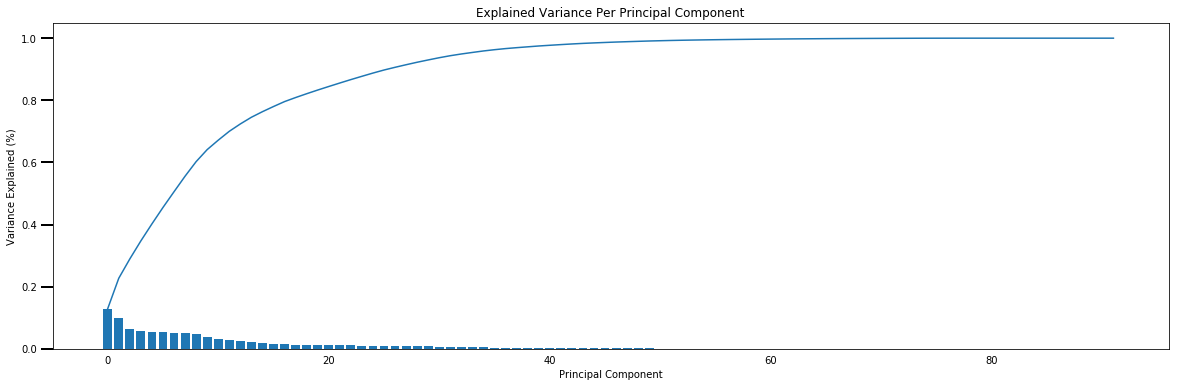

In [141]:
#scree plot for main profile
scree_plot(pca_main)

#PCA
# number of PCA components that explained at least 95% variance ==> 34 components
cumvals = np.cumsum(pca_main.explained_variance_ratio_)
print("Number of Main PCA components that explained at least 95% variance : {}".format(np.where(cumvals >= 0.95)[0][0]+1))

Number of Special PCA components that explained at least 95% variance : 29


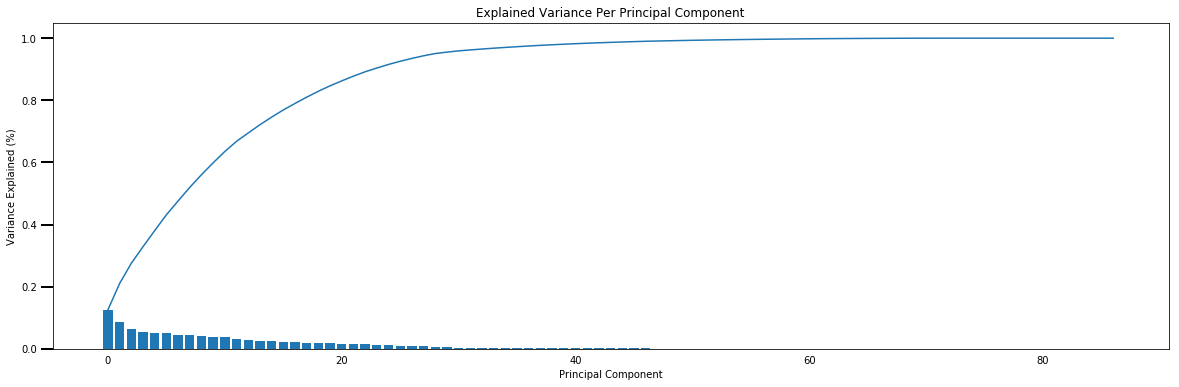

In [142]:
#scree plot for special profile
scree_plot(pca_sp)

#PCA
# number of PCA components that explained at least 95% variance ==> 29 components
cumvals = np.cumsum(pca_sp.explained_variance_ratio_)
print("Number of Special PCA components that explained at least 95% variance : {}".format(np.where(cumvals >= 0.95)[0][0]+1))

In [143]:
#PCA transform with 95% explained variance


def pca_fit_transform(df, var = None):
    pca = PCA(var)
    transform_arr = pca.fit_transform(df)
    return pca, transform_arr

pca_main, pca_transform_main = pca_fit_transform(profile_std_main, var=0.95)
pca_sp, pca_transform_sp = pca_fit_transform(profile_std_sp, var=0.95)

In [171]:
h.save(pca_main, 'pca_main.sav')
h.save(pca_sp, 'pca_sp.sav')



## 2.3 Interpret Princiapl Components

In [146]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.


def plot_weight(df, pca, ith) :
    '''
    plot weight for the i-th principal component to corresponding feature names
    Input : 
        df = original dataframe
        pca = pca.fit(data)
        ith = int value, from 1 to len(pca.n_components)
    Return : axes of barplot 
    '''
    sort_pca = sorted([(weight, label) for weight,label in zip(pca.components_[ith-1], df.columns) ])
    weights, features = zip(*sort_pca)
    weights, features = list(weights), list(features)
    fig, ax = plt.subplots(figsize=(10,20))
    ax = sns.barplot(weights, features)
    return ax

### 2.3.1. Main Profile

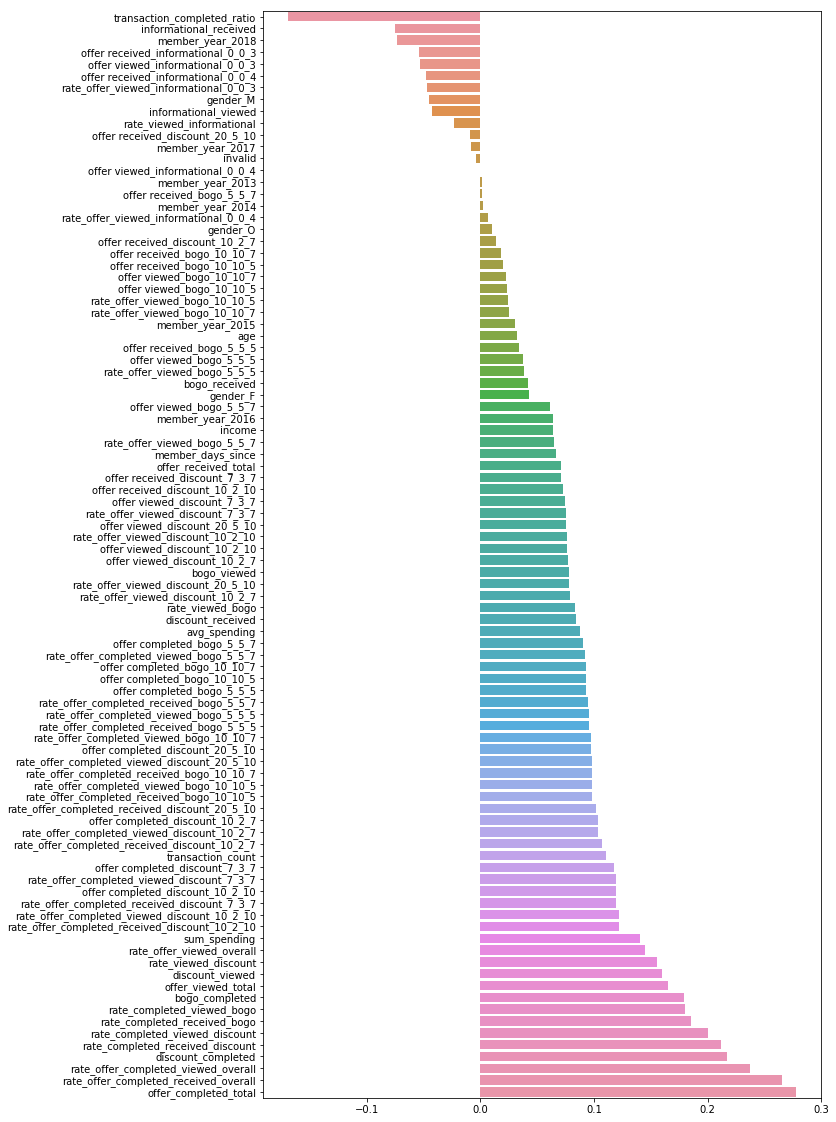

In [147]:
# 1st PCA comp
plot_weight(profile_std_main,pca_main, 1 )

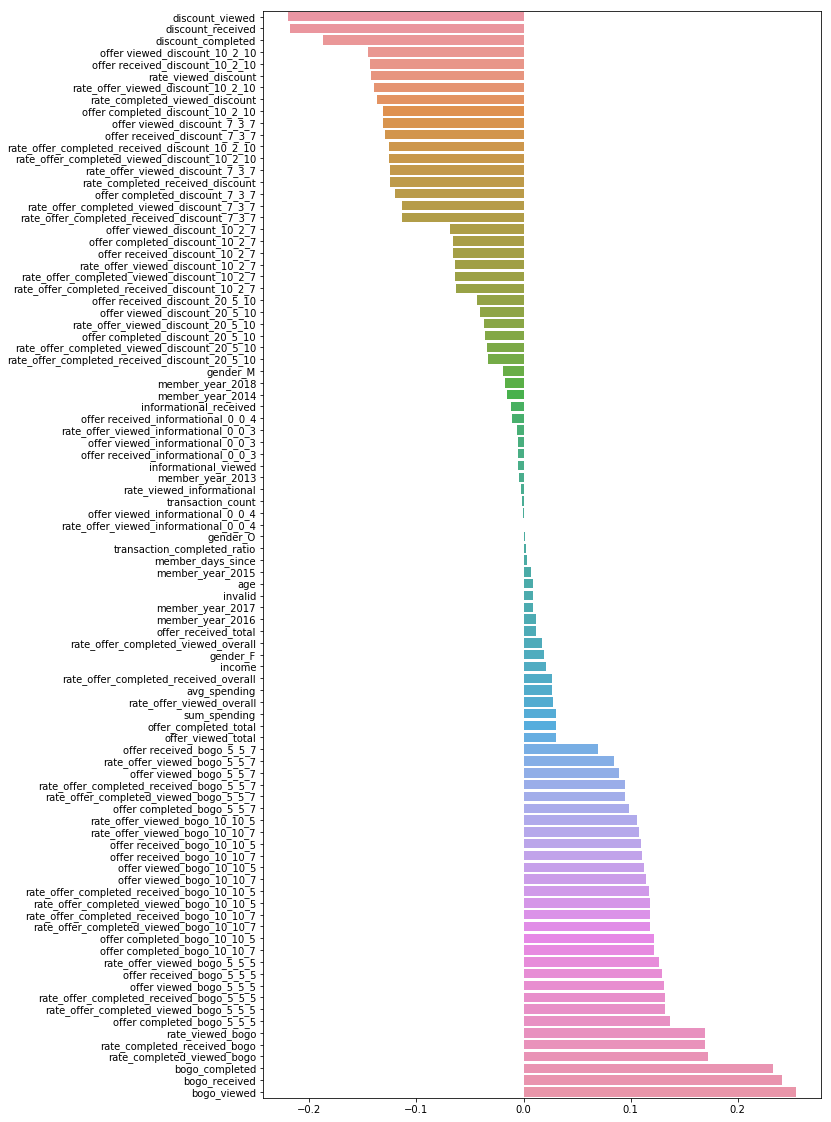

In [148]:
# 2nd PCA comp
plot_weight(profile_std_main,pca_main, 2 )

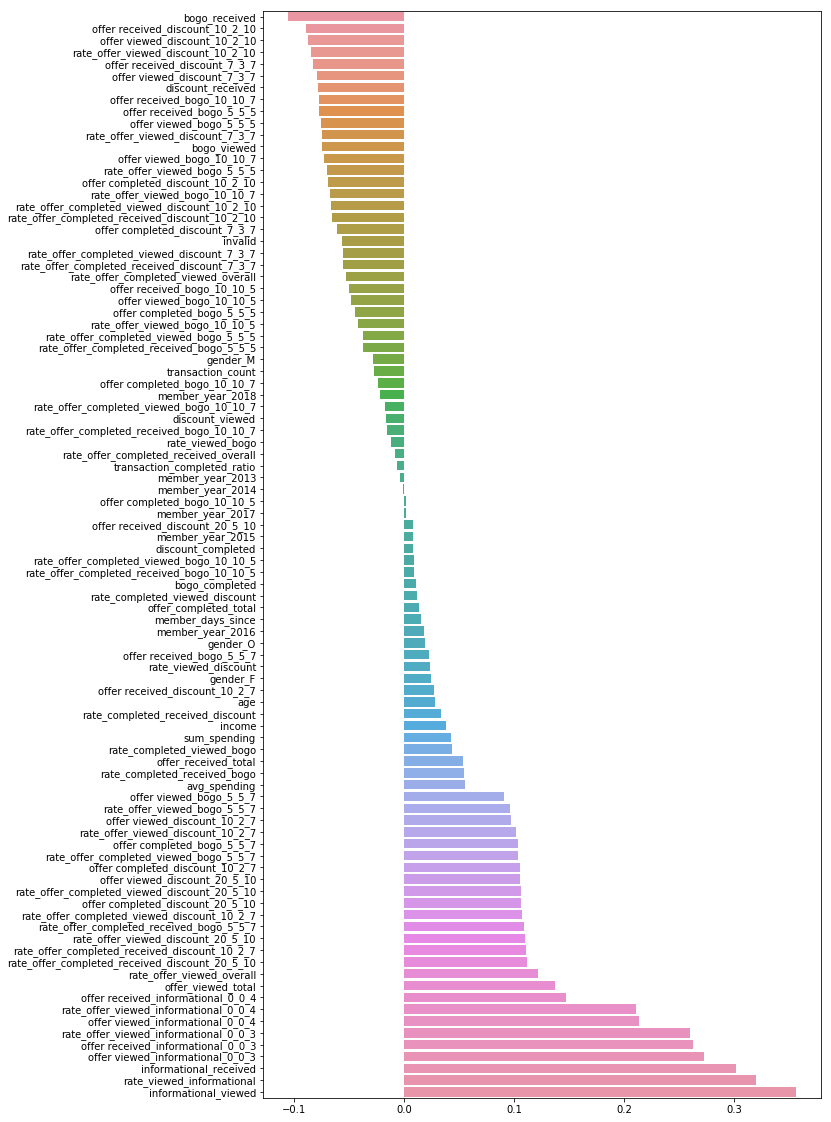

In [149]:
# 3rd PCA comp
plot_weight(profile_std_main,pca_main, 3 )

### 2.3.2. Special Profile

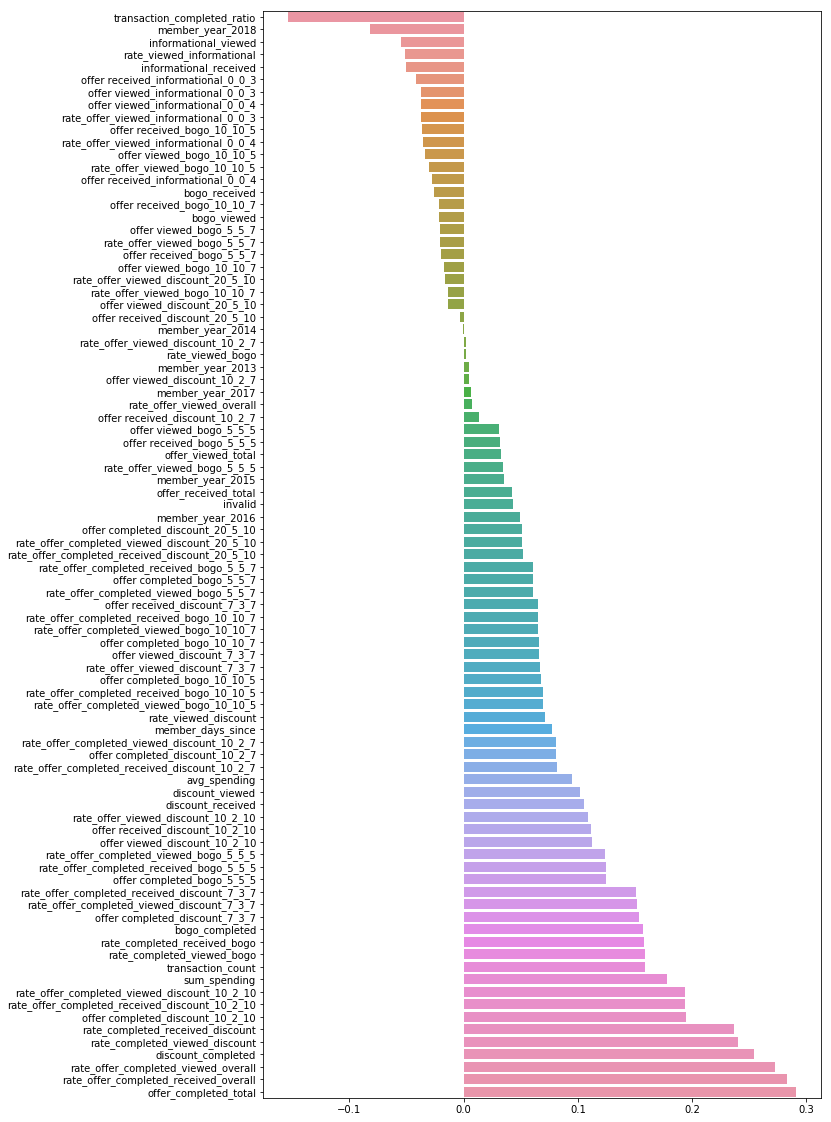

In [150]:
plot_weight(profile_std_sp,pca_sp, 1 )

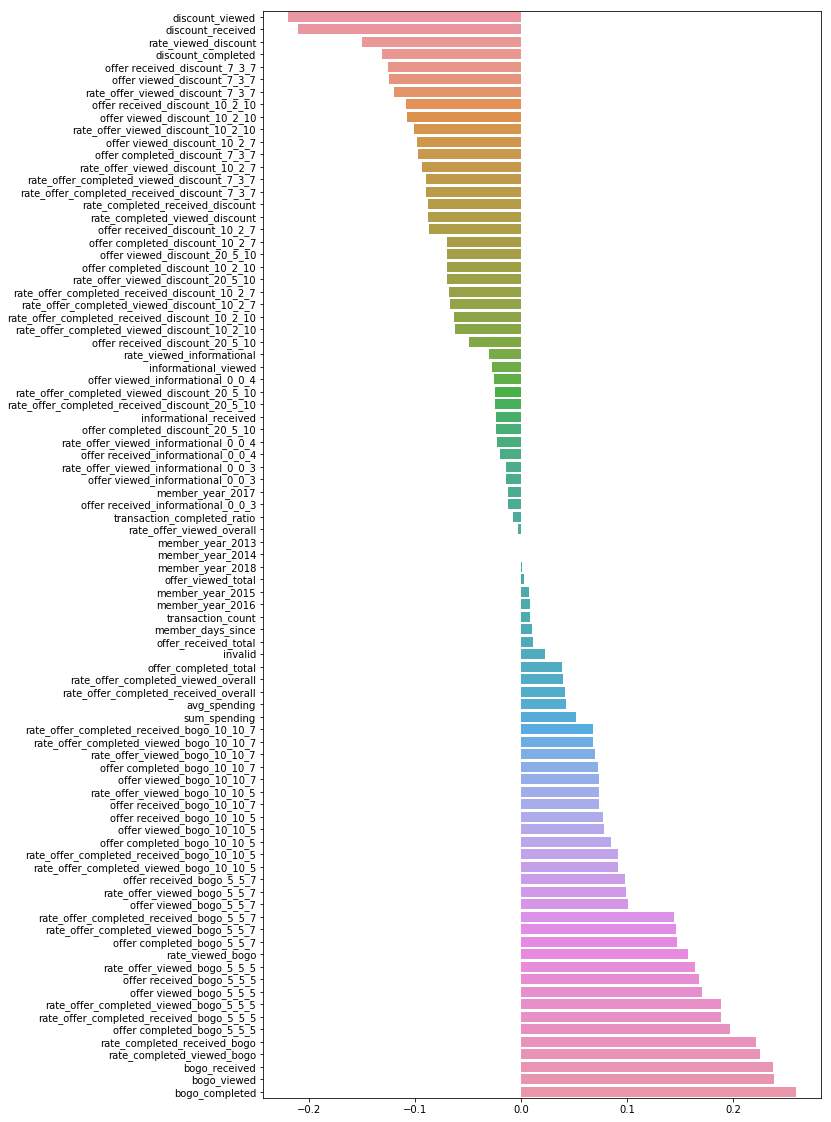

In [151]:
plot_weight(profile_std_sp,pca_sp, 2)

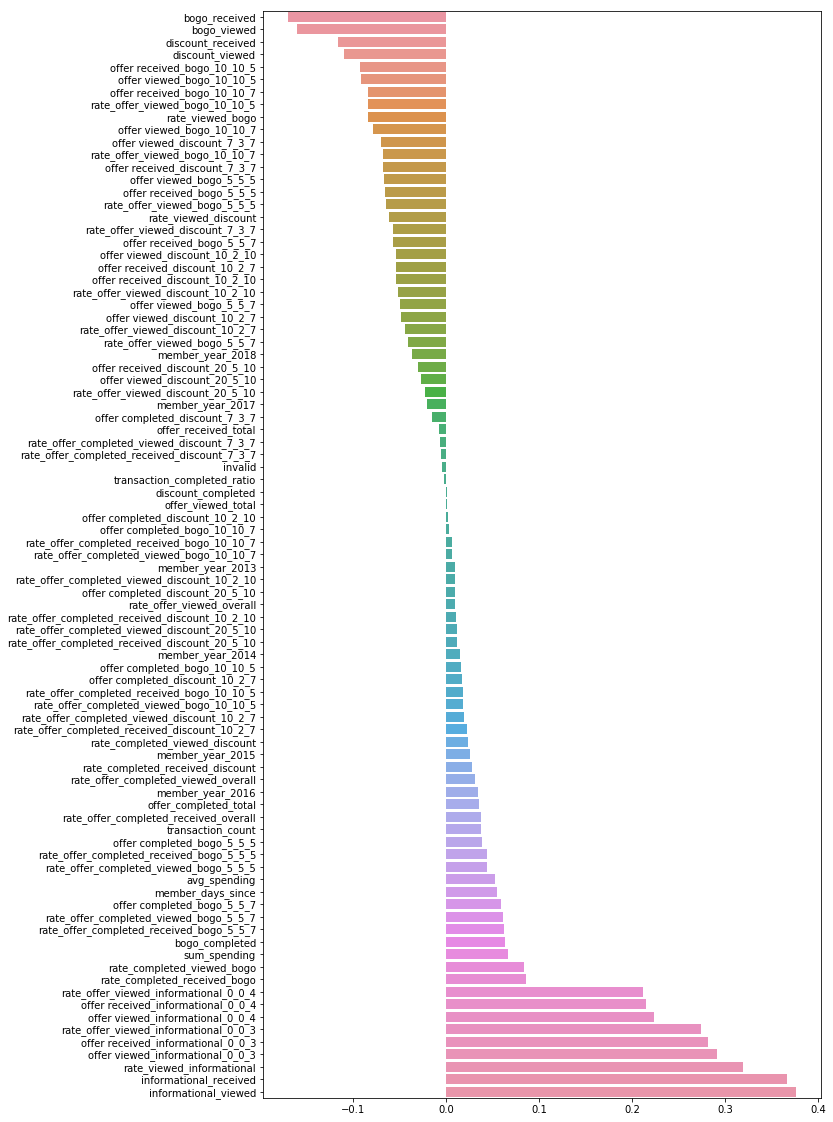

In [152]:
plot_weight(profile_std_sp,pca_sp, 3 )

# 3. Clustering

100%|██████████| 28/28 [04:05<00:00, 10.67s/it]


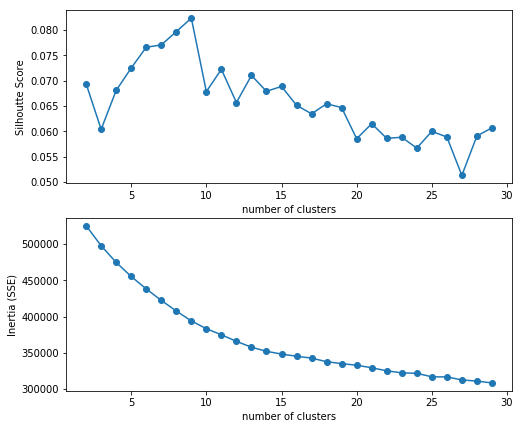

In [150]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import  silhouette_score
from tqdm import tqdm

# X = pca.fit_transform(data)
X = profile_pca
mbk_silh = []
mbk_inertia = []
clusters = range(2,30)
for n in tqdm(clusters):
    
    model = KMeans(n_clusters = n, random_state=42)
    preds = model.fit_predict(X)
    
    silhouette_avg = silhouette_score(X, preds)
       
    mbk_silh.append(silhouette_avg)
    mbk_inertia.append(model.inertia_)

fig, (ax1,ax2) = plt.subplots(2,1, sharex=False, figsize=(8,7))
ax1.plot(clusters, mbk_silh,marker="o")
ax1.set_ylabel("Silhoutte Score")
ax1.set_xlabel('number of clusters')
ax2.plot(clusters, mbk_inertia, marker="o")
ax2.set_ylabel("Inertia (SSE)")
ax2.set_xlabel("number of clusters")
plt.show()

In [153]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import  silhouette_score
from tqdm import tqdm

def finding_num_cluster(X, min_clusters =2, max_clusters =30):
    silh = []
    inertia = []
    clusters = range(min_clusters,max_clusters)
    for n in tqdm(clusters):

        model = KMeans(n_clusters = n, random_state=42)
        preds = model.fit_predict(X)

        silhouette_avg = silhouette_score(X, preds)

        silh.append(silhouette_avg)
        inertia.append(model.inertia_)

    fig, (ax1,ax2) = plt.subplots(2,1, sharex=False, figsize=(8,7))
    ax1.plot(clusters, silh,marker="o")
    ax1.set_ylabel("Silhoutte Score")
    ax1.set_xlabel('number of clusters')
    ax2.plot(clusters, inertia, marker="o")
    ax2.set_ylabel("Inertia (SSE)")
    ax2.set_xlabel("number of clusters")
    plt.show()


100%|██████████| 28/28 [03:56<00:00,  9.65s/it]


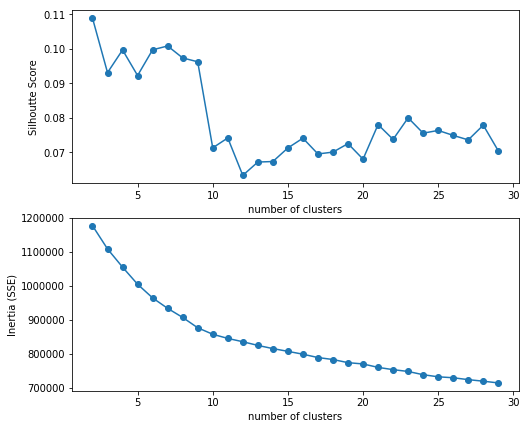

In [154]:
finding_num_cluster(pca_transform_main)


100%|██████████| 28/28 [00:11<00:00,  1.79it/s]


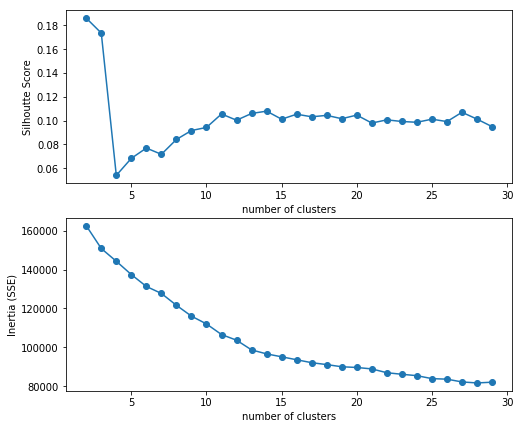

In [155]:
finding_num_cluster(pca_transform_sp)

In [166]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans_main = KMeans(n_clusters = 9, random_state=42)
preds_main = kmeans_main.fit_predict(pca_transform_main) 
h.save(kmeans_main, 'kmeans_main.sav')

#azdias special data
kmeans_sp = KMeans(n_clusters = 11, random_state=42)
preds_sp = kmeans_sp.fit_predict(pca_transform_sp) 
h.save(kmeans_sp, 'kmeans_sp.sav')

In [7]:
#load

#scaler
scaler_main = h.load('scaler_main.sav')
scaler_sp = h.load('scaler_sp.sav')
profile_std_main = scaler_main.transform(profile_main)
profile_std_sp = scaler_sp.transform(profile_sp)

#pca

pca_main = h.load('pca_main.sav')
pca_sp = h.load('pca_sp.sav')
pca_transform_main = pca_main.transform(profile_std_main)
pca_transform_sp = pca_sp.transform(profile_std_sp)

#kmeans
kmeans_main = h.load('kmeans_main.sav')
kmeans_sp = h.load('kmeans_sp.sav')
preds_main = kmeans_main.predict(pca_transform_main)
preds_sp = kmeans_sp.predict(pca_transform_sp)

In [8]:
profile_cluster_main = profile_main.copy()
profile_cluster_sp = profile_sp.copy()

profile_cluster_main['cluster'] = preds_main
profile_cluster_sp['cluster'] = preds_sp

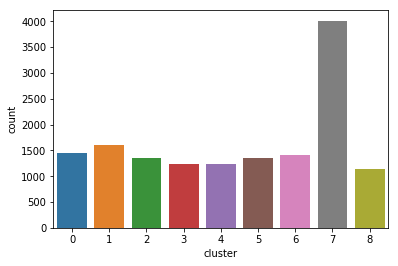

In [9]:
sns.countplot(profile_cluster_main['cluster'])

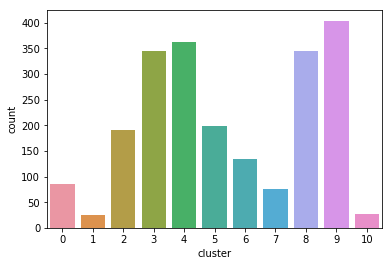

In [10]:
sns.countplot(profile_cluster_sp['cluster'])

In [182]:
def inverse_transform_centroid(df, kmeans, pca, scaler):
    centers = kmeans.cluster_centers_
    centers_pca = pca.inverse_transform(centers)
    centers = scaler.inverse_transform(centers_pca)
    centers = pd.DataFrame(centers, columns= df.columns)
    return centers

In [265]:
cols_main = profile_main.columns[profile_main.columns.str.contains("completed")].tolist() + \
            ['avg_spending', 'income', 'sum_spending', 'transaction_count' , 'gender_M', 'gender_F', 'gender_O' , 'age']

In [271]:
pd.set_option('display.max_columns', 500)
inverse_transform_centroid(profile_main, kmeans_main, pca_main, scaler_main)[cols_main]#.to_csv('centroid_main.csv')

offer completed_bogo_10_10_7  offer completed_bogo_10_10_5  \
0                      1.230012                      0.231526   
1                      0.016726                      0.019516   
2                      0.030049                      0.035368   
3                      0.019004                      0.027340   
4                      0.047057                      1.227190   
5                      0.195412                      0.214319   
6                      0.162931                      0.188334   
7                     -0.004679                     -0.003511   
8                      0.236799                      0.245483   

   offer completed_bogo_5_5_7  offer completed_discount_20_5_10  \
0                    0.016765                         -0.003839   
1                   -0.004253                         -0.000186   
2                    0.015764                         -0.001653   
3                   -0.005922                          0.008404   
4                    0.018575                         -0.006873   
5                    1.210711                          0.007882   
6                    0.113295                          0.006191   
7                   -0.002394                          0.001742   
8                    0.229960                          1.203007   

   offer completed_discount_7_3_7  offer completed_discount_10_2_10  \
0                        0.267037                          0.296441   
1                        0.262744                          1.244235   
2                        0.260957                          0.245803   
3                        1.264200                          0.113552   
4                        0.247518                          0.273929   
5                        0.279841                          0.291473   
6                        0.330717                          0.326636   
7                       -0.007988                         -0.008154   
8                        0.300295                          0.305946   

   offer completed_bogo_5_5_5  offer completed_discount_10_2_7  \
0                    0.283410                         0.018579   
1                    0.031896                         0.013826   
2                    1.201631                         0.002295   
3                    0.043682                         0.019843   
4                    0.268856                         0.023355   
5                    0.264223                         0.063799   
6                    0.205189                         1.216410   
7                   -0.004565                        -0.006856   
8                    0.260645                         0.201031   

   bogo_completed  rate_completed_viewed_bogo  rate_completed_received_bogo  \
0        1.761712                    0.852236                      0.772499   
1        0.063885                    0.102512                      0.080858   
2        1.282812                    0.682311                      0.615276   
3        0.084104                    0.119045                      0.095961   
4        1.561678                    0.790439                      0.717103   
5        1.884665                    0.891311                      0.806501   
6        0.669748                    0.432786                      0.407785   
7       -0.015149                    0.002379                     -0.002088   
8        0.972887                    0.566267                      0.545471   

   discount_completed  rate_completed_viewed_discount  \
0            0.578218                        0.428892   
1            1.520619                        0.848739   
2            0.507402                        0.411222   
3            1.405999                        0.798062   
4            0.537930                        0.416154   
5            0.642995                        0.463049   
6            1.879955                        0.946209   
7           -0.021255                        0.002088   
8    

In [269]:
cols_sp = profile_main.columns[profile_main.columns.str.contains("completed|overall")].tolist() + ['avg_spending',  'sum_spending', 'transaction_count']
inverse_transform_centroid(profile_sp, kmeans_sp, pca_sp, scaler_sp)[cols_sp]#.to_csv('centroid_special.csv')

offer completed_bogo_10_10_7  offer completed_bogo_10_10_5  \
0                      -0.001977                      0.000513   
1                       0.159141                      1.134064   
2                      -0.002361                     -0.004067   
3                       0.003580                      0.001288   
4                      -0.000021                     -0.001132   
5                       0.000250                      0.005454   
6                       0.001733                     -0.001063   
7                       0.005129                      0.001632   
8                      -0.000522                      0.000011   
9                      -0.001666                     -0.000645   
10                      0.985027                     -0.016981   

    offer completed_bogo_5_5_7  offer completed_discount_20_5_10  \
0                     1.052303                          0.000038   
1                     0.037753                          0.000006   
2                    -0.001628                          0.005513   
3                     0.008489                         -0.000746   
4                    -0.002782                          0.002319   
5                     0.005214                          0.060165   
6                     0.007239                          0.022156   
7                    -0.001105                          0.013266   
8                     0.000220                          0.000183   
9                    -0.005491                          0.000977   
10                    0.043476                          0.036816   

    offer completed_discount_7_3_7  offer completed_discount_10_2_10  \
0                         0.108136                          0.156017   
1                         0.154939                          0.278805   
2                         0.071735                          1.130044   
3                        -0.010513                         -0.016861   
4                        -0.002789                         -0.008196   
5                         1.028389                          0.138351   
6                         0.134527                          0.258439   
7                         0.169979                          0.211848   
8                         0.000299                         -0.000385   
9                         0.002778                          0.005685   
10                        0.181505                          0.412307   

    offer completed_bogo_5_5_5  offer completed_discount_10_2_7  \
0                     0.148965                         0.012861   
1                     0.236900                         0.083253   
2                     0.005145                         0.008540   
3                     0.020825                        -0.004410   
4                    -0.003012                        -0.000405   
5                    -0.003133                        -0.002607   
6                     1.047407                        -0.002705   
7                     0.092667                         1.082734   
8                    -0.001971                         0.001906   
9                    -0.010555                         0.002140   
10                    0.049566                        -0.002680   

    bogo_completed  rate_completed_viewed_bogo  rate_completed_received_bogo  \
0         1.199804                    0.641058                      0.601934   
1         1.567859                    0.673087                      0.626252   
2        -0.002911                    0.008939                      0.011776   
3         0.034182                   -0.025856                     -0.027548   
4        -0.006947                    0.007552                      0.006686   
5         0.007785                    0.012419                      0.006747   
6         1.055316                    0.628569                      0.566277   
7         0.098323                    0.044088                      0.043330   
8   

In [ ]:
['rate_offer_completed_received_overall']

In [239]:
columns = [ 'pca_' + str(i) for i in list(range(1,pca_transform_main.shape[1]+1)) ]
pca_df = pd.DataFrame(pca_transform_main, index= profile_main.index, columns= columns)
pca_df['cluster'] = ['c_' + str(i) for i in preds_main]

pca_df.head()

pca_1     pca_2     pca_3     pca_4  \
Unnamed: 0                                                                 
0610b486422d4921ae7d2bf64640c50b -5.502797 -0.355621 -1.203802  0.032298   
78afa995795e4d85b5d9ceeca43f5fef  0.562486  5.994375  2.249124 -0.285838   
e2127556f4f64592b11af22de27a7932  1.887517 -0.944512  0.338602 -3.264295   
389bc3fa690240e798340f5a15918d5c  6.743304  2.250054 -0.420041 -2.467506   
2eeac8d8feae4a8cad5a6af0499a211d -1.274571 -4.535877 -2.210135 -1.669285   

                                     pca_5     pca_6     pca_7     pca_8  \
Unnamed: 0                                                                 
0610b486422d4921ae7d2bf64640c50b  1.433585  1.416435 -0.171246  0.684365   
78afa995795e4d85b5d9ceeca43f5fef  0.038668  0.432725  3.388564  3.275471   
e2127556f4f64592b11af22de27a7932  1.758112  2.262661 -0.828900  3.906358   
389bc3fa690240e798340f5a15918d5c -2.088251  6.084194 -2.316084  0.947506   
2eeac8d8feae4a8cad5a6af0499a211d -0.590966 -0.381124 -0.156387  1.211327   

                                     pca_9    pca_10   ...       pca_26  \
Unnamed: 0                                             ...                
0610b486422d4921ae7d2bf64640c50b  0.292361  4.639628   ...     0.829256   
78afa995795e4d85b5d9ceeca43f5fef -1.871533  0.380157   ...     0.115490   
e2127556f4f64592b11af22de27a7932 -3.036185 -0.131366   ...     1.024007   
389bc3fa690240e798340f5a15918d5c -4.859537 -3.684233   ...    -0.728948   
2eeac8d8feae4a8cad5a6af0499a211d  0.002100  0.982664   ...     1.206558   

                                    pca_27    pca_28    pca_29    pca_30  \
Unnamed: 0                                                                 
0610b486422d4921ae7d2bf64640c50b -0.076665 -0.552653 -0.002647  0.085859   
78afa995795e4d85b5d9ceeca43f5fef  0.490320  0.320475  1.006191 -0.103123   
e2127556f4f64592b11af22de27a7932  1.747287  0.635876 -1.655774 -0.418793   
389bc3fa690240e798340f5a15918d5c -0.943865  0.858661  0.033001  0.397159   
2eeac8d8feae4a8cad5a6af0499a211d -0.507323 -0.053125  0.382176  1.069421   

                                    pca_31    pca_32    pca_33    pca_34  \
Unnamed: 0                                                                 
0610b486422d4921ae7d2bf64640c50b  0.213127 -0.185654 -1.134116 -0.435004   
78afa995795e4d85b5d9ceeca43f5fef -0.127195 -0.502662 -0.382599 -0.906557   
e2127556f4f64592b11af22de27a7932 -1.514343  0.096068 -0.455108  0.923422   
389bc3fa690240e798340f5a15918d5c  0.292627  1.363585 -0.564698  0.298494   
2eeac8d8feae4a8cad5a6af0499a211d -1.457725  0.438220  0.393439 -0.267699   

                                  cluster  
Unnamed: 0                                 
0610b486422d4921ae7d2bf64640c50b      c_7  
78afa995795e4d85b5d9ceeca43f5fef      c_5  
e2127556f4f64592b11af22de27a7932      c_5  
389bc3fa690240e798340f5a15918d5c      c_5  
2eeac8d8feae4a8cad5a6af0499a211d      c_1  

[5 rows x 35 columns]

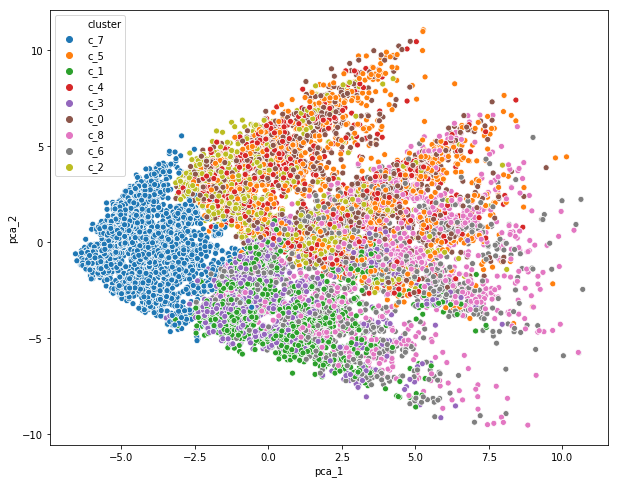

In [244]:
f,ax = plt.subplots(figsize=(10,8))
sns.scatterplot('pca_1','pca_2', hue='cluster', data=pca_df, ax=ax)

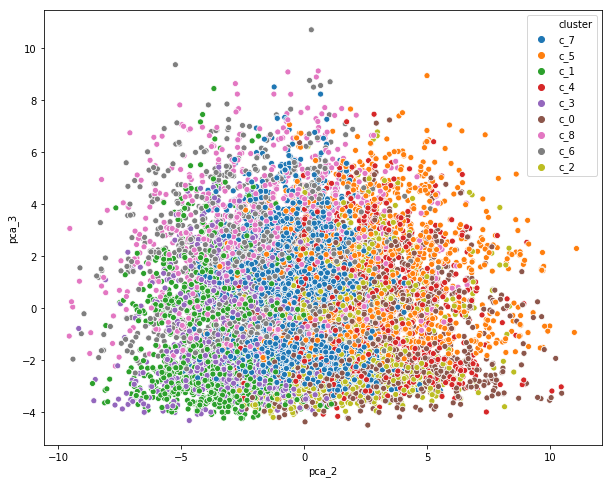

In [242]:
f,ax = plt.subplots(figsize=(10,8))
sns.scatterplot('pca_2','pca_3', hue='cluster', data=pca_df, ax=ax)

In [11]:
profile_main_clust = profile_main.copy()
profile_main_clust['cluster'] = preds_main
profile_main_clust.head()

age    income  offer received_bogo_10_10_7  \
Unnamed: 0                                                                     
0610b486422d4921ae7d2bf64640c50b   55  112000.0                          0.0   
78afa995795e4d85b5d9ceeca43f5fef   75  100000.0                          1.0   
e2127556f4f64592b11af22de27a7932   68   70000.0                          0.0   
389bc3fa690240e798340f5a15918d5c   65   53000.0                          0.0   
2eeac8d8feae4a8cad5a6af0499a211d   58   51000.0                          0.0   

                                  offer received_bogo_10_10_5  \
Unnamed: 0                                                      
0610b486422d4921ae7d2bf64640c50b                          0.0   
78afa995795e4d85b5d9ceeca43f5fef                          0.0   
e2127556f4f64592b11af22de27a7932                          0.0   
389bc3fa690240e798340f5a15918d5c                          0.0   
2eeac8d8feae4a8cad5a6af0499a211d                          0.0   

                                  offer received_informational_0_0_4  \
Unnamed: 0                                                             
0610b486422d4921ae7d2bf64640c50b                                 1.0   
78afa995795e4d85b5d9ceeca43f5fef                                 0.0   
e2127556f4f64592b11af22de27a7932                                 1.0   
389bc3fa690240e798340f5a15918d5c                                 0.0   
2eeac8d8feae4a8cad5a6af0499a211d                                 1.0   

                                  offer received_bogo_5_5_7  \
Unnamed: 0                                                    
0610b486422d4921ae7d2bf64640c50b                        1.0   
78afa995795e4d85b5d9ceeca43f5fef                        1.0   
e2127556f4f64592b11af22de27a7932                        1.0   
389bc3fa690240e798340f5a15918d5c                        2.0   
2eeac8d8feae4a8cad5a6af0499a211d                        0.0   

                                  offer received_discount_20_5_10  \
Unnamed: 0                                                          
0610b486422d4921ae7d2bf64640c50b                              0.0   
78afa995795e4d85b5d9ceeca43f5fef                              0.0   
e2127556f4f64592b11af22de27a7932                              0.0   
389bc3fa690240e798340f5a15918d5c                              0.0   
2eeac8d8feae4a8cad5a6af0499a211d                              0.0   

                                  offer received_discount_7_3_7  \
Unnamed: 0                                                        
0610b486422d4921ae7d2bf64640c50b                            0.0   
78afa995795e4d85b5d9ceeca43f5fef                            0.0   
e2127556f4f64592b11af22de27a7932                            0.0   
389bc3fa690240e798340f5a15918d5c                            0.0   
2eeac8d8feae4a8cad5a6af0499a211d                            1.0   

                                  offer received_discount_10_2_10  \
Unnamed: 0                                                          
0610b486422d4921ae7d2bf64640c50b                              0.0   
78afa995795e4d85b5d9ceeca43f5fef                              0.0   
e2127556f4f64592b11af22de27a7932                              1.0   
389bc3fa690240e798340f5a15918d5c                              1.0   
2eeac8d8feae4a8cad5a6af0499a211d                              1.0   

                                  offer received_informational_0_0_3   ...     \
Unnamed: 0                                                             ...      
0610b486422d4921ae7d2bf64640c50b                                 0.0   ...      
78afa995795e4d85b5d9ceeca43f5fef                                 1.0   ...      
e2127556f4f64592b11af22de27a7932                                 0.0   ...      
389bc3fa690240e798340f5a15918d5c                                 0.0   ...      
2eeac8d8feae4a8cad5a6af0499a211d                                 0.0   ...      

                                  gender_F  gender_M  gender_O  

In [12]:
# gender_col = 
binary_cols = [col for col in profile_main_clust  if profile_main_clust[col].value_counts().index.isin([0,1]).all()]
gender_col = binary_cols[:3]
member_col = binary_cols[3:]

In [13]:
profile_main_clust['gender'] = profile_main_clust[gender_col].idxmax(axis=1)
profile_main_clust['member_year'] = profile_main_clust[member_col].idxmax(axis=1)
profile_main_clust = profile_main_clust.drop(binary_cols, axis=1)

In [14]:
profile_main_clust.head()

age    income  offer received_bogo_10_10_7  \
Unnamed: 0                                                                     
0610b486422d4921ae7d2bf64640c50b   55  112000.0                          0.0   
78afa995795e4d85b5d9ceeca43f5fef   75  100000.0                          1.0   
e2127556f4f64592b11af22de27a7932   68   70000.0                          0.0   
389bc3fa690240e798340f5a15918d5c   65   53000.0                          0.0   
2eeac8d8feae4a8cad5a6af0499a211d   58   51000.0                          0.0   

                                  offer received_bogo_10_10_5  \
Unnamed: 0                                                      
0610b486422d4921ae7d2bf64640c50b                          0.0   
78afa995795e4d85b5d9ceeca43f5fef                          0.0   
e2127556f4f64592b11af22de27a7932                          0.0   
389bc3fa690240e798340f5a15918d5c                          0.0   
2eeac8d8feae4a8cad5a6af0499a211d                          0.0   

                                  offer received_informational_0_0_4  \
Unnamed: 0                                                             
0610b486422d4921ae7d2bf64640c50b                                 1.0   
78afa995795e4d85b5d9ceeca43f5fef                                 0.0   
e2127556f4f64592b11af22de27a7932                                 1.0   
389bc3fa690240e798340f5a15918d5c                                 0.0   
2eeac8d8feae4a8cad5a6af0499a211d                                 1.0   

                                  offer received_bogo_5_5_7  \
Unnamed: 0                                                    
0610b486422d4921ae7d2bf64640c50b                        1.0   
78afa995795e4d85b5d9ceeca43f5fef                        1.0   
e2127556f4f64592b11af22de27a7932                        1.0   
389bc3fa690240e798340f5a15918d5c                        2.0   
2eeac8d8feae4a8cad5a6af0499a211d                        0.0   

                                  offer received_discount_20_5_10  \
Unnamed: 0                                                          
0610b486422d4921ae7d2bf64640c50b                              0.0   
78afa995795e4d85b5d9ceeca43f5fef                              0.0   
e2127556f4f64592b11af22de27a7932                              0.0   
389bc3fa690240e798340f5a15918d5c                              0.0   
2eeac8d8feae4a8cad5a6af0499a211d                              0.0   

                                  offer received_discount_7_3_7  \
Unnamed: 0                                                        
0610b486422d4921ae7d2bf64640c50b                            0.0   
78afa995795e4d85b5d9ceeca43f5fef                            0.0   
e2127556f4f64592b11af22de27a7932                            0.0   
389bc3fa690240e798340f5a15918d5c                            0.0   
2eeac8d8feae4a8cad5a6af0499a211d                            1.0   

                                  offer received_discount_10_2_10  \
Unnamed: 0                                                          
0610b486422d4921ae7d2bf64640c50b                              0.0   
78afa995795e4d85b5d9ceeca43f5fef                              0.0   
e2127556f4f64592b11af22de27a7932                              1.0   
389bc3fa690240e798340f5a15918d5c                              1.0   
2eeac8d8feae4a8cad5a6af0499a211d                              1.0   

                                  offer received_informational_0_0_3  \
Unnamed: 0                                                             
0610b486422d4921ae7d2bf64640c50b                                 0.0   
78afa995795e4d85b5d9ceeca43f5fef                                 1.0   
e2127556f4f64592b11af22de27a7932                                 0.0   
389bc3fa690240e798340f5a15918d5c                                 0.0   
2eeac8d8feae4a8cad5a6af0499a211d                                 0.0   

                                        ...         \
Unnamed: 0                              ...          
0610b486422d4921ae7

In [78]:
cols = profile_main_clust.columns[profile_main_clust.columns.str.contains("rate")].tolist() + \
            ['avg_spending', 'income', 'sum_spending', 'transaction_count' ,  'age', 'member_days_since']

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


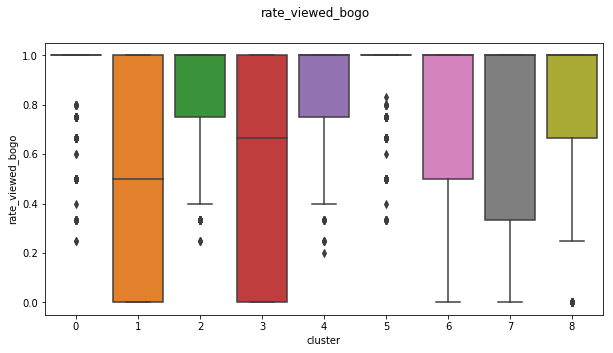

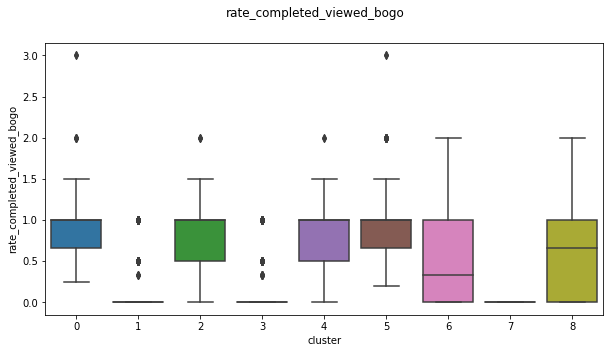

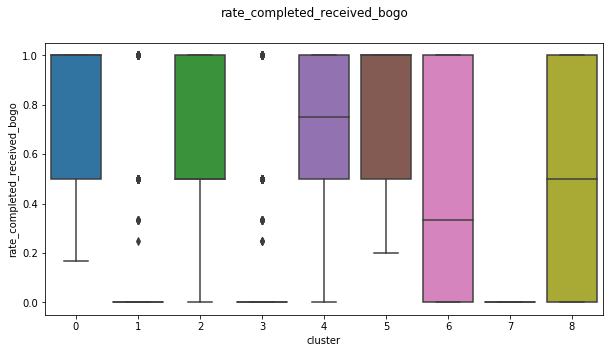

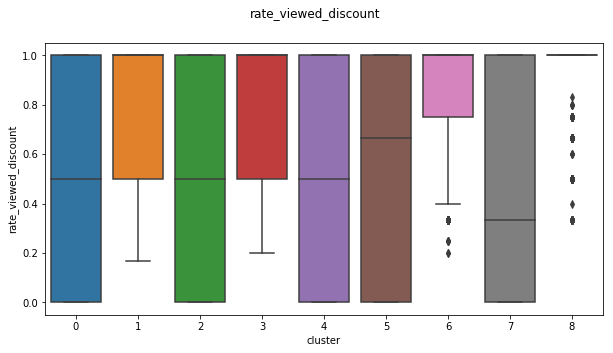

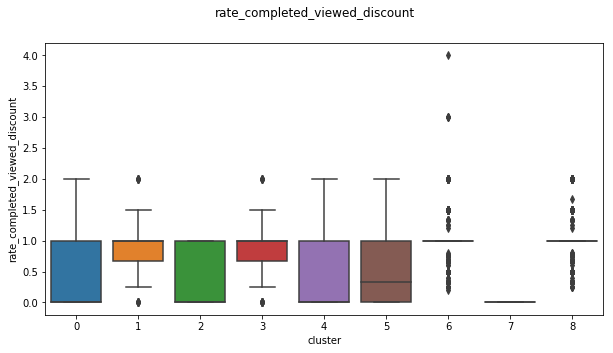

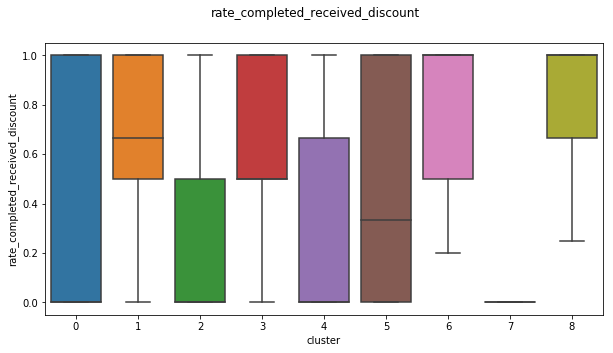

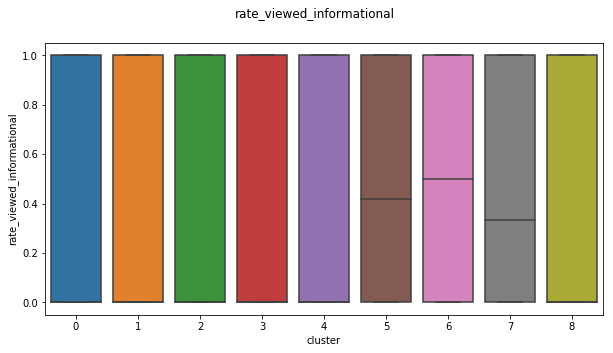

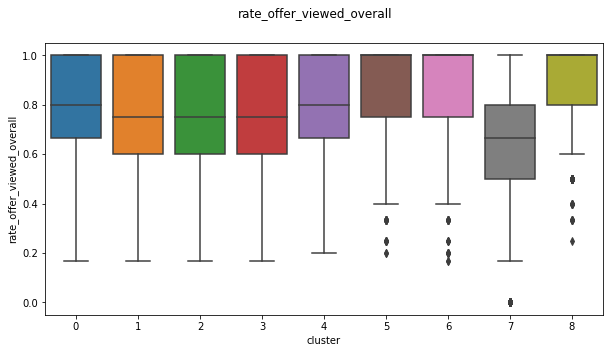

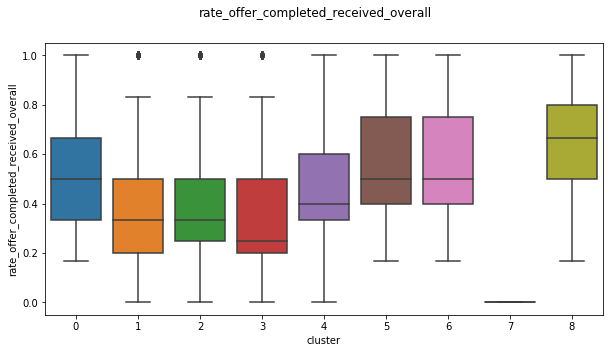

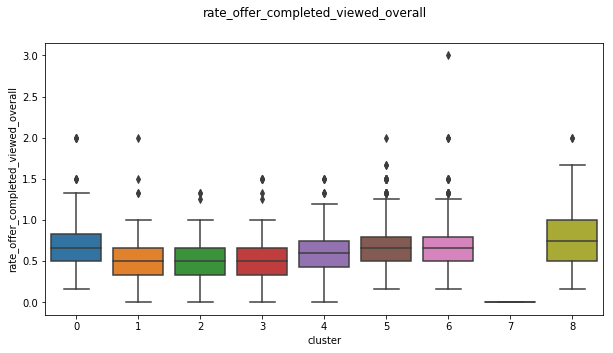

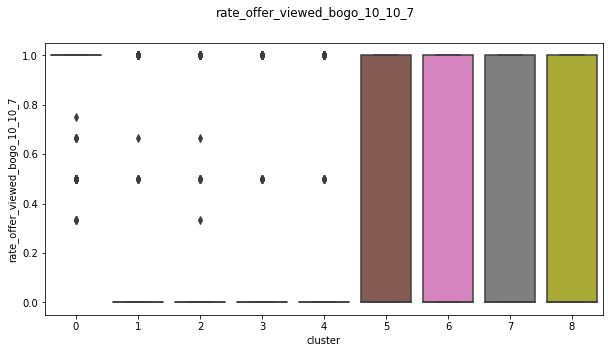

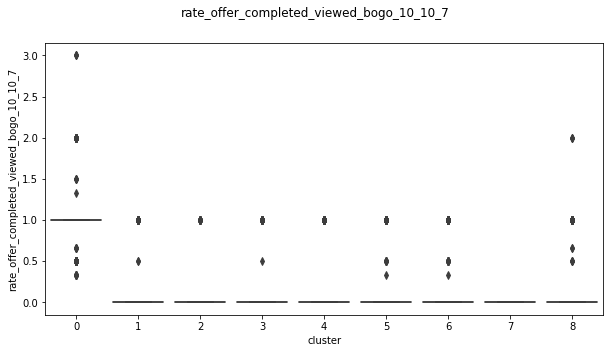

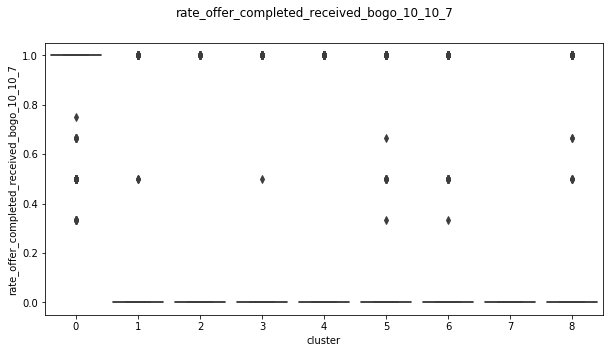

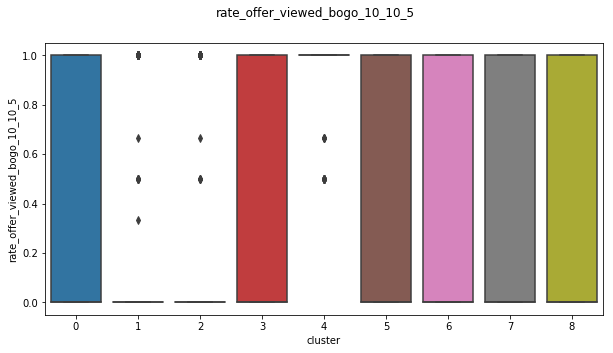

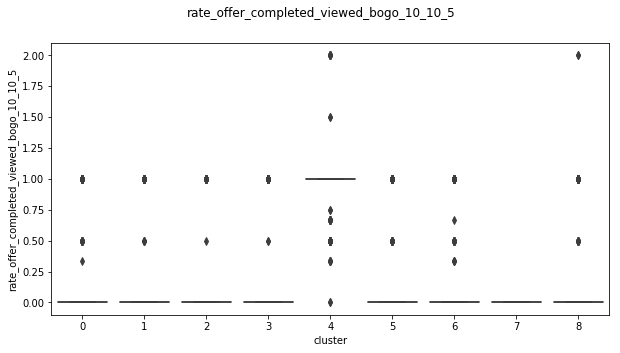

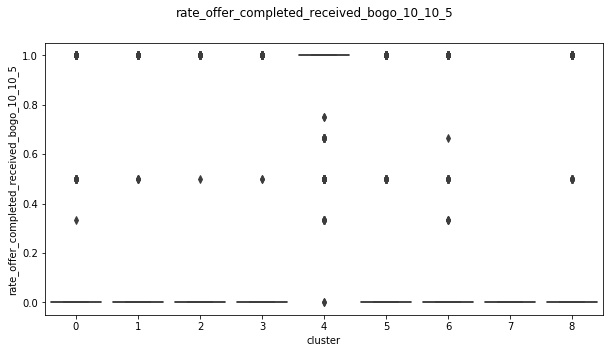

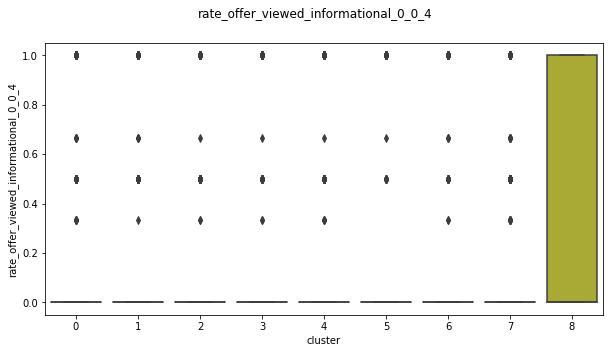

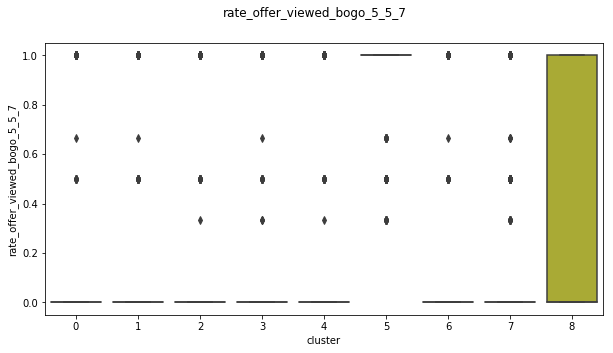

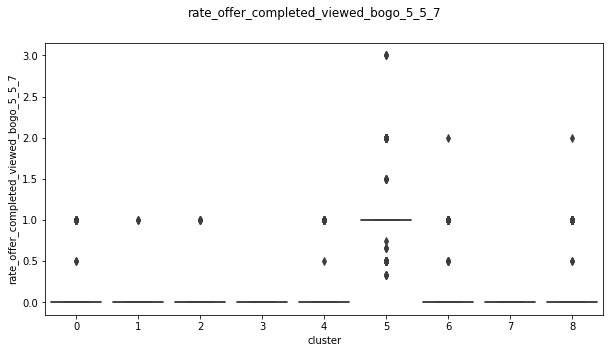

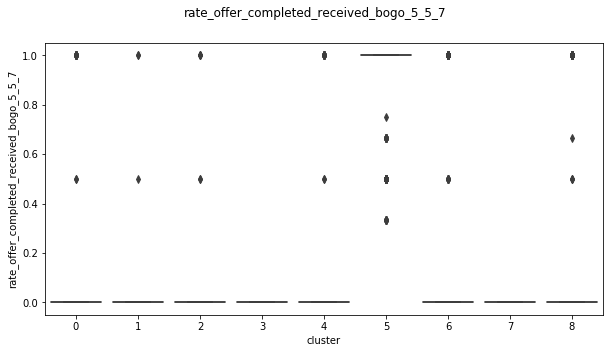

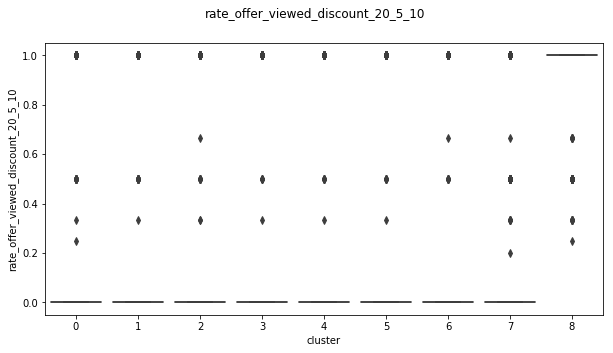

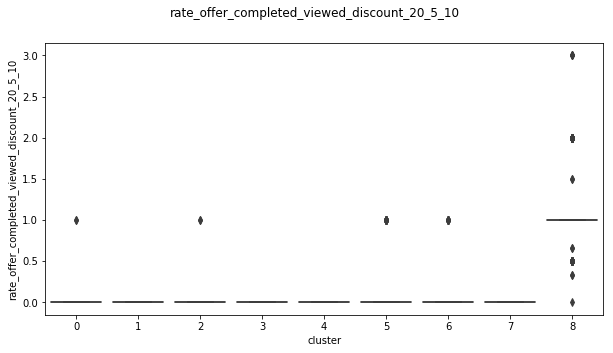

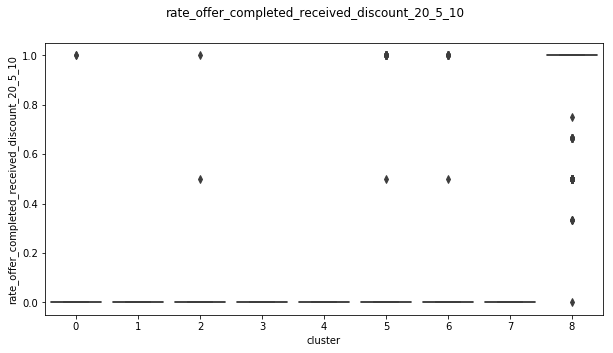

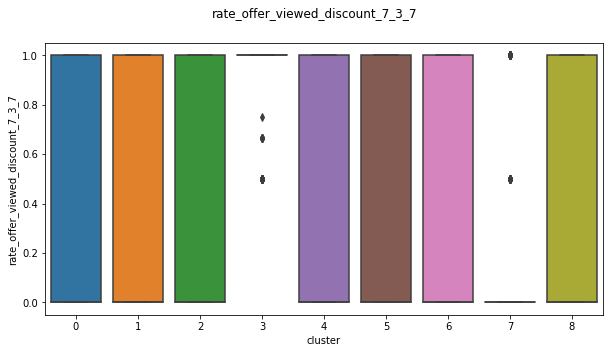

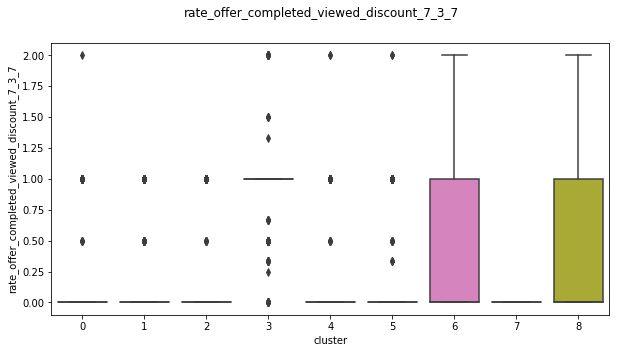

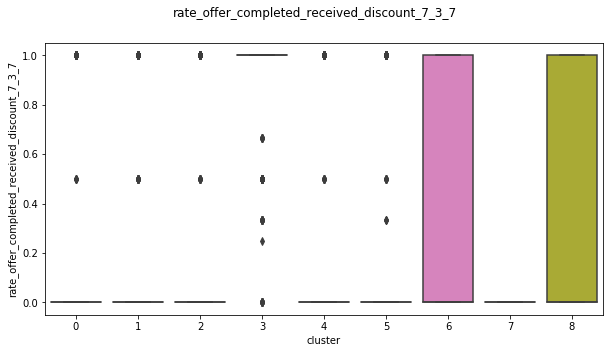

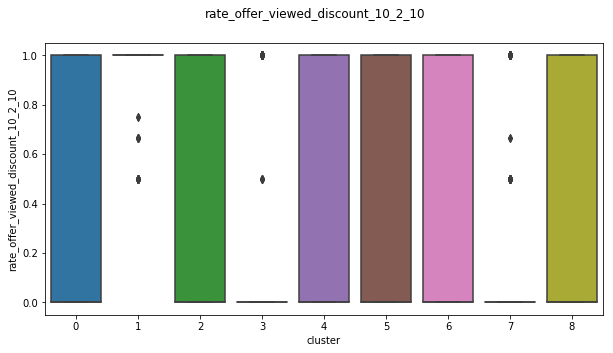

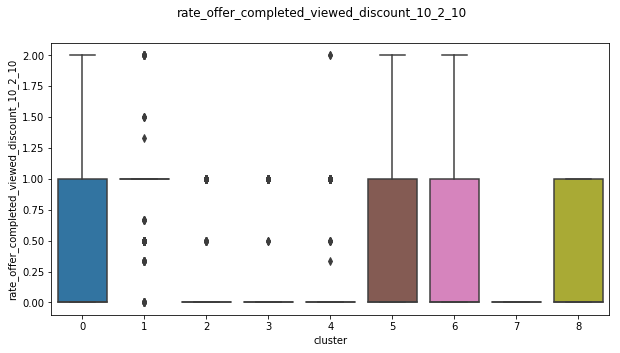

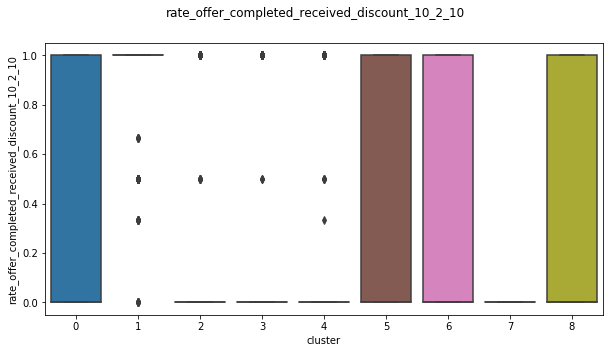

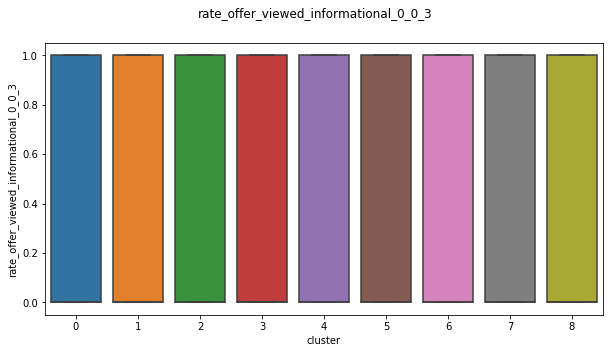

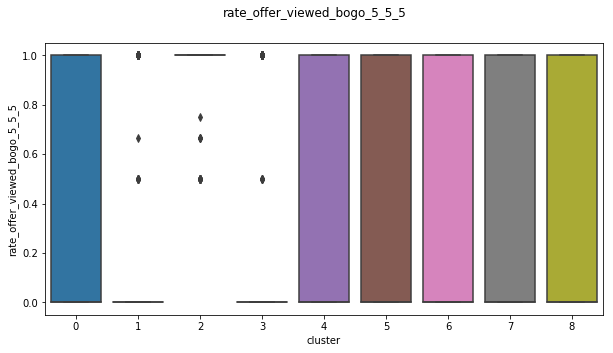

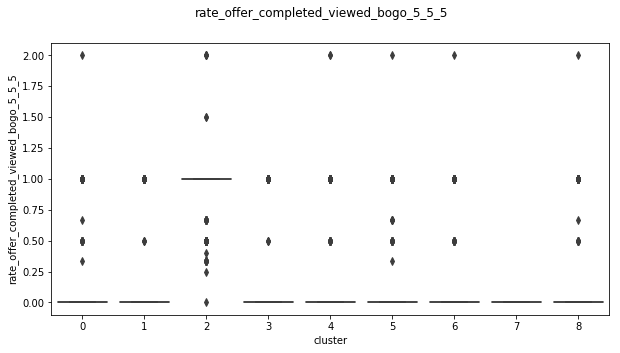

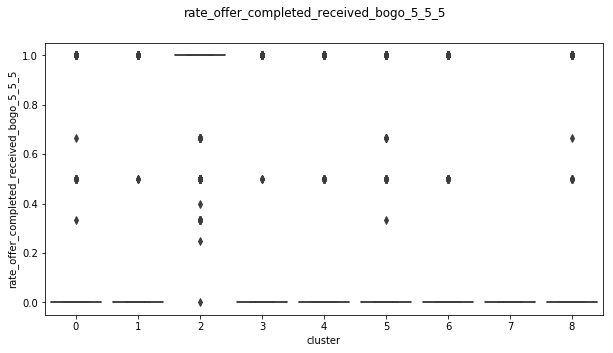

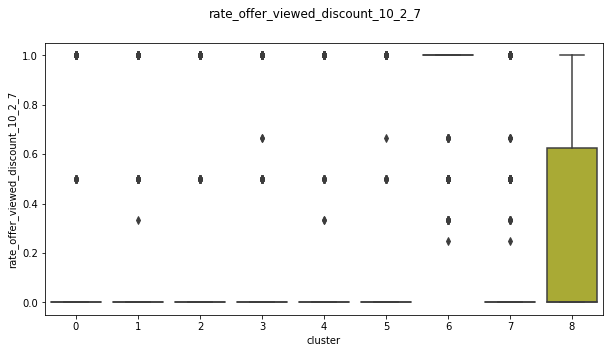

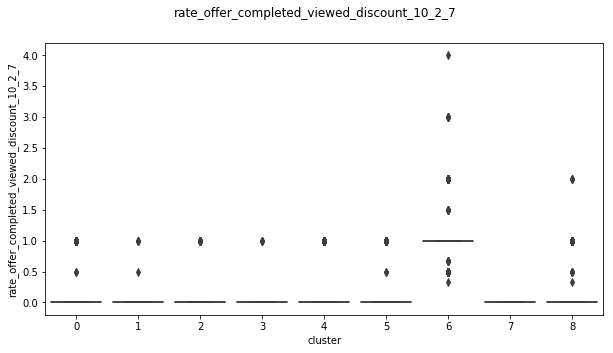

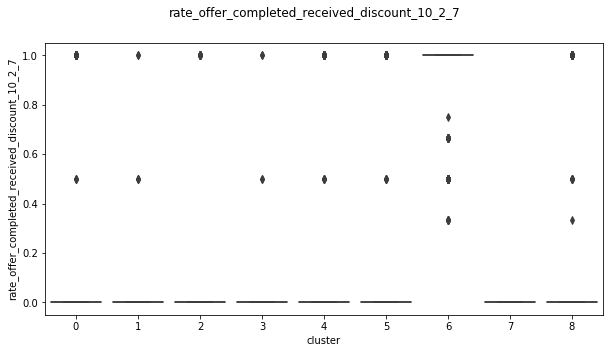

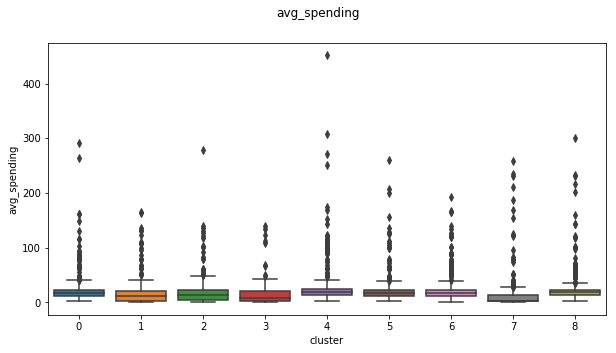

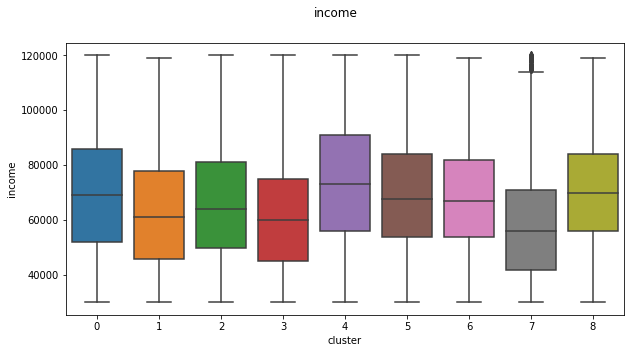

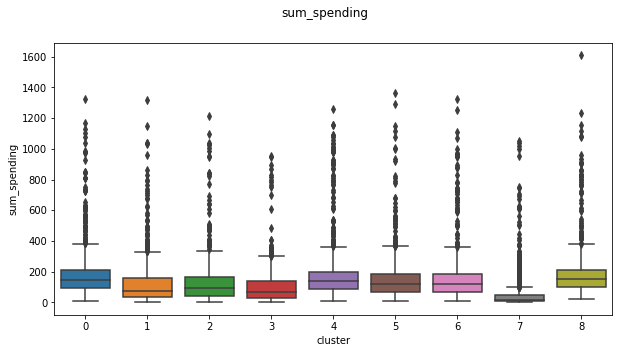

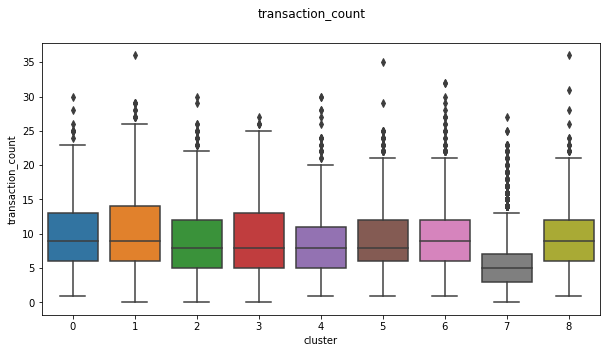

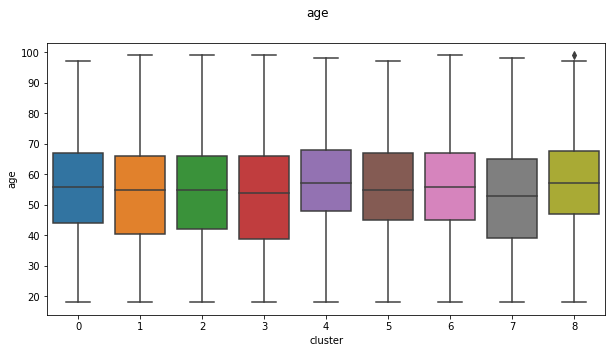

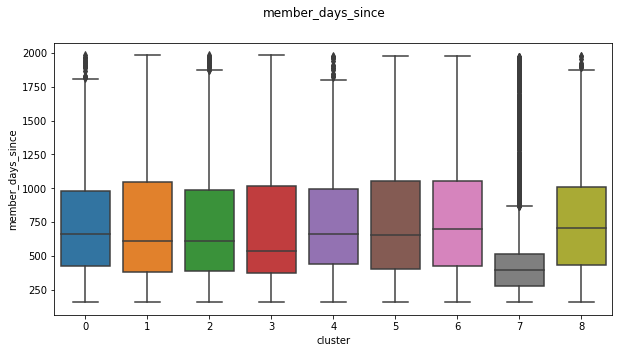

In [79]:
for col in cols:
    f, ax = plt.subplots(figsize=(10,5))
    sns.boxplot('cluster', col, data= profile_main_clust, ax=ax)
    f.suptitle(col)

In [15]:
cols_ = ['age',
 'income',
 'avg_spending',
 'transaction_count',
 'sum_spending',
 'invalid',
 'rate_viewed_bogo',
 'rate_completed_viewed_bogo',
 'rate_completed_received_bogo',
 'discount_received',
 'rate_viewed_discount',
 'rate_completed_viewed_discount',
 'rate_completed_received_discount',
 'rate_viewed_informational',
 'offer_received_total',
 'offer_viewed_total',
 'offer_completed_total',
 'rate_offer_viewed_overall',
 'rate_offer_completed_received_overall',
 'rate_offer_completed_viewed_overall',
 'transaction_completed_ratio',
 'member_days_since'
 ]
pd.set_option('display.max_columns', 500)

profile_main_clust_ = profile_main_clust.groupby('cluster').mean()[cols_]
profile_main_clust_

age        income  avg_spending  transaction_count  \
cluster                                                             
0        55.580042  69707.553708     19.544876           9.792100   
1        53.627561  63952.203600     13.770144          10.253880   
2        54.286031  66261.640798     15.399313           9.211382   
3        52.737942  62869.774920     12.378065           9.578778   
4        57.236585  73635.772358     21.946690           8.781301   
5        55.657080  68666.666667     18.125634           9.157817   
6        55.524045  67988.684583     18.336623           9.546676   
7        52.261780  59035.651957      8.178577           5.314385   
8        56.739092  70043.630017     20.756231           9.371728   

         sum_spending   invalid  rate_viewed_bogo  rate_completed_viewed_bogo  \
cluster                                                                         
0          173.490312  0.783091          0.913733                    0.856699   
1          114.615233  0.755431          0.516977                    0.063522   
2          123.415181  0.756837          0.885341                    0.749101   
3           99.949325  0.647106          0.545552                    0.079850   
4          172.927585  0.917886          0.893984                    0.831152   
5          147.845804  0.547935          0.934132                    0.863975   
6          154.208324  0.516266          0.725424                    0.439851   
7           41.759023  0.496634          0.644303                    0.000000   
8          180.625236  0.467714          0.777778                    0.567408   

         rate_completed_received_bogo  discount_received  \
cluster                                                    
0                            0.772638           1.338184   
1                            0.057987           2.458721   
2                            0.651725           1.419808   
3                            0.072012           2.390675   
4                            0.736477           1.349593   
5                            0.790106           1.331858   
6                            0.411327           2.433522   
7                            0.000000           1.545500   
8                            0.547339           2.387435   

         rate_viewed_discount  rate_completed_viewed_discount  \
cluster                                                         
0                    0.541511                        0.419670   
1                    0.790958                        0.871095   
2                    0.519869                        0.386425   
3                    0.780051                        0.863143   
4                    0.525799                        0.403388   
5                    0.591630                        0.466261   
6                    0.879950                        0.937435   
7                    0.395575                        0.000000   
8                    0.921233                        0.965692   

         rate_completed_received_discount  rate_viewed_informational  \
cluster                                                                
0                                0.358535                   0.412797   
1                                0.674167                   0.406942   
2                                0.318477                   0.412848   
3                                0.661093                   0.396771   
4                                0.337385                   0.440515   
5                                0.403786                   0.479474   
6                                0.802805                   0.478430   
7                                0.000000                   0.436167   
8                                0.862216                   0.478403   

         offer_received_total  offer_viewed_total  offer_completed_total  \
cluster                                                                    
0                    4.550936            

In [16]:
profile_main_norm = (profile_main_clust_ - profile_main_clust_.mean(axis=0))/profile_main_clust_.std(axis=0)

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


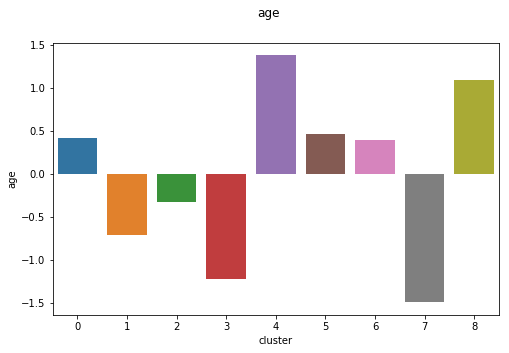

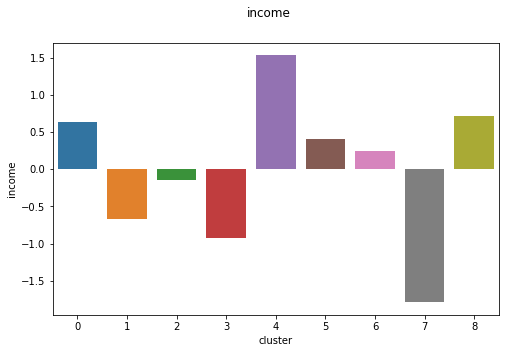

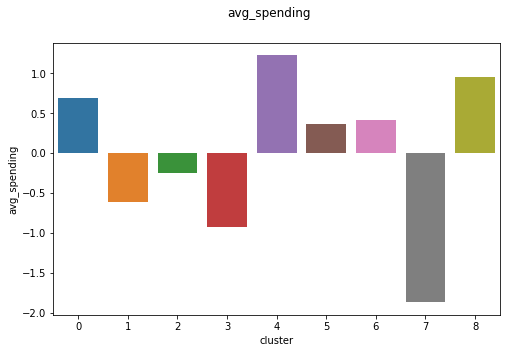

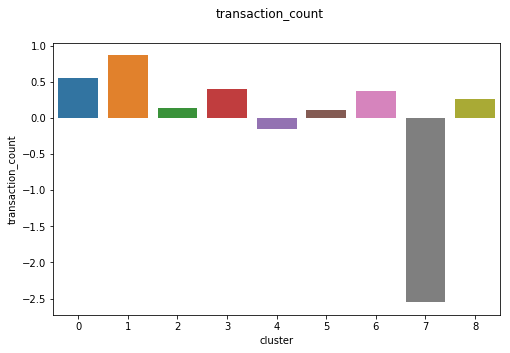

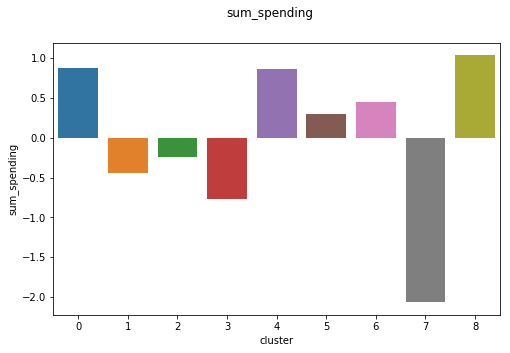

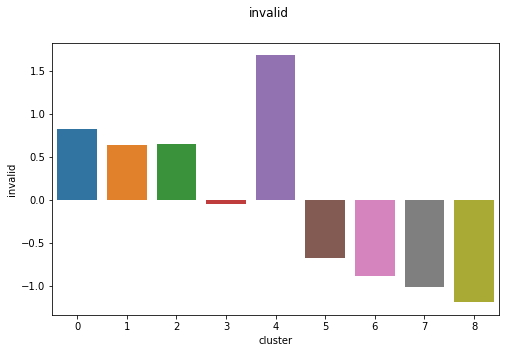

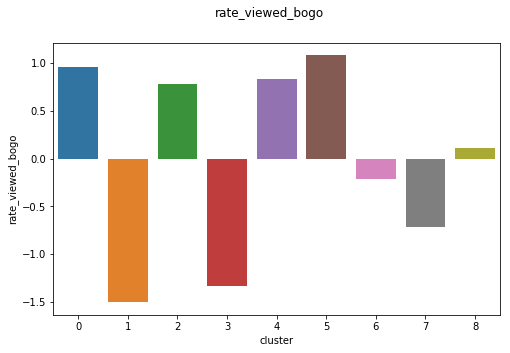

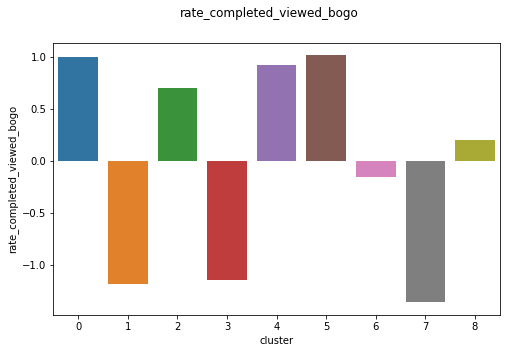

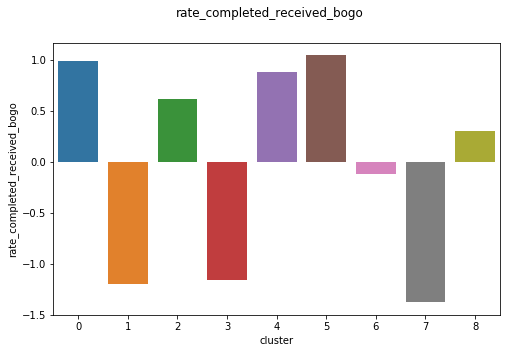

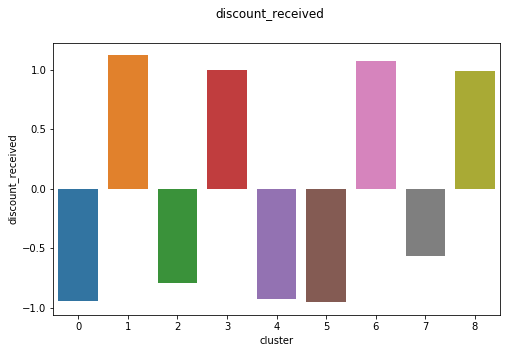

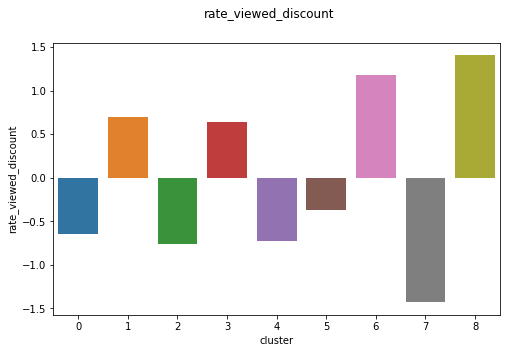

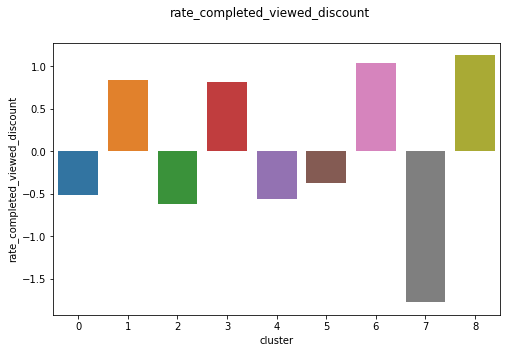

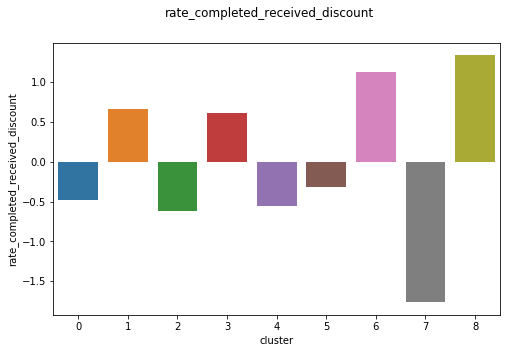

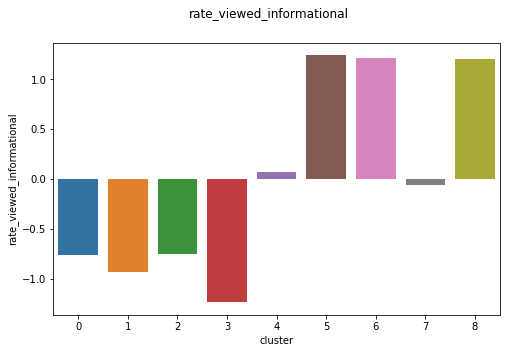

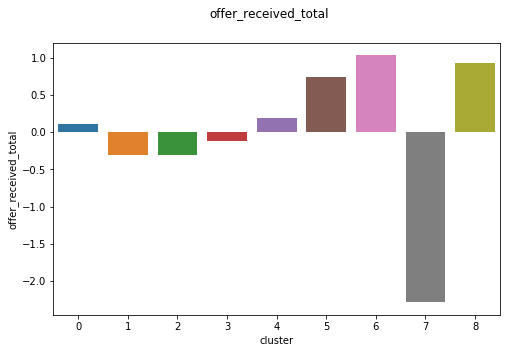

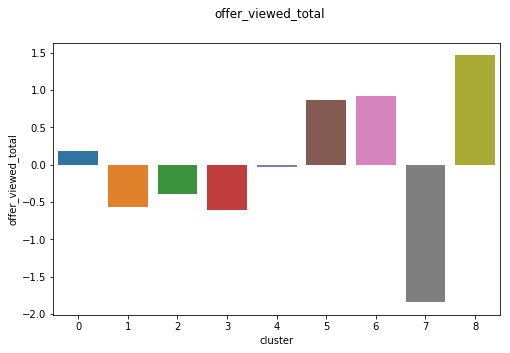

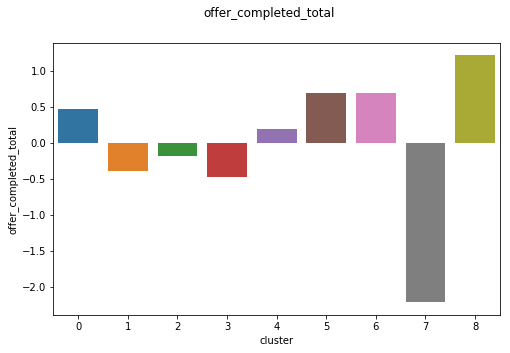

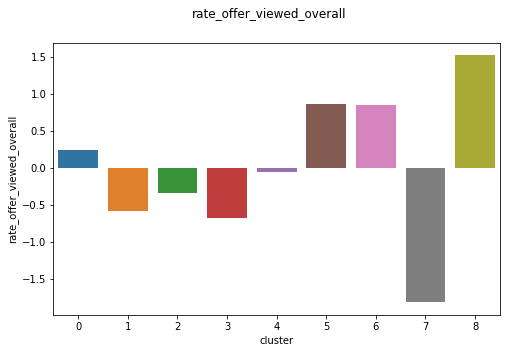

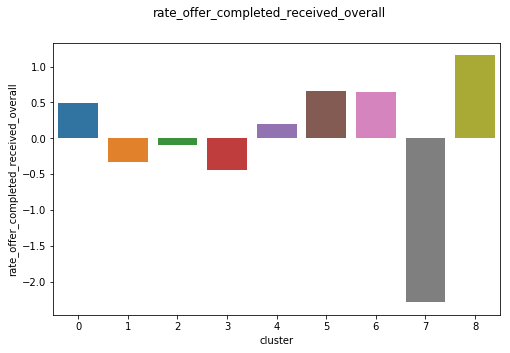

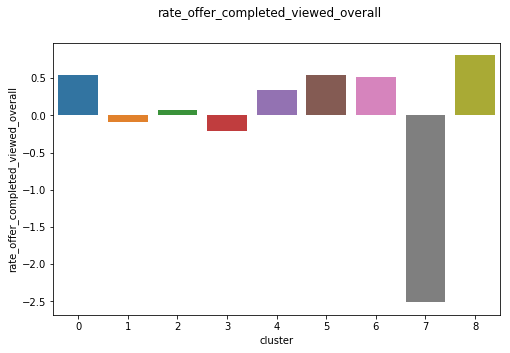

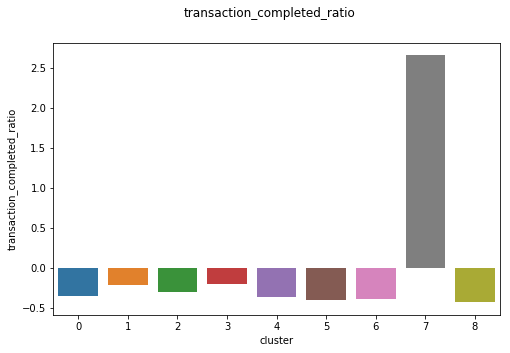

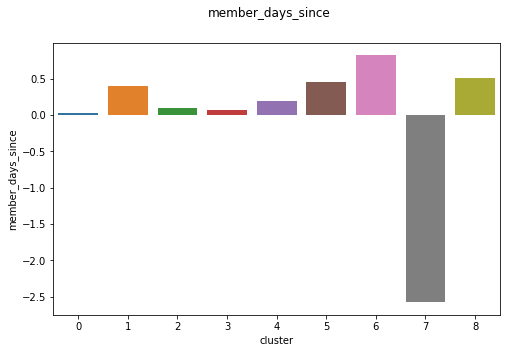

In [104]:
profile_main_norm = (profile_main_clust_ - profile_main_clust_.mean(axis=0))/profile_main_clust_.std(axis=0)
for col in profile_main_norm.columns:
    f, ax = plt.subplots(figsize=(8,5))
    sns.barplot(profile_main_clust_.index,col, data= profile_main_norm, ax= ax)
    f.suptitle(col)

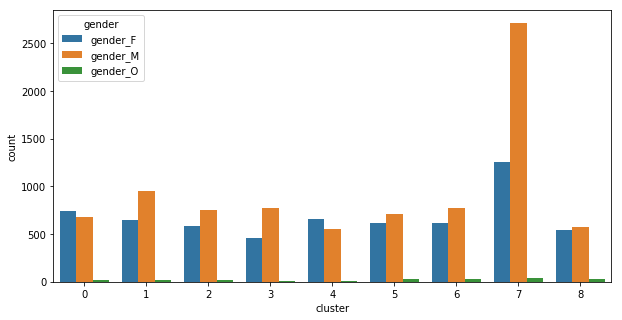

In [110]:
f, ax= plt.subplots(figsize=(10,5))
sns.countplot('cluster', hue='gender', data= profile_main_clust, ax=ax)

In [30]:
c0_main = profile_cluster_main[profile_cluster_main.cluster == 0]
c0_main.shape

(1443, 93)

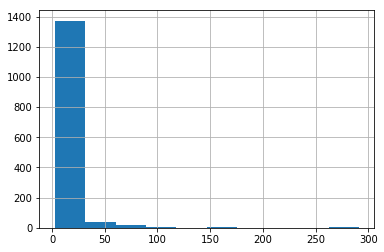

In [31]:
c0_main.avg_spending.hist()

In [37]:
c0_main_target = c0_main[c0_main.avg_spending < 10]
c0_main_target.shape

(215, 93)

In [38]:
c0_main_target_bogo_5 = c0_main_target[c0_main_target.avg_spending < 5]
c0_main_target_bogo_5.shape

(68, 93)

In [39]:
c0_main_target_bogo_10 = c0_main_target[c0_main_target.avg_spending >= 5]
c0_main_target_bogo_10.shape

(147, 93)

In [41]:
bogos = [0, 2, 4, 5]
discounts = [1,3, 6, 8]


In [79]:
profile_target_main = profile_cluster_main.copy()
bogos = [0, 2, 4, 5]
discounts = [1,3, 6, 8]

for bogo in bogos:
    cluster_df = profile_target_main[profile_target_main.cluster == bogo]
    
    #bogo subset
    subset_5 = (profile_target_main.cluster == bogo) & (profile_target_main.avg_spending < 5)
    subset_10 = (profile_target_main.cluster == bogo) & (profile_target_main.avg_spending < 10)\
                & (profile_target_main.avg_spending >= 5)
    
    #create new columns bogos
    profile_target_main.loc[subset_5, "bogo_5"] = 1
    profile_target_main.loc[subset_10, "bogo_10"] = 1
    
for discount in discounts:
    cluster_df = profile_target_main[profile_target_main.cluster == discount]
    
    #discpunt subset
    subset_7 = (profile_target_main.cluster == discount) & (profile_target_main.avg_spending < 7)
    subset_10 = (profile_target_main.cluster == discount) & (profile_target_main.avg_spending < 10)\
                & (profile_target_main.avg_spending >= 7)
    subset_20 = (profile_target_main.cluster == discount) & (profile_target_main.avg_spending < 20)\
                & (profile_target_main.avg_spending >= 10)
    
    #create new columns discounts
    profile_target_main.loc[subset_7, "discount_7"] = 1
    profile_target_main.loc[subset_10, "discount_10"] = 1
    profile_target_main.loc[subset_20, "discount_20"] = 1
    
profile_target_main = profile_target_main.fillna(0)

In [80]:
target_cols = ['bogo_5', 'bogo_10', 'discount_7', 'discount_10','discount_20']

In [86]:
profile_target_main[target_cols].sum().sum()

4871.0

In [82]:
target_cols = ['bogo_5', 'bogo_10', 'discount_7', 'discount_10','discount_20']

target_summary = pd.DataFrame()

for cluster in range(0,9):
    cluster_series = pd.Series(name=cluster)
    total_cluster = profile_target_main[profile_target_main.cluster==cluster]
    cluster_series['total_cluster'] = total_cluster.shape[0]
    for col in target_cols:
        cluster_series[col] = total_cluster[col].sum()

    target_summary = pd.concat([target_summary, cluster_series], axis=1, sort=True)

In [85]:
target_summary.T

bogo_10  bogo_5  discount_10  discount_20  discount_7  total_cluster
0    147.0    68.0          0.0          0.0         0.0         1443.0
1      0.0     0.0         81.0        385.0       688.0         1611.0
2    132.0   386.0          0.0          0.0         0.0         1353.0
3      0.0     0.0         63.0        288.0       578.0         1244.0
4    105.0    56.0          0.0          0.0         0.0         1230.0
5    108.0   178.0          0.0          0.0         0.0         1356.0
6      0.0     0.0         92.0        609.0       220.0         1414.0
7      0.0     0.0          0.0          0.0         0.0         4011.0
8      0.0     0.0         55.0        590.0        42.0         1146.0

In [104]:
target_summary_main = target_summary.T
target_summary_main['total_count'] = target_summary_main[target_cols].sum(axis=1)
target_summary_main['target_frac'] = target_summary_main.total_count / target_summary_main.total_cluster
target_summary_main

bogo_10  bogo_5  discount_10  discount_20  discount_7  total_cluster  \
0    147.0    68.0          0.0          0.0         0.0         1443.0   
1      0.0     0.0         81.0        385.0       688.0         1611.0   
2    132.0   386.0          0.0          0.0         0.0         1353.0   
3      0.0     0.0         63.0        288.0       578.0         1244.0   
4    105.0    56.0          0.0          0.0         0.0         1230.0   
5    108.0   178.0          0.0          0.0         0.0         1356.0   
6      0.0     0.0         92.0        609.0       220.0         1414.0   
7      0.0     0.0          0.0          0.0         0.0         4011.0   
8      0.0     0.0         55.0        590.0        42.0         1146.0   

   total_count  target_frac  
0        215.0     0.148995  
1       1154.0     0.716325  
2        518.0     0.382853  
3        929.0     0.746785  
4        161.0     0.130894  
5        286.0     0.210914  
6        921.0     0.651344  
7          0.0     0.000000  
8        687.0     0.599476

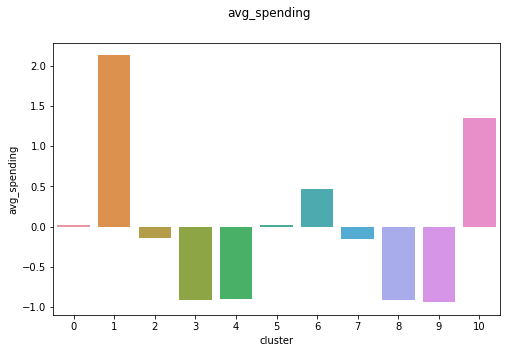

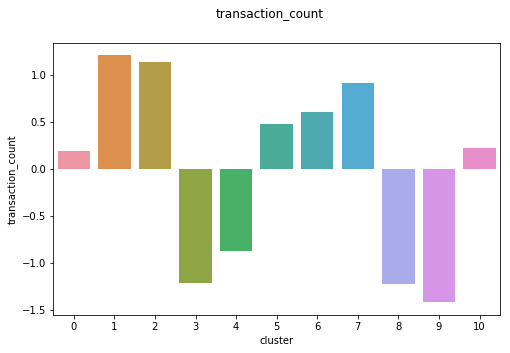

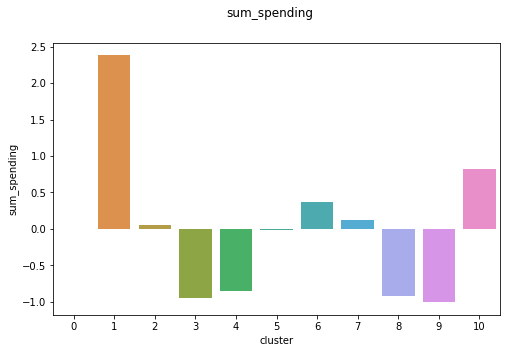

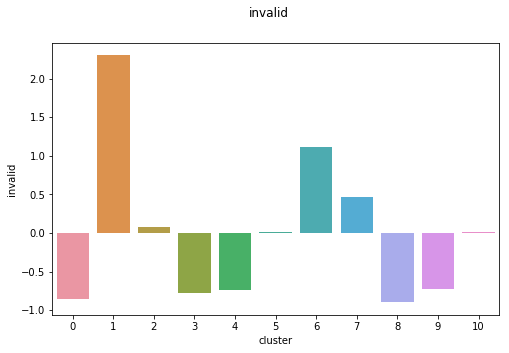

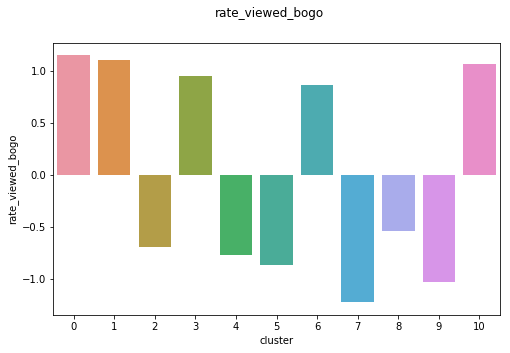

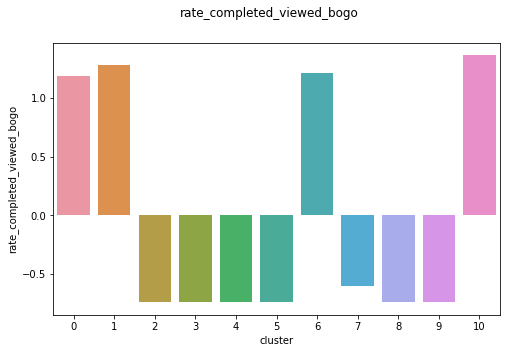

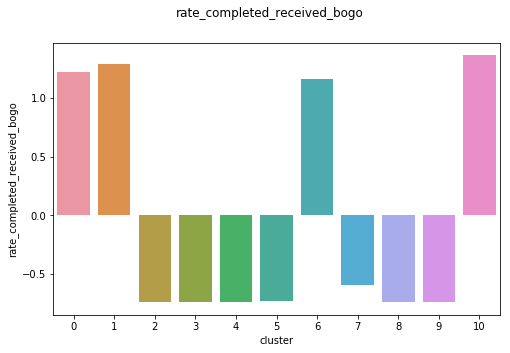

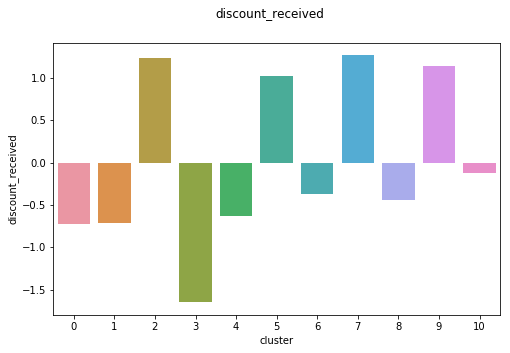

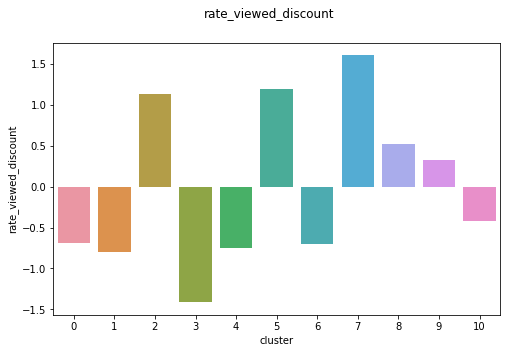

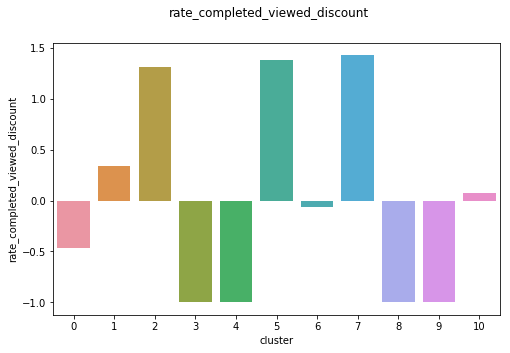

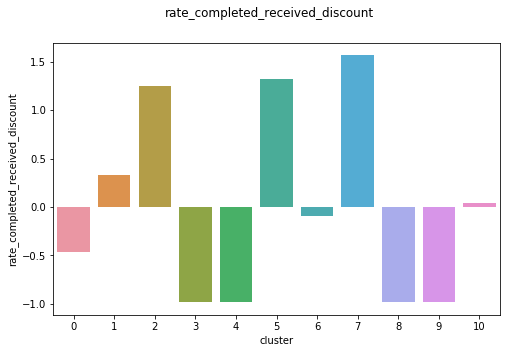

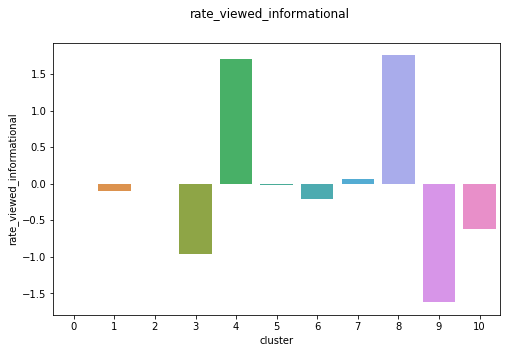

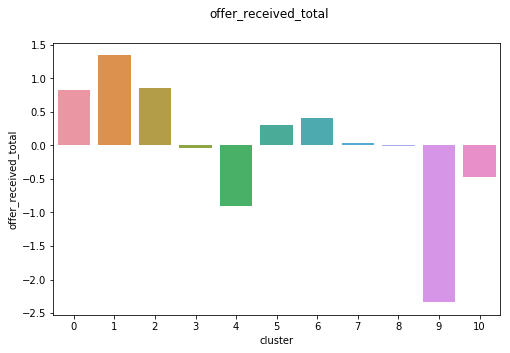

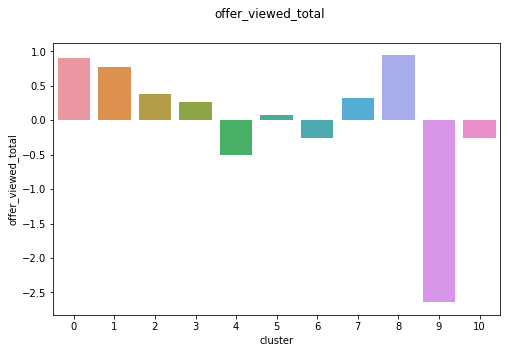

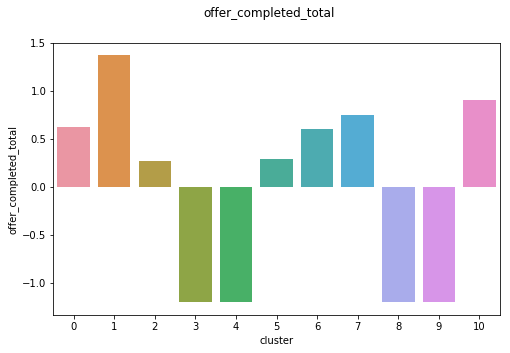

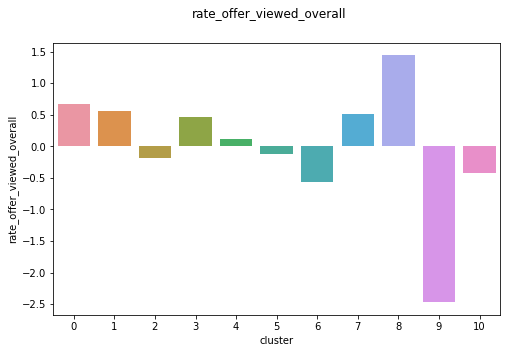

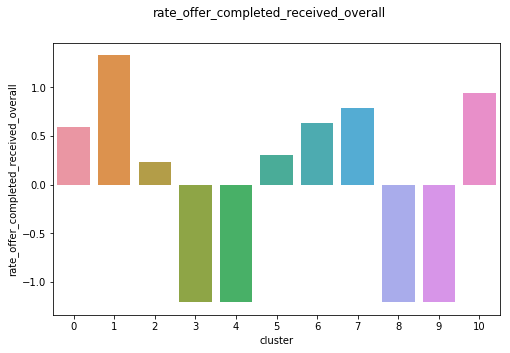

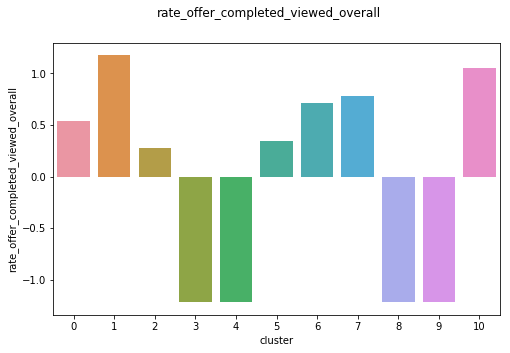

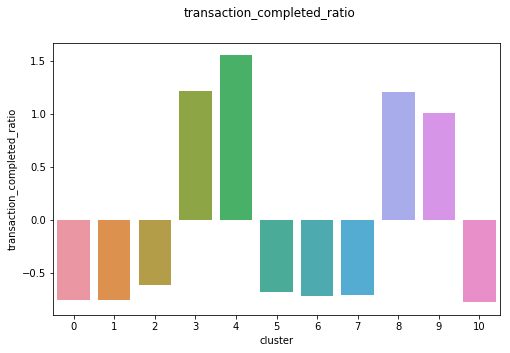

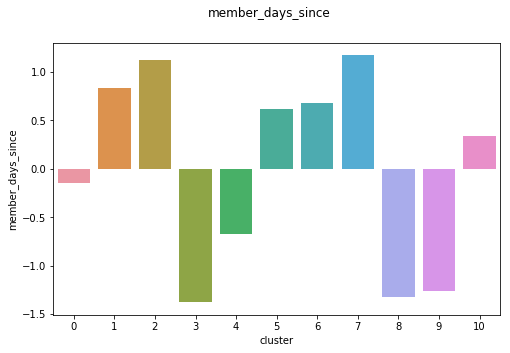

In [26]:
profile_sp_clust = profile_sp.copy()
profile_sp_clust['cluster'] = preds_sp

# gender_col = 
member_cols = profile_sp_clust.columns[profile_sp_clust.columns.str.contains('member_year')].tolist() 
profile_sp_clust['member_year'] = profile_sp_clust[member_cols].idxmax(axis=1)
profile_sp_clust = profile_sp_clust.drop(member_cols, axis=1)


cols_ = [
 'avg_spending',
 'transaction_count',
 'sum_spending',
 'invalid',
 'rate_viewed_bogo',
 'rate_completed_viewed_bogo',
 'rate_completed_received_bogo',
 'discount_received',
 'rate_viewed_discount',
 'rate_completed_viewed_discount',
 'rate_completed_received_discount',
 'rate_viewed_informational',
 'offer_received_total',
 'offer_viewed_total',
 'offer_completed_total',
 'rate_offer_viewed_overall',
 'rate_offer_completed_received_overall',
 'rate_offer_completed_viewed_overall',
 'transaction_completed_ratio',
 'member_days_since'
 ]
pd.set_option('display.max_columns', 500)

profile_sp_clust_ = profile_sp_clust.groupby('cluster').mean()[cols_]


profile_sp_norm = (profile_sp_clust_ - profile_sp_clust_.mean(axis=0))/profile_sp_clust_.std(axis=0)
for col in profile_sp_norm.columns:
    f, ax = plt.subplots(figsize=(8,5))
    sns.barplot(profile_sp_clust_.index,col, data= profile_sp_norm, ax= ax)
    f.suptitle(col)

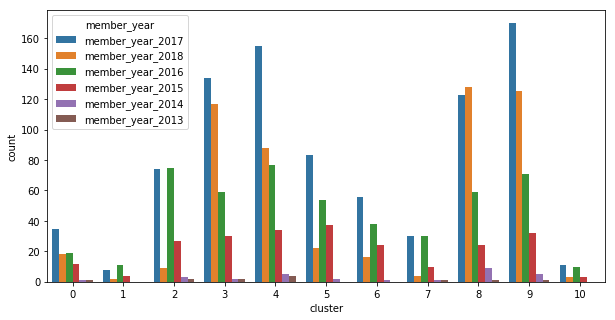

In [27]:
f, ax= plt.subplots(figsize=(10,5))
sns.countplot('cluster', hue='member_year', data= profile_sp_clust, ax=ax)

In [87]:
profile_target_sp = profile_sp_clust.copy()
bogos = [0, 6,10]
discounts = [1,2,5,7]

for bogo in bogos:
    cluster_df = profile_target_sp[profile_target_sp.cluster == bogo]
    
    #bogo subset
    subset_5 = (profile_target_sp.cluster == bogo) & (profile_target_sp.avg_spending < 5)
    subset_10 = (profile_target_sp.cluster == bogo) & (profile_target_sp.avg_spending < 10)\
                & (profile_target_sp.avg_spending >= 5)
    
    #create new columns bogos
    profile_target_sp.loc[subset_5, "bogo_5"] = 1
    profile_target_sp.loc[subset_10, "bogo_10"] = 1
    
for discount in discounts:
    cluster_df = profile_target_sp[profile_target_sp.cluster == discount]
    
    #discpunt subset
    subset_7 = (profile_target_sp.cluster == discount) & (profile_target_sp.avg_spending < 7)
    subset_10 = (profile_target_sp.cluster == discount) & (profile_target_sp.avg_spending < 10)\
                & (profile_target_sp.avg_spending >= 7)
    subset_20 = (profile_target_sp.cluster == discount) & (profile_target_sp.avg_spending < 20)\
                & (profile_target_sp.avg_spending >= 10)
    
    #create new columns discounts
    profile_target_sp.loc[subset_7, "discount_7"] = 1
    profile_target_sp.loc[subset_10, "discount_10"] = 1
    profile_target_sp.loc[subset_20, "discount_20"] = 1
    
profile_target_sp = profile_target_sp.fillna(0)

In [101]:
target_cols = ['bogo_5', 'bogo_10', 'discount_7', 'discount_10','discount_20']

target_summary_sp = pd.DataFrame()

for cluster in range(0,11):
    cluster_series = pd.Series(name=cluster)
    total_cluster = profile_target_sp[profile_target_sp.cluster==cluster]
    cluster_series['total_cluster'] = total_cluster.shape[0]
    for col in target_cols:
        cluster_series[col] = total_cluster[col].sum()

    target_summary_sp = pd.concat([target_summary_sp, cluster_series], axis=1, sort=True)

In [102]:
target_summary_sp.T[target_cols].sum().sum()

709.0

In [103]:
target_summary_sp = target_summary_sp.T
target_summary_sp['total_count'] = target_summary_sp[target_cols].sum(axis=1)
target_summary_sp['target_frac'] = target_summary_sp.total_count / target_summary_sp.total_cluster
target_summary_sp

bogo_10  bogo_5  discount_10  discount_20  discount_7  total_cluster  \
0       4.0    75.0          0.0          0.0         0.0           86.0   
1       0.0     0.0          3.0          4.0        16.0           25.0   
2       0.0     0.0          2.0          7.0       180.0          190.0   
3       0.0     0.0          0.0          0.0         0.0          344.0   
4       0.0     0.0          0.0          0.0         0.0          363.0   
5       0.0     0.0          2.0          9.0       185.0          198.0   
6      10.0   114.0          0.0          0.0         0.0          135.0   
7       0.0     0.0          3.0          3.0        70.0           76.0   
8       0.0     0.0          0.0          0.0         0.0          344.0   
9       0.0     0.0          0.0          0.0         0.0          404.0   
10      7.0    15.0          0.0          0.0         0.0           27.0   

    total_count  target_frac  
0          79.0     0.918605  
1          23.0     0.920000  
2         189.0     0.994737  
3           0.0     0.000000  
4           0.0     0.000000  
5         196.0     0.989899  
6         124.0     0.918519  
7          76.0     1.000000  
8           0.0     0.000000  
9           0.0     0.000000  
10         22.0     0.814815